# German Risk Credit Predict
This is german risk Credit dataset can be found in Kaggle [German Risk](https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk) my goal is to create a predict model and use this model to create an score for each client.


# Tables of Content:

**1. [Introduction](#Introduction)**

    - Info's about datasets
**2. [Dataset](#Dataset)**

    - Importing Librarys
    - Importing Dataset
    - The first rows of our dataset
    - Looking the Type of Data
    - Shape of data
    - Null Numbers
    - Unique values
**4. [EDA](#EDA)**

    - Ploting some graphical and descriptive informations
**5. [Correlation of data](#Correlation)**

	- Correlation Data
**6. [Preprocess](#Preprocessing)**

    - One hot Enconding
    - Ordinal Enconding
    - Correlation Data
**7.  [Model](#Training)**

    - Setting X and Y
    - Spliting the X and Y in train and test
    - XGBoost, LGBM, CART
    - Cross Validation
**8.  [Hyperparameter Optimization using Optuna](#Hyperparameter)**

    - Hyperparameter Space
    - Optuna Study
    - Final Model
    - Confusion Matrix
    - ROC Curve
**9. [Ranking the final model](#Ranking)**

    - Using SHAP
    - Creating Scores and Decils

# Introduction
Context

Each person is classified as good or bad credit risks according to the set of attributes.The selected attributes are:
* Age (numeric)
* Sex (text: male, female)
* Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
* Housing (text: own, rent, or free)
* Saving accounts (text - little, moderate, quite rich, rich)
* Checking account (text - little, moderate, rich)
* Credit amount (numeric, in DM)
* Duration (numeric, in month)
* Purpose(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others
* Risk (Value target - Good or Bad Risk)

The business team came to you because they want to understand the behavior and the profile of the most risk clients and our goal here is to create a predictive model to help them

My goal here is to create a predict model, after that I'll use optuna for hyperparameter optimization then 'rank' the customer in scores and then use the shap for identify each variable is most important

# Dataset

In [3]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.5 MB/s eta 0:00:00


In [29]:
import numpy as np
import pandas as pd
import sys
import timeit
import gc
import sklearn
from sklearn.model_selection import KFold
import seaborn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import lightgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import optuna
import matplotlib.pylab as plt
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.graph_objs as go # criará de fato os gráficos
from plotly.offline import plot, iplot
plotly.offline.init_notebook_mode(connected = True)
from collections import Counter
import plotly.io as pio
pio.renderers
pio.renderers.default = 'colab'

In [6]:
!ls

sample_data


In [7]:
# read the dataset
df = pd.read_csv('german_credit_data.csv')

In [8]:
df

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,996,40,male,3,own,little,little,3857,30,car,good
997,997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,998,23,male,2,free,little,little,1845,45,radio/TV,bad


* Looking the Type of Data
* Null Numbers or/and Unique values

In [9]:
# knowing the shape of the data and search for missing
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB
None


In [10]:
# looking unique values
print(df.nunique())

Unnamed: 0          1000
Age                   53
Sex                    2
Job                    4
Housing                3
Saving accounts        4
Checking account       3
Credit amount        921
Duration              33
Purpose                8
Risk                   2
dtype: int64


# EDA
Let's start looking through target variable and their distribuition

In [30]:
trace0 = go.Bar(
            x = df[df["Risk"]== 'good']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'good']["Risk"].value_counts().values,
            name='Good Credit'
    )

trace1 = go.Bar(
            x = df[df["Risk"]== 'bad']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'bad']["Risk"].value_counts().values,
            name='Bad Credit'
    )

data = [trace0, trace1]

layout = go.Layout(

)

layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='Risk Variable'
    ),
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')


In [32]:
df_age = df['Age'].values.tolist()
df_good = df.loc[df["Risk"] == 'good']['Age'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Age'].values.tolist()

hist_1 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)

hist_2 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)

hist_3 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

data = [hist_1, hist_2, hist_3]

layout = dict(
    title="Type of Credit by Age",
    xaxis = dict(title="Age")
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

We can see that people with Bad Credit tend to more youth

In [33]:
df_job = df['Job'].values.tolist()
df_good = df.loc[df["Risk"] == 'good']['Job'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Job'].values.tolist()

hist_1 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)

hist_2 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)

hist_3 = go.Histogram(
    x=df_job,
    histnorm='probability',
    name="Overall Job"
)

data = [hist_1, hist_2, hist_3]

layout = dict(
    title="Type of Credit by Job",
    xaxis = dict(title="Job")
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

we can say that highly skilled (0 and 3) have more bad credit than the others

In [34]:
df_housing = df['Housing'].values.tolist()
df_good = df.loc[df["Risk"] == 'good']['Housing'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Housing'].values.tolist()

hist_1 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)

hist_2 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)

hist_3 = go.Histogram(
    x=df_housing,
    histnorm='probability',
    name="Overall Housing"
)

data = [hist_1, hist_2, hist_3]

layout = dict(
    title="Type of Credit by Housing",
    xaxis = dict(title="Housing")
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

people that owns house have better credit

In [35]:
df_saving = df['Saving accounts'].values.tolist()
df_good = df.loc[df["Risk"] == 'good']['Saving accounts'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Saving accounts'].values.tolist()

hist_1 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)

hist_2 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)

hist_3 = go.Histogram(
    x=df_saving,
    histnorm='probability',
    name="Overall saving"
)

data = [hist_1, hist_2, hist_3]

layout = dict(
    title="Type of Credit by Saving",
    xaxis = dict(title="Saving")
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

people with more savings accounts also have a better credit

In [36]:
df_checking = df['Checking account'].values.tolist()
df_good = df.loc[df["Risk"] == 'good']['Checking account'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Checking account'].values.tolist()

hist_1 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)

hist_2 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)

hist_3 = go.Histogram(
    x=df_checking,
    histnorm='probability',
    name="Overall checking account"
)

data = [hist_1, hist_2, hist_3]

layout = dict(
    title="Type of Credit by Checking Account",
    xaxis = dict(title="Checking Account")
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

the same here, people with more checking account has a better credit

In [37]:
df_credit = df['Credit amount'].values.tolist()
df_good = df.loc[df["Risk"] == 'good']['Credit amount'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Credit amount'].values.tolist()

hist_1 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)

hist_2 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)

hist_3 = go.Histogram(
    x=df_credit,
    histnorm='probability',
    name="Overall Credit amount"
)

data = [hist_1, hist_2, hist_3]

layout = dict(
    title="Type of Credit by Credit amount",
    xaxis = dict(title="Credit amount")
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

people with more than 4k in credit amount have a bad credit than people with less

In [38]:
df_duration = df['Duration'].values.tolist()
df_good = df.loc[df["Risk"] == 'good']['Duration'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Duration'].values.tolist()

hist_1 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)

hist_2 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)

hist_3 = go.Histogram(
    x=df_duration,
    histnorm='probability',
    name="Overall Duration"
)

data = [hist_1, hist_2, hist_3]

layout = dict(
    title="Type of Credit by Duration",
    xaxis = dict(title="Duration")
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

more credit duration worse is the credit

In [39]:
df_purpose = df['Purpose'].values.tolist()
df_good = df.loc[df["Risk"] == 'good']['Purpose'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Purpose'].values.tolist()

hist_1 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)

hist_2 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)

hist_3 = go.Histogram(
    x=df_purpose,
    histnorm='probability',
    name="Overall Purpose"
)

data = [hist_1, hist_2, hist_3]

layout = dict(
    title="Type of Credit by Purpose",
    xaxis = dict(title="Purpose")
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')



people that the purpose is to buy radio/TV have a better credit

# Preprocessing

In [46]:
df.dtypes

Unnamed: 0           int64
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

In [47]:
df.isna().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

We will use one hot enconding for the sex, housing and purpose variable.

In [48]:
one_hot = {
    "Sex": "sex",
    "Housing": "hous",
    "Purpose": "purp"
}

And ordinal enconding for the others

In [111]:
ordinal_encoding = {
    "Saving accounts": {
        None: 0,
        "little": 1,
        "moderate": 2,
        "quite rich": 3,
        "rich": 4,
    },
    "Checking account": {
        None: 1,
        "little": 2,
        "moderate": 3,
        "rich": 4,
    },
    "Risk": {
        "bad": 1,
        "good": 0,
    }
}

In [117]:
def one_hot_enconding(df, col_prefix: dict):
    df = df.copy()
    for col, prefix in col_prefix.items():
        df = pd.get_dummies(data=df, prefix=prefix, columns=[col,],dtype=int)
    return df

In [113]:
def encode_ordinal(df, custom_ordinals: dict):
    df = df.copy()
    for col, map_dict in custom_ordinals.items():
        df[col] = df[col].replace(map_dict)
    return df

In [118]:
df_encode = df.copy()
df_encode = one_hot_enconding(df_encode, one_hot)
df_encode = encode_ordinal(df_encode, ordinal_encoding)
df_encode

,Unnamed: 0,Age,Job,Saving accounts,Checking account,Credit amount,Duration,Risk,sex_female,sex_male,...,hous_own,hous_rent,purp_business,purp_car,purp_domestic appliances,purp_education,purp_furniture/equipment,purp_radio/TV,purp_repairs,purp_vacation/others
0,0,67,2,0,2,1169,6,0,0,1,...,1,0,0,0,0,0,0,1,0,0
1,1,22,2,1,3,5951,48,1,1,0,...,1,0,0,0,0,0,0,1,0,0
2,2,49,1,1,1,2096,12,0,0,1,...,1,0,0,0,0,1,0,0,0,0
3,3,45,2,1,2,7882,42,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,4,53,2,1,2,4870,24,1,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,1,1,1,1736,12,0,1,0,...,1,0,0,0,0,0,1,0,0,0
996,996,40,3,1,2,3857,30,0,0,1,...,1,0,0,1,0,0,0,0,0,0
997,997,38,2,1,1,804,12,0,0,1,...,1,0,0,0,0,0,0,1,0,0
998,998,23,2,1,2,1845,45,1,0,1,...,0,0,0,0,0,0,0,1,0,0


In [119]:
df_encode.dtypes

Unnamed: 0                  int64
Age                         int64
Job                         int64
Saving accounts             int64
Checking account            int64
Credit amount               int64
Duration                    int64
Risk                        int64
sex_female                  int64
sex_male                    int64
hous_free                   int64
hous_own                    int64
hous_rent                   int64
purp_business               int64
purp_car                    int64
purp_domestic appliances    int64
purp_education              int64
purp_furniture/equipment    int64
purp_radio/TV               int64
purp_repairs                int64
purp_vacation/others        int64
dtype: object

In [120]:
df_encode.isna().sum()

Unnamed: 0                  0
Age                         0
Job                         0
Saving accounts             0
Checking account            0
Credit amount               0
Duration                    0
Risk                        0
sex_female                  0
sex_male                    0
hous_free                   0
hous_own                    0
hous_rent                   0
purp_business               0
purp_car                    0
purp_domestic appliances    0
purp_education              0
purp_furniture/equipment    0
purp_radio/TV               0
purp_repairs                0
purp_vacation/others        0
dtype: int64

In [121]:
# Check for duplicate rows
df.duplicated().sum()

0

In [122]:
df_encode.corr()['Risk'].sort_values()

hous_own                   -0.134589
purp_radio/TV              -0.106922
Age                        -0.091127
sex_male                   -0.075493
Saving accounts            -0.033871
purp_domestic appliances    0.008016
purp_repairs                0.020828
purp_furniture/equipment    0.020971
purp_car                    0.022621
purp_vacation/others        0.028058
Job                         0.032735
Unnamed: 0                  0.034606
purp_business               0.036129
purp_education              0.049085
sex_female                  0.075493
hous_free                   0.081556
hous_rent                   0.092785
Credit amount               0.154739
Checking account            0.197788
Duration                    0.214927
Risk                        1.000000
Name: Risk, dtype: float64

In [123]:
df_encode.columns

Index(['Unnamed: 0', 'Age', 'Job', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Risk', 'sex_female', 'sex_male',
       'hous_free', 'hous_own', 'hous_rent', 'purp_business', 'purp_car',
       'purp_domestic appliances', 'purp_education',
       'purp_furniture/equipment', 'purp_radio/TV', 'purp_repairs',
       'purp_vacation/others'],
      dtype='object')

getting all the cols that we are going to use in our model

In [124]:
model_cols = ['Age', 'Job', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'sex_female', 'sex_male',
       'hous_free', 'hous_own', 'hous_rent', 'purp_business', 'purp_car',
       'purp_domestic appliances', 'purp_education',
       'purp_furniture/equipment', 'purp_radio/TV', 'purp_repairs',
       'purp_vacation/others']

In [125]:
df_encode.loc[df_encode['Risk']==0].mean()

Unnamed: 0                   492.960000
Age                           36.224286
Job                            1.890000
Saving accounts                1.211429
Checking account               1.877143
Credit amount               2985.457143
Duration                      19.207143
Risk                           0.000000
sex_female                     0.287143
sex_male                       0.712857
hous_free                      0.091429
hous_own                       0.752857
hous_rent                      0.155714
purp_business                  0.090000
purp_car                       0.330000
purp_domestic appliances       0.011429
purp_education                 0.051429
purp_furniture/equipment       0.175714
purp_radio/TV                  0.311429
purp_repairs                   0.020000
purp_vacation/others           0.010000
dtype: float64

In [126]:
df_encode.loc[df_encode['Risk']==1].mean()

Unnamed: 0                   514.760000
Age                           33.963333
Job                            1.936667
Saving accounts                1.140000
Checking account               2.290000
Credit amount               3938.126667
Duration                      24.860000
Risk                           1.000000
sex_female                     0.363333
sex_male                       0.636667
hous_free                      0.146667
hous_own                       0.620000
hous_rent                      0.233333
purp_business                  0.113333
purp_car                       0.353333
purp_domestic appliances       0.013333
purp_education                 0.076667
purp_furniture/equipment       0.193333
purp_radio/TV                  0.206667
purp_repairs                   0.026667
purp_vacation/others           0.016667
dtype: float64

some correlation

In [127]:
df_encode.astype(float).corr().abs().sort_values(by='Risk',ascending=False)['Risk']

Risk                        1.000000
Duration                    0.214927
Checking account            0.197788
Credit amount               0.154739
hous_own                    0.134589
purp_radio/TV               0.106922
hous_rent                   0.092785
Age                         0.091127
hous_free                   0.081556
sex_female                  0.075493
sex_male                    0.075493
purp_education              0.049085
purp_business               0.036129
Unnamed: 0                  0.034606
Saving accounts             0.033871
Job                         0.032735
purp_vacation/others        0.028058
purp_car                    0.022621
purp_furniture/equipment    0.020971
purp_repairs                0.020828
purp_domestic appliances    0.008016
Name: Risk, dtype: float64

duration, checking account, credit amount and owns house have the most corr

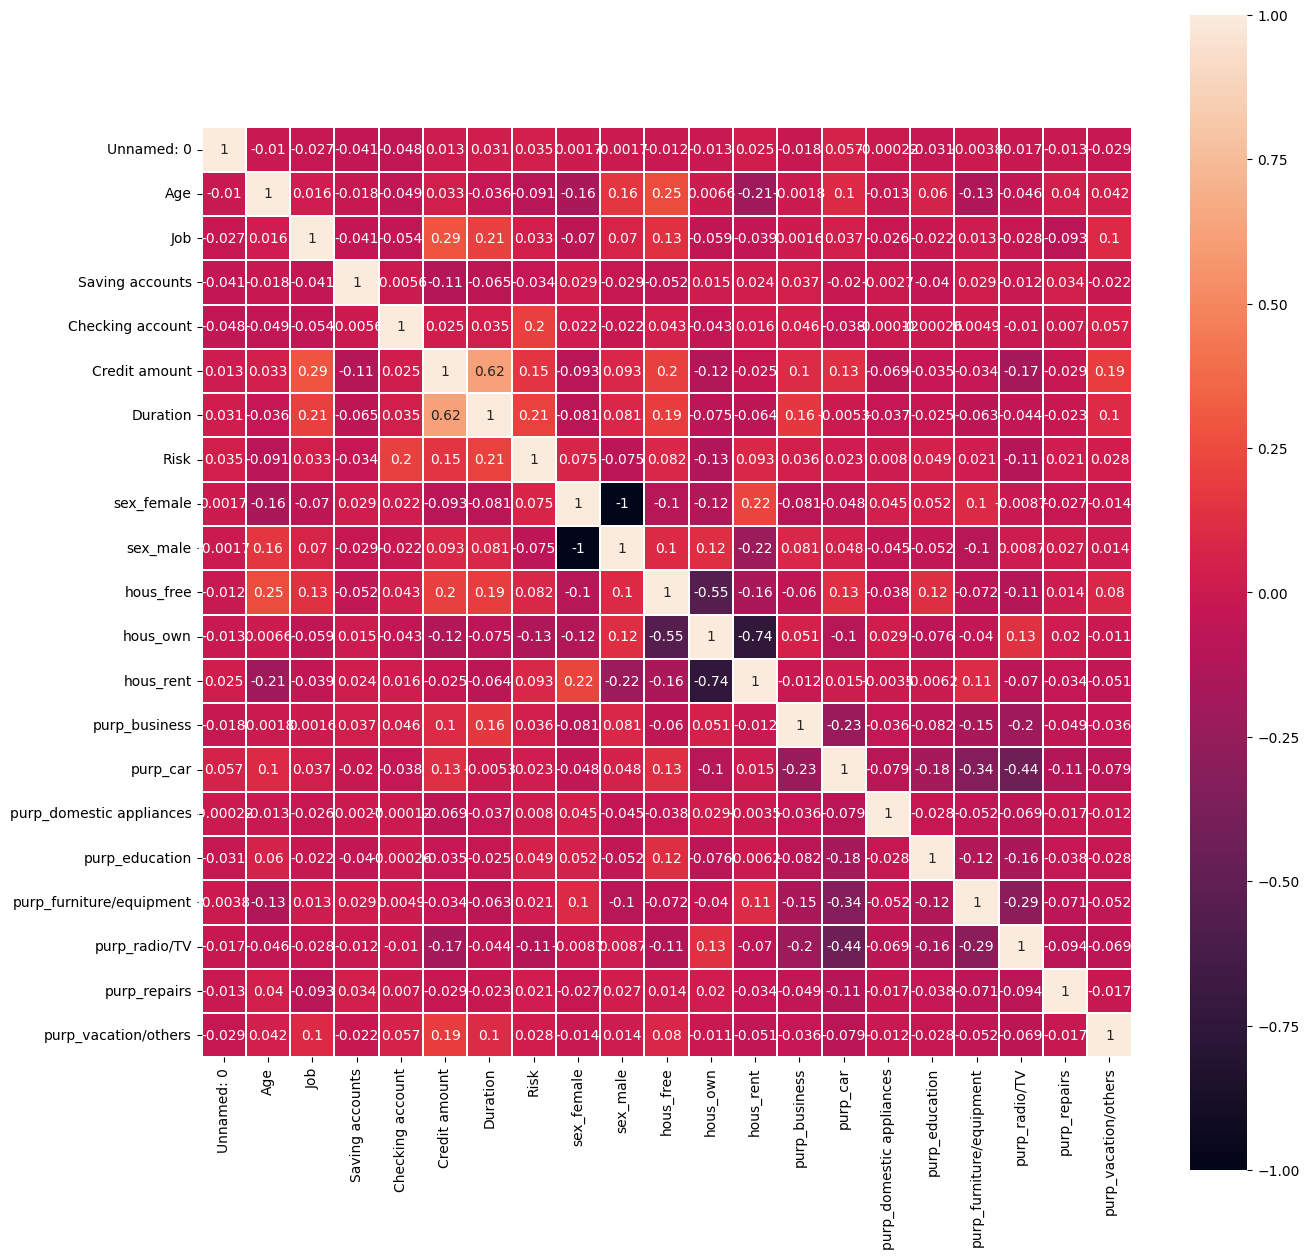

In [128]:
plt.figure(figsize=(15,15))
sns.heatmap(df_encode.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True,  linecolor='white', annot=True)
plt.show()

# Training some Models

In [129]:
X = df_encode.loc[:,model_cols]
y = df_encode.loc[:,'Risk']

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 19), (300, 19), (700,), (300,))

Here we are going to train 5 models

In [132]:
# prepare models
lgbmparameters = {'verbose': -1}
models = []
models.append(('XGB', XGBClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('LGBM', LGBMClassifier(**lgbmparameters)))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
n_splits = 10
for name, model in models:
        kfold = KFold(n_splits=n_splits)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)


XGB: 0.717143 (0.049816)
CART: 0.651429 (0.066455)
LGBM: 0.741429 (0.051686)
RF: 0.718571 (0.051922)
NB: 0.690000 (0.080064)


In [133]:
box_1 = go.Box(
    x=n_splits*['XGB'],
    y=results[0],
    name="XGB"
)
box_2 = go.Box(
    x=n_splits*['CART'],
    y=results[1],
    name="CART"
)
box_3 = go.Box(
    x=n_splits*['LGBM'],
    y=results[2],
    name="LGBM"
)
box_4 = go.Box(
    x=n_splits*['RF'],
    y=results[3],
    name="RF"
)
box_5 = go.Box(
    x=n_splits*['NB'],
    y=results[4],
    name="NB"
)

data = [box_1, box_2, box_3, box_4, box_5]
layout = go.Layout(
    yaxis=dict(
        title='Model Results'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

The best models was RandomForest and LGBM, we are going to train this model and use optuna for hyperparameter optimization

In [68]:
lgbm_model = LGBMClassifier(**lgbmparameters).fit(X_train, y_train)
y_prob_lgbm = lgbm_model.predict_proba(X_test)

In [69]:
print('For the LGBM Model, the test Accu is: '+ str(accuracy_score(y_test,y_prob_lgbm[:,1].round())))

For the LGBM Model, the test Accu is: 0.7533333333333333


In [70]:
rf_model = RandomForestClassifier().fit(X_train, y_train)
y_prob_rf = rf_model.predict_proba(X_test)

In [71]:
print('For the RandomForest Model, the test Accu is: '+ str(accuracy_score(y_test,y_prob_rf[:,1].round())))

For the RandomForest Model, the test Accu is: 0.72


# Hyperparameter Optimization using Optuna

In [81]:
def objective(trial, X_train, y_train, X_test, y_test, balanced, method):
    '''
    Input:
        trial: trial of the test
        X_train:
        y_train:
        X_test:
        y_test:
        balanced:balanced or None
        method: XGBoost, CatBoost or LGBM
    Output: Metrics of validation
        auc, ks, log_loss
        auc_logloss_ks(y_test, y_pred)[0]
    '''
    gc.collect()
    if method=='LGBM':
        param_grid = {'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True),
                      'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                      'lambda_l1': trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
                      'lambda_l2': trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
                      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
                      'max_depth': trial.suggest_int('max_depth', 5, 64),
                      'feature_fraction': trial.suggest_float("feature_fraction", 0.4, 1.0),
                      'bagging_fraction': trial.suggest_float("bagging_fraction", 0.4, 1.0),
                      'bagging_freq': trial.suggest_int("bagging_freq", 1, 7),
                      'verbose': -1

                     }
        model = LGBMClassifier(**param_grid,tree_method='gpu_hist',gpu_id=0)

        print('LGBM - Optimization using optuna')
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_test)[:,1]
    if method=='RF':
        param_grid = {
                      'max_features': trial.suggest_int('max_features', 4, 20),
                      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 25),
                      'max_depth': trial.suggest_int('max_depth', 5, 64),
                      'min_samples_split': trial.suggest_int("min_samples_split", 2, 30),
                      'n_estimators': trial.suggest_int("n_estimators", 100, 2000)

                     }
        model = RandomForestClassifier(**param_grid)

        print('RandomForest - Optimization using optuna')
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_test)[:,1]

    if method=='XGBoost':
        param_grid = {'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True),
                      'max_depth': trial.suggest_int('max_depth', 3, 16),
                      'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
                      'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log = True),
                      'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log = True),
                      'lambda': trial.suggest_float('lambda', 0.0001, 10.0, log = True),
                      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
                      'booster': 'gbtree',
                      'random_state': 42,
                     }
        model = XGBClassifier(**param_grid,tree_method='gpu_hist',gpu_id=0)
        print('XGBoost - Optimization using optuna')
        model.fit(X_train, y_train,verbose=False)
        y_pred = model.predict_proba(X_test)[:,1]

    auc_res = accuracy_score(y_test, y_pred.round())
    print('accuracy:'+str(auc_res))
    return accuracy_score(y_test, y_pred.round())

def tuning(X_train, y_train, X_test, y_test, balanced, method):
    '''
    Input:
        trial:
        x_train:
        y_train:
        X_test:
        y_test:
        balanced:balanced or not balanced
        method: XGBoost, CatBoost or LGBM
    Output: Metrics of validation
        auc, ks, log_loss
        auc_logloss_ks(y_test, y_pred)[0]
    '''
    study = optuna.create_study(direction='maximize', study_name=method+' Classifier')
    func = lambda trial: objective(trial, X_train, y_train, X_test, y_test, balanced, method)
    print('Starting the optimization')
    time_max_tuning = 60*3 # max time in seconds to stop
    study.optimize(func, timeout=time_max_tuning)
    return study

def train(X_train, y_train, X_test, y_test, balanced, method):
    '''
    Input:
        X_train:
        y_train:
        X_test:
        y_test:
        balanced:balanced or None
        method: XGBoost, CatBoost or LGBM
    Output: predict model
    '''
    print('Tuning')
    study = tuning(X_train, y_train, X_test, y_test, balanced, method)
    if method=='LGBM':
        model = LGBMClassifier(**study.best_params)
        print('Last Fit')
        model.fit(X_train, y_train, eval_set=[(X_test,y_test)],
                 callbacks = [lightgbm.early_stopping(stopping_rounds=100), lightgbm.log_evaluation(period=5000)])
    if method=='XGBoost':
        model = XGBClassifier(**study.best_params)
        print('Last Fit')
        model.fit(X_train, y_train, eval_set=[(X_test,y_test)],
                 early_stopping_rounds=100,verbose = False)
    if method=='RF':
        model = RandomForestClassifier(**study.best_params)
        print('Last Fit')
        model.fit(X_train, y_train)
    return model, study

In [80]:
lgbm_model, study_lgbm = train(X_train, y_train, X_test, y_test, balanced='balanced', method='LGBM')

[I 2024-05-29 19:53:26,865] A new study created in memory with name: LGBM Classifier


Tuning
Starting the optimization
LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:53:27,071] Trial 0 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.00012368876881892058, 'num_leaves': 173, 'lambda_l1': 0.001804206074687313, 'lambda_l2': 0.00047167479237512417, 'min_data_in_leaf': 32, 'max_depth': 11, 'feature_fraction': 0.8813811470600155, 'bagging_fraction': 0.6933398776185834, 'bagging_freq': 1}. Best is trial 0 with value: 0.6966666666666667.
[I 2024-05-29 19:53:27,254] Trial 1 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.008010540887074064, 'num_leaves': 249, 'lambda_l1': 6.064883828818012e-07, 'lambda_l2': 1.5795308988870422, 'min_data_in_leaf': 60, 'max_depth': 54, 'feature_fraction': 0.7081020256074535, 'bagging_fraction': 0.8687830384126345, 'bagging_freq': 4}. Best is trial 0 with value: 0.6966666666666667.


LGBM - Optimization using optuna
auc:0.6966666666666667
LGBM - Optimization using optuna


[I 2024-05-29 19:53:27,429] Trial 2 finished with value: 0.72 and parameters: {'learning_rate': 0.08467591332140234, 'num_leaves': 49, 'lambda_l1': 0.008230191822468867, 'lambda_l2': 3.2262865394306467e-06, 'min_data_in_leaf': 71, 'max_depth': 39, 'feature_fraction': 0.4582598071979754, 'bagging_fraction': 0.7958645857593916, 'bagging_freq': 1}. Best is trial 2 with value: 0.72.
[I 2024-05-29 19:53:27,609] Trial 3 finished with value: 0.7166666666666667 and parameters: {'learning_rate': 0.07541263944093524, 'num_leaves': 206, 'lambda_l1': 0.00021288514317164433, 'lambda_l2': 6.858859242189771e-06, 'min_data_in_leaf': 59, 'max_depth': 31, 'feature_fraction': 0.9065973155873823, 'bagging_fraction': 0.991558329876514, 'bagging_freq': 3}. Best is trial 2 with value: 0.72.


auc:0.72
LGBM - Optimization using optuna
auc:0.7166666666666667
LGBM - Optimization using optuna


[I 2024-05-29 19:53:27,789] Trial 4 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.00012751231436431294, 'num_leaves': 251, 'lambda_l1': 1.6522218695795775e-05, 'lambda_l2': 0.02526744650760905, 'min_data_in_leaf': 49, 'max_depth': 7, 'feature_fraction': 0.7734746264301078, 'bagging_fraction': 0.9219839275035381, 'bagging_freq': 6}. Best is trial 2 with value: 0.72.
[I 2024-05-29 19:53:27,955] Trial 5 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.003964403724537525, 'num_leaves': 65, 'lambda_l1': 0.00013989591008887754, 'lambda_l2': 0.29421024336815893, 'min_data_in_leaf': 97, 'max_depth': 28, 'feature_fraction': 0.6303319259472326, 'bagging_fraction': 0.5301969393320187, 'bagging_freq': 4}. Best is trial 2 with value: 0.72.


auc:0.6966666666666667
LGBM - Optimization using optuna
auc:0.6966666666666667
LGBM - Optimization using optuna


[I 2024-05-29 19:53:28,162] Trial 6 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.0041162628833296315, 'num_leaves': 31, 'lambda_l1': 0.0021035624616127014, 'lambda_l2': 0.007386893005296421, 'min_data_in_leaf': 13, 'max_depth': 7, 'feature_fraction': 0.8685344971902368, 'bagging_fraction': 0.937213069780794, 'bagging_freq': 1}. Best is trial 2 with value: 0.72.
[I 2024-05-29 19:53:28,355] Trial 7 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.00033948866487959353, 'num_leaves': 240, 'lambda_l1': 1.8981145180687294e-08, 'lambda_l2': 1.5520326954510504, 'min_data_in_leaf': 13, 'max_depth': 23, 'feature_fraction': 0.7471807227172209, 'bagging_fraction': 0.5209566775181005, 'bagging_freq': 4}. Best is trial 2 with value: 0.72.


auc:0.6966666666666667
LGBM - Optimization using optuna
auc:0.6966666666666667
LGBM - Optimization using optuna


[I 2024-05-29 19:53:28,546] Trial 8 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.000656258571590227, 'num_leaves': 19, 'lambda_l1': 0.0015258718152592963, 'lambda_l2': 7.020274584801684e-05, 'min_data_in_leaf': 16, 'max_depth': 43, 'feature_fraction': 0.4280089053244341, 'bagging_fraction': 0.9721215602334383, 'bagging_freq': 4}. Best is trial 2 with value: 0.72.
[I 2024-05-29 19:53:28,720] Trial 9 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.0023659031090721085, 'num_leaves': 204, 'lambda_l1': 0.07775546896687603, 'lambda_l2': 1.7921707251462097e-05, 'min_data_in_leaf': 82, 'max_depth': 9, 'feature_fraction': 0.6368315193326936, 'bagging_fraction': 0.9898058470947146, 'bagging_freq': 4}. Best is trial 2 with value: 0.72.


auc:0.6966666666666667
LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:53:28,943] Trial 10 finished with value: 0.72 and parameters: {'learning_rate': 0.09438683650202549, 'num_leaves': 103, 'lambda_l1': 2.1796099951226533, 'lambda_l2': 1.9713272605569232e-08, 'min_data_in_leaf': 77, 'max_depth': 47, 'feature_fraction': 0.4149753943253681, 'bagging_fraction': 0.7669441459659289, 'bagging_freq': 2}. Best is trial 2 with value: 0.72.


LGBM - Optimization using optuna
auc:0.72


[I 2024-05-29 19:53:29,171] Trial 11 finished with value: 0.7166666666666667 and parameters: {'learning_rate': 0.07661360690143389, 'num_leaves': 104, 'lambda_l1': 5.296539991006734, 'lambda_l2': 1.4622296039165924e-08, 'min_data_in_leaf': 78, 'max_depth': 46, 'feature_fraction': 0.41858906062888024, 'bagging_fraction': 0.7553116097176615, 'bagging_freq': 2}. Best is trial 2 with value: 0.72.


LGBM - Optimization using optuna
auc:0.7166666666666667


[I 2024-05-29 19:53:29,469] Trial 12 finished with value: 0.7133333333333334 and parameters: {'learning_rate': 0.020288959407268475, 'num_leaves': 109, 'lambda_l1': 1.2274032485726136, 'lambda_l2': 3.738528086464926e-08, 'min_data_in_leaf': 78, 'max_depth': 56, 'feature_fraction': 0.5240153350893906, 'bagging_fraction': 0.7678564988507961, 'bagging_freq': 2}. Best is trial 2 with value: 0.72.


LGBM - Optimization using optuna
auc:0.7133333333333334


[I 2024-05-29 19:53:29,766] Trial 13 finished with value: 0.7166666666666667 and parameters: {'learning_rate': 0.03092437990400029, 'num_leaves': 69, 'lambda_l1': 0.07991943446765652, 'lambda_l2': 4.175743466632393e-07, 'min_data_in_leaf': 98, 'max_depth': 41, 'feature_fraction': 0.5196709432502868, 'bagging_fraction': 0.6459358670183227, 'bagging_freq': 7}. Best is trial 2 with value: 0.72.


LGBM - Optimization using optuna
auc:0.7166666666666667


[I 2024-05-29 19:53:30,077] Trial 14 finished with value: 0.7233333333333334 and parameters: {'learning_rate': 0.0221021353653634, 'num_leaves': 140, 'lambda_l1': 0.08301601471100141, 'lambda_l2': 5.824651700520132e-07, 'min_data_in_leaf': 43, 'max_depth': 63, 'feature_fraction': 0.5207919102631037, 'bagging_fraction': 0.8294604701301944, 'bagging_freq': 2}. Best is trial 14 with value: 0.7233333333333334.


LGBM - Optimization using optuna
auc:0.7233333333333334


[I 2024-05-29 19:53:30,387] Trial 15 finished with value: 0.7266666666666667 and parameters: {'learning_rate': 0.020826392826536103, 'num_leaves': 150, 'lambda_l1': 0.03298549310488041, 'lambda_l2': 1.2405005253104026e-06, 'min_data_in_leaf': 43, 'max_depth': 64, 'feature_fraction': 0.5247202885364428, 'bagging_fraction': 0.8429398184361904, 'bagging_freq': 1}. Best is trial 15 with value: 0.7266666666666667.


LGBM - Optimization using optuna
auc:0.7266666666666667


[I 2024-05-29 19:53:30,701] Trial 16 finished with value: 0.73 and parameters: {'learning_rate': 0.016789986629181474, 'num_leaves': 160, 'lambda_l1': 0.07870196989748841, 'lambda_l2': 4.3255374097680094e-07, 'min_data_in_leaf': 39, 'max_depth': 64, 'feature_fraction': 0.5768600675910474, 'bagging_fraction': 0.8501890174853074, 'bagging_freq': 3}. Best is trial 16 with value: 0.73.


LGBM - Optimization using optuna
auc:0.73


[I 2024-05-29 19:53:31,009] Trial 17 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.00978575599345435, 'num_leaves': 151, 'lambda_l1': 0.349105311088526, 'lambda_l2': 2.8125791919839633e-07, 'min_data_in_leaf': 35, 'max_depth': 64, 'feature_fraction': 0.6147687735098819, 'bagging_fraction': 0.4150052359501072, 'bagging_freq': 6}. Best is trial 16 with value: 0.73.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:53:31,367] Trial 18 finished with value: 0.7166666666666667 and parameters: {'learning_rate': 0.010912267384606836, 'num_leaves': 179, 'lambda_l1': 1.5092009543884211e-05, 'lambda_l2': 0.0003105173118578527, 'min_data_in_leaf': 28, 'max_depth': 56, 'feature_fraction': 0.583340581898979, 'bagging_fraction': 0.8743637592177518, 'bagging_freq': 3}. Best is trial 16 with value: 0.73.


LGBM - Optimization using optuna
auc:0.7166666666666667


[I 2024-05-29 19:53:31,704] Trial 19 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.0014908660081877896, 'num_leaves': 166, 'lambda_l1': 0.012459959596855443, 'lambda_l2': 1.5273013763313947e-06, 'min_data_in_leaf': 22, 'max_depth': 51, 'feature_fraction': 0.5546957403374351, 'bagging_fraction': 0.6565725735952492, 'bagging_freq': 3}. Best is trial 16 with value: 0.73.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:53:32,005] Trial 20 finished with value: 0.73 and parameters: {'learning_rate': 0.030540022495919073, 'num_leaves': 207, 'lambda_l1': 0.30815262505411983, 'lambda_l2': 1.1576549656470133e-07, 'min_data_in_leaf': 56, 'max_depth': 60, 'feature_fraction': 0.6664503557283558, 'bagging_fraction': 0.8703027060083635, 'bagging_freq': 5}. Best is trial 16 with value: 0.73.


LGBM - Optimization using optuna
auc:0.73


[I 2024-05-29 19:53:32,246] Trial 21 finished with value: 0.7366666666666667 and parameters: {'learning_rate': 0.03241439195137142, 'num_leaves': 211, 'lambda_l1': 0.3808064645635932, 'lambda_l2': 7.749599681302757e-08, 'min_data_in_leaf': 42, 'max_depth': 60, 'feature_fraction': 0.671967701332453, 'bagging_fraction': 0.876843664176071, 'bagging_freq': 5}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7366666666666667


[I 2024-05-29 19:53:32,477] Trial 22 finished with value: 0.73 and parameters: {'learning_rate': 0.04024315592123659, 'num_leaves': 211, 'lambda_l1': 0.4683469318390667, 'lambda_l2': 1.3559892436518066e-07, 'min_data_in_leaf': 57, 'max_depth': 58, 'feature_fraction': 0.6710921794443228, 'bagging_fraction': 0.9115865073384621, 'bagging_freq': 5}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.73


[I 2024-05-29 19:53:32,699] Trial 23 finished with value: 0.7166666666666667 and parameters: {'learning_rate': 0.04705768810345344, 'num_leaves': 225, 'lambda_l1': 7.596574975282256, 'lambda_l2': 7.677624843033863e-08, 'min_data_in_leaf': 39, 'max_depth': 59, 'feature_fraction': 0.8068544881457209, 'bagging_fraction': 0.8097565364542507, 'bagging_freq': 5}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7166666666666667


[I 2024-05-29 19:53:32,931] Trial 24 finished with value: 0.7266666666666667 and parameters: {'learning_rate': 0.012662386909210207, 'num_leaves': 187, 'lambda_l1': 0.2929647270138892, 'lambda_l2': 3.995938319300131e-05, 'min_data_in_leaf': 50, 'max_depth': 50, 'feature_fraction': 0.991865165668281, 'bagging_fraction': 0.8969060590131853, 'bagging_freq': 5}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7266666666666667


[I 2024-05-29 19:53:33,174] Trial 25 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.00530139733861645, 'num_leaves': 223, 'lambda_l1': 0.637705537909315, 'lambda_l2': 1.1421533045206821e-08, 'min_data_in_leaf': 26, 'max_depth': 60, 'feature_fraction': 0.6855795332892471, 'bagging_fraction': 0.9435124716603195, 'bagging_freq': 6}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:53:33,424] Trial 26 finished with value: 0.7033333333333334 and parameters: {'learning_rate': 0.04626232119516977, 'num_leaves': 197, 'lambda_l1': 0.01073599676344974, 'lambda_l2': 1.0406438069468186e-07, 'min_data_in_leaf': 63, 'max_depth': 18, 'feature_fraction': 0.7414900119886736, 'bagging_fraction': 0.7205654976213984, 'bagging_freq': 5}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7033333333333334


[I 2024-05-29 19:53:33,651] Trial 27 finished with value: 0.7166666666666667 and parameters: {'learning_rate': 0.020263877325546357, 'num_leaves': 120, 'lambda_l1': 0.16607612243321773, 'lambda_l2': 3.707890327993508e-06, 'min_data_in_leaf': 66, 'max_depth': 52, 'feature_fraction': 0.5855834674528229, 'bagging_fraction': 0.8734213536006799, 'bagging_freq': 7}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7166666666666667


[I 2024-05-29 19:53:33,877] Trial 28 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.0022085432505458587, 'num_leaves': 225, 'lambda_l1': 2.13388213596018, 'lambda_l2': 0.000551220854489854, 'min_data_in_leaf': 49, 'max_depth': 37, 'feature_fraction': 0.6624538342689269, 'bagging_fraction': 0.8390925523908349, 'bagging_freq': 6}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:53:34,116] Trial 29 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.006868094375570316, 'num_leaves': 167, 'lambda_l1': 0.0012090500998563627, 'lambda_l2': 0.0001806364162106935, 'min_data_in_leaf': 33, 'max_depth': 60, 'feature_fraction': 0.8152917593913281, 'bagging_fraction': 0.7164740178575992, 'bagging_freq': 3}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:53:34,346] Trial 30 finished with value: 0.7166666666666667 and parameters: {'learning_rate': 0.014237832320795668, 'num_leaves': 188, 'lambda_l1': 0.01372098387759431, 'lambda_l2': 9.74471344134687e-06, 'min_data_in_leaf': 41, 'max_depth': 47, 'feature_fraction': 0.7099165620459256, 'bagging_fraction': 0.6616795863322136, 'bagging_freq': 5}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7166666666666667


[I 2024-05-29 19:53:34,591] Trial 31 finished with value: 0.73 and parameters: {'learning_rate': 0.03803236347936053, 'num_leaves': 213, 'lambda_l1': 0.5900619512584138, 'lambda_l2': 1.482910475860304e-07, 'min_data_in_leaf': 57, 'max_depth': 58, 'feature_fraction': 0.6680940980384391, 'bagging_fraction': 0.9304242047094388, 'bagging_freq': 5}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.73


[I 2024-05-29 19:53:34,828] Trial 32 finished with value: 0.7166666666666667 and parameters: {'learning_rate': 0.05524667360658086, 'num_leaves': 239, 'lambda_l1': 8.966038982039027, 'lambda_l2': 6.310228725733496e-08, 'min_data_in_leaf': 56, 'max_depth': 54, 'feature_fraction': 0.5992764433982036, 'bagging_fraction': 0.8983572834849459, 'bagging_freq': 5}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7166666666666667


[I 2024-05-29 19:53:35,053] Trial 33 finished with value: 0.7166666666666667 and parameters: {'learning_rate': 0.02535499639353563, 'num_leaves': 169, 'lambda_l1': 0.03604102037237714, 'lambda_l2': 7.913795415521959e-07, 'min_data_in_leaf': 67, 'max_depth': 61, 'feature_fraction': 0.6495252017377747, 'bagging_fraction': 0.7958661757962524, 'bagging_freq': 6}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7166666666666667


[I 2024-05-29 19:53:35,279] Trial 34 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 0.03445810722505444, 'num_leaves': 213, 'lambda_l1': 1.890673182856932, 'lambda_l2': 2.0758815929808073e-07, 'min_data_in_leaf': 53, 'max_depth': 56, 'feature_fraction': 0.7217002604345538, 'bagging_fraction': 0.8577699144833592, 'bagging_freq': 4}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7333333333333333


[I 2024-05-29 19:53:35,517] Trial 35 finished with value: 0.7066666666666667 and parameters: {'learning_rate': 0.015133577486341733, 'num_leaves': 236, 'lambda_l1': 2.4971003634246065, 'lambda_l2': 2.2863297069084263e-06, 'min_data_in_leaf': 47, 'max_depth': 53, 'feature_fraction': 0.7063973369781986, 'bagging_fraction': 0.8502405827989444, 'bagging_freq': 4}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7066666666666667


[I 2024-05-29 19:53:35,753] Trial 36 finished with value: 0.7266666666666667 and parameters: {'learning_rate': 0.06646487247583442, 'num_leaves': 195, 'lambda_l1': 2.6212178006090102e-05, 'lambda_l2': 0.001281304619536694, 'min_data_in_leaf': 37, 'max_depth': 34, 'feature_fraction': 0.7749441478428827, 'bagging_fraction': 0.8124057024911494, 'bagging_freq': 3}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7266666666666667


[I 2024-05-29 19:53:36,059] Trial 37 finished with value: 0.7233333333333334 and parameters: {'learning_rate': 0.02921427557987863, 'num_leaves': 252, 'lambda_l1': 0.0037401344798638496, 'lambda_l2': 3.04864601939007e-07, 'min_data_in_leaf': 5, 'max_depth': 56, 'feature_fraction': 0.48795265878226335, 'bagging_fraction': 0.8717318757594721, 'bagging_freq': 4}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7233333333333334


[I 2024-05-29 19:53:36,293] Trial 38 finished with value: 0.7166666666666667 and parameters: {'learning_rate': 0.05924057776922895, 'num_leaves': 153, 'lambda_l1': 0.0005403511280563267, 'lambda_l2': 3.4383119792353985e-08, 'min_data_in_leaf': 54, 'max_depth': 62, 'feature_fraction': 0.7363962252727139, 'bagging_fraction': 0.9637356993563063, 'bagging_freq': 4}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7166666666666667


[I 2024-05-29 19:53:36,544] Trial 39 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.007329385849837707, 'num_leaves': 180, 'lambda_l1': 2.4340219923383728e-06, 'lambda_l2': 3.909228482094537e-06, 'min_data_in_leaf': 29, 'max_depth': 15, 'feature_fraction': 0.8632996557536373, 'bagging_fraction': 0.7418574596510876, 'bagging_freq': 4}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:53:36,767] Trial 40 finished with value: 0.7233333333333334 and parameters: {'learning_rate': 0.09849417993648038, 'num_leaves': 218, 'lambda_l1': 4.104185743166488e-08, 'lambda_l2': 0.00892514801219967, 'min_data_in_leaf': 87, 'max_depth': 29, 'feature_fraction': 0.7844131896990726, 'bagging_fraction': 0.5783570788549298, 'bagging_freq': 3}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7233333333333334


[I 2024-05-29 19:53:37,001] Trial 41 finished with value: 0.7266666666666667 and parameters: {'learning_rate': 0.037338942575162466, 'num_leaves': 204, 'lambda_l1': 0.19745390825127845, 'lambda_l2': 1.6053321140348393e-07, 'min_data_in_leaf': 61, 'max_depth': 57, 'feature_fraction': 0.676278119257536, 'bagging_fraction': 0.9020628996635648, 'bagging_freq': 5}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7266666666666667


[I 2024-05-29 19:53:37,241] Trial 42 finished with value: 0.7233333333333334 and parameters: {'learning_rate': 0.03293046135443214, 'num_leaves': 210, 'lambda_l1': 0.9014620738534784, 'lambda_l2': 4.016045746857927e-08, 'min_data_in_leaf': 46, 'max_depth': 49, 'feature_fraction': 0.7154755075692073, 'bagging_fraction': 0.9119967221072585, 'bagging_freq': 5}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7233333333333334


[I 2024-05-29 19:53:37,485] Trial 43 finished with value: 0.7033333333333334 and parameters: {'learning_rate': 0.01601672884144726, 'num_leaves': 231, 'lambda_l1': 3.0667535466982487, 'lambda_l2': 1.9788796055072983e-07, 'min_data_in_leaf': 52, 'max_depth': 61, 'feature_fraction': 0.6264451843277882, 'bagging_fraction': 0.9631117330890283, 'bagging_freq': 6}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7033333333333334


[I 2024-05-29 19:53:37,723] Trial 44 finished with value: 0.7233333333333334 and parameters: {'learning_rate': 0.043033715753138156, 'num_leaves': 244, 'lambda_l1': 0.033167112629645126, 'lambda_l2': 0.19288691487127219, 'min_data_in_leaf': 73, 'max_depth': 54, 'feature_fraction': 0.5586664850983327, 'bagging_fraction': 0.9905019567850597, 'bagging_freq': 4}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7233333333333334


[I 2024-05-29 19:53:37,948] Trial 45 finished with value: 0.7166666666666667 and parameters: {'learning_rate': 0.07292669002159802, 'num_leaves': 255, 'lambda_l1': 0.14806903682968464, 'lambda_l2': 1.3220429064783823e-05, 'min_data_in_leaf': 59, 'max_depth': 44, 'feature_fraction': 0.6459238463559216, 'bagging_fraction': 0.7868012974504204, 'bagging_freq': 5}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7166666666666667


[I 2024-05-29 19:53:38,179] Trial 46 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.0004289059840331136, 'num_leaves': 87, 'lambda_l1': 1.2888825000265822, 'lambda_l2': 7.441683402473838e-07, 'min_data_in_leaf': 68, 'max_depth': 58, 'feature_fraction': 0.7332211709494039, 'bagging_fraction': 0.9361381497313618, 'bagging_freq': 4}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:53:38,410] Trial 47 finished with value: 0.7266666666666667 and parameters: {'learning_rate': 0.027030354742223282, 'num_leaves': 197, 'lambda_l1': 0.5092063645799947, 'lambda_l2': 1.075846923204662e-08, 'min_data_in_leaf': 54, 'max_depth': 64, 'feature_fraction': 0.6875793753412114, 'bagging_fraction': 0.854446516454152, 'bagging_freq': 3}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7266666666666667


[I 2024-05-29 19:53:38,642] Trial 48 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.008885751187025682, 'num_leaves': 137, 'lambda_l1': 0.004307668924252933, 'lambda_l2': 4.940002453760234, 'min_data_in_leaf': 62, 'max_depth': 25, 'feature_fraction': 0.6113416200259432, 'bagging_fraction': 0.8237277751558424, 'bagging_freq': 6}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:53:38,872] Trial 49 finished with value: 0.7266666666666667 and parameters: {'learning_rate': 0.05532482372947664, 'num_leaves': 204, 'lambda_l1': 4.6167888514174855, 'lambda_l2': 4.024943123927543e-08, 'min_data_in_leaf': 44, 'max_depth': 55, 'feature_fraction': 0.45948537852351445, 'bagging_fraction': 0.8783087677403835, 'bagging_freq': 4}. Best is trial 21 with value: 0.7366666666666667.


LGBM - Optimization using optuna
auc:0.7266666666666667


[I 2024-05-29 19:53:39,110] Trial 50 finished with value: 0.74 and parameters: {'learning_rate': 0.020496176510221818, 'num_leaves': 162, 'lambda_l1': 0.0875351829957753, 'lambda_l2': 4.3455299692747614e-07, 'min_data_in_leaf': 39, 'max_depth': 62, 'feature_fraction': 0.5601344658179426, 'bagging_fraction': 0.7768908105381207, 'bagging_freq': 5}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.74


[I 2024-05-29 19:53:39,349] Trial 51 finished with value: 0.7366666666666667 and parameters: {'learning_rate': 0.01881611826934785, 'num_leaves': 160, 'lambda_l1': 0.07344832643548445, 'lambda_l2': 4.0746554715856364e-07, 'min_data_in_leaf': 38, 'max_depth': 62, 'feature_fraction': 0.5548996550960218, 'bagging_fraction': 0.7882351800506824, 'bagging_freq': 5}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7366666666666667


[I 2024-05-29 19:53:39,598] Trial 52 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 0.018456069578383773, 'num_leaves': 120, 'lambda_l1': 0.04981035106264855, 'lambda_l2': 4.5449416849571885e-07, 'min_data_in_leaf': 38, 'max_depth': 62, 'feature_fraction': 0.5577025222239673, 'bagging_fraction': 0.7766122317204833, 'bagging_freq': 5}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7333333333333333


[I 2024-05-29 19:53:39,853] Trial 53 finished with value: 0.73 and parameters: {'learning_rate': 0.01930033703027652, 'num_leaves': 127, 'lambda_l1': 0.08087484749040534, 'lambda_l2': 4.4070796221765697e-07, 'min_data_in_leaf': 23, 'max_depth': 64, 'feature_fraction': 0.5561692088619019, 'bagging_fraction': 0.7769169096148967, 'bagging_freq': 6}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.73


[I 2024-05-29 19:53:40,094] Trial 54 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.012124519021467389, 'num_leaves': 157, 'lambda_l1': 0.020807676347911194, 'lambda_l2': 1.5489848206523694e-06, 'min_data_in_leaf': 36, 'max_depth': 62, 'feature_fraction': 0.503473518512608, 'bagging_fraction': 0.7452021114855677, 'bagging_freq': 5}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:53:40,335] Trial 55 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.00556823147356056, 'num_leaves': 142, 'lambda_l1': 0.0702284709172048, 'lambda_l2': 5.740786572863952e-06, 'min_data_in_leaf': 33, 'max_depth': 62, 'feature_fraction': 0.46913975325081325, 'bagging_fraction': 0.6928551075776263, 'bagging_freq': 4}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:53:40,583] Trial 56 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.00013979335227522902, 'num_leaves': 115, 'lambda_l1': 0.004366054550733382, 'lambda_l2': 2.477001053582644e-05, 'min_data_in_leaf': 40, 'max_depth': 59, 'feature_fraction': 0.5363682439346322, 'bagging_fraction': 0.797378098122485, 'bagging_freq': 2}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:53:40,831] Trial 57 finished with value: 0.7233333333333334 and parameters: {'learning_rate': 0.017252560134968405, 'num_leaves': 90, 'lambda_l1': 0.04592971922705551, 'lambda_l2': 6.806352504441417e-07, 'min_data_in_leaf': 30, 'max_depth': 64, 'feature_fraction': 0.5681962379473711, 'bagging_fraction': 0.7533364509456093, 'bagging_freq': 5}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7233333333333334


[I 2024-05-29 19:53:41,070] Trial 58 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 0.02375247655678693, 'num_leaves': 6, 'lambda_l1': 0.17594412130094678, 'lambda_l2': 2.5749821241604212e-08, 'min_data_in_leaf': 20, 'max_depth': 56, 'feature_fraction': 0.5985805242550433, 'bagging_fraction': 0.7234149434752319, 'bagging_freq': 6}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7333333333333333


[I 2024-05-29 19:53:41,296] Trial 59 finished with value: 0.7133333333333334 and parameters: {'learning_rate': 0.025580768639302243, 'num_leaves': 3, 'lambda_l1': 1.3794198333510204, 'lambda_l2': 2.177516188059006e-08, 'min_data_in_leaf': 16, 'max_depth': 49, 'feature_fraction': 0.5436794458526895, 'bagging_fraction': 0.6110752232311566, 'bagging_freq': 7}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7133333333333334


[I 2024-05-29 19:53:41,545] Trial 60 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.003432254169200681, 'num_leaves': 87, 'lambda_l1': 9.598666639512486e-05, 'lambda_l2': 7.621440781662281e-08, 'min_data_in_leaf': 19, 'max_depth': 56, 'feature_fraction': 0.597934406279399, 'bagging_fraction': 0.6946438842445363, 'bagging_freq': 6}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:53:41,800] Trial 61 finished with value: 0.71 and parameters: {'learning_rate': 0.011244867788929878, 'num_leaves': 46, 'lambda_l1': 0.13680601614499593, 'lambda_l2': 3.145541228661784e-07, 'min_data_in_leaf': 25, 'max_depth': 52, 'feature_fraction': 0.5770776479674978, 'bagging_fraction': 0.7705422347083508, 'bagging_freq': 6}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.71


[I 2024-05-29 19:53:42,126] Trial 62 finished with value: 0.7266666666666667 and parameters: {'learning_rate': 0.019020396355304996, 'num_leaves': 161, 'lambda_l1': 0.2488655552720224, 'lambda_l2': 1.162478411569711e-06, 'min_data_in_leaf': 7, 'max_depth': 60, 'feature_fraction': 0.48739738215581774, 'bagging_fraction': 0.7240490058780604, 'bagging_freq': 5}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7266666666666667


[I 2024-05-29 19:53:42,454] Trial 63 finished with value: 0.73 and parameters: {'learning_rate': 0.02449520532611066, 'num_leaves': 174, 'lambda_l1': 0.0069976288948462645, 'lambda_l2': 2.212893754502664e-08, 'min_data_in_leaf': 38, 'max_depth': 58, 'feature_fraction': 0.6206785810411665, 'bagging_fraction': 0.8225523194663537, 'bagging_freq': 7}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.73


[I 2024-05-29 19:53:42,797] Trial 64 finished with value: 0.7133333333333334 and parameters: {'learning_rate': 0.03388788621381013, 'num_leaves': 39, 'lambda_l1': 0.017740428537035478, 'lambda_l2': 2.3089401358380843e-07, 'min_data_in_leaf': 45, 'max_depth': 62, 'feature_fraction': 0.5979841596801638, 'bagging_fraction': 0.8047432485056291, 'bagging_freq': 5}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7133333333333334


[I 2024-05-29 19:53:43,125] Trial 65 finished with value: 0.7066666666666667 and parameters: {'learning_rate': 0.014398543398295863, 'num_leaves': 132, 'lambda_l1': 0.09692737124114738, 'lambda_l2': 2.3025497763007917e-06, 'min_data_in_leaf': 34, 'max_depth': 55, 'feature_fraction': 0.43540488129435, 'bagging_fraction': 0.6767012568837668, 'bagging_freq': 3}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7066666666666667


[I 2024-05-29 19:53:43,461] Trial 66 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.0009214617811366064, 'num_leaves': 59, 'lambda_l1': 0.3553047949841125, 'lambda_l2': 4.5889631745752585e-07, 'min_data_in_leaf': 40, 'max_depth': 59, 'feature_fraction': 0.5168940683096329, 'bagging_fraction': 0.8366195049086748, 'bagging_freq': 2}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:53:43,795] Trial 67 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.009232705882393293, 'num_leaves': 16, 'lambda_l1': 0.05397067289963955, 'lambda_l2': 5.058439828074008e-08, 'min_data_in_leaf': 49, 'max_depth': 57, 'feature_fraction': 0.6398862519227926, 'bagging_fraction': 0.4323024593201304, 'bagging_freq': 5}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:53:44,134] Trial 68 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 0.0445619771479316, 'num_leaves': 146, 'lambda_l1': 0.7136433188111674, 'lambda_l2': 8.11409134326537e-08, 'min_data_in_leaf': 42, 'max_depth': 62, 'feature_fraction': 0.5424230010991661, 'bagging_fraction': 0.7306823572177444, 'bagging_freq': 6}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7333333333333333


[I 2024-05-29 19:53:44,458] Trial 69 finished with value: 0.7266666666666667 and parameters: {'learning_rate': 0.04810275591945221, 'num_leaves': 146, 'lambda_l1': 0.8151267150534214, 'lambda_l2': 1.1547458314718613e-07, 'min_data_in_leaf': 42, 'max_depth': 53, 'feature_fraction': 0.5346687207042756, 'bagging_fraction': 0.728666534291368, 'bagging_freq': 6}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7266666666666667


[I 2024-05-29 19:53:44,813] Trial 70 finished with value: 0.7133333333333334 and parameters: {'learning_rate': 0.022525855370707434, 'num_leaves': 184, 'lambda_l1': 2.145682044717586, 'lambda_l2': 1.6962968629055276e-08, 'min_data_in_leaf': 31, 'max_depth': 40, 'feature_fraction': 0.5045350288761621, 'bagging_fraction': 0.7092561693986006, 'bagging_freq': 7}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7133333333333334


[I 2024-05-29 19:53:45,162] Trial 71 finished with value: 0.71 and parameters: {'learning_rate': 0.01696951700183355, 'num_leaves': 164, 'lambda_l1': 0.02507276261184759, 'lambda_l2': 7.702469538763024e-08, 'min_data_in_leaf': 51, 'max_depth': 61, 'feature_fraction': 0.5725866949490107, 'bagging_fraction': 0.7617143835742601, 'bagging_freq': 6}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.71


[I 2024-05-29 19:53:45,429] Trial 72 finished with value: 0.7233333333333334 and parameters: {'learning_rate': 0.03134399191616658, 'num_leaves': 174, 'lambda_l1': 4.479880341660872, 'lambda_l2': 1.8779526724971911e-07, 'min_data_in_leaf': 47, 'max_depth': 63, 'feature_fraction': 0.543592969147253, 'bagging_fraction': 0.8592918949092722, 'bagging_freq': 5}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7233333333333334


[I 2024-05-29 19:53:45,681] Trial 73 finished with value: 0.7266666666666667 and parameters: {'learning_rate': 0.07542841394720888, 'num_leaves': 127, 'lambda_l1': 0.20233761957521, 'lambda_l2': 9.640178555593137e-07, 'min_data_in_leaf': 36, 'max_depth': 60, 'feature_fraction': 0.5885499522662446, 'bagging_fraction': 0.7382468056127557, 'bagging_freq': 6}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7266666666666667


[I 2024-05-29 19:53:45,946] Trial 74 finished with value: 0.72 and parameters: {'learning_rate': 0.040341042194730566, 'num_leaves': 76, 'lambda_l1': 0.40724319854943675, 'lambda_l2': 2.432023398318518e-08, 'min_data_in_leaf': 27, 'max_depth': 64, 'feature_fraction': 0.6116558843021677, 'bagging_fraction': 0.7845538043235502, 'bagging_freq': 4}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.72


[I 2024-05-29 19:53:46,190] Trial 75 finished with value: 0.7 and parameters: {'learning_rate': 0.01313658849418984, 'num_leaves': 191, 'lambda_l1': 1.3323733965115514, 'lambda_l2': 3.86488172726125e-07, 'min_data_in_leaf': 43, 'max_depth': 57, 'feature_fraction': 0.5635184399464307, 'bagging_fraction': 0.8153291754131682, 'bagging_freq': 6}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7


[I 2024-05-29 19:53:46,436] Trial 76 finished with value: 0.7166666666666667 and parameters: {'learning_rate': 0.022664830472511287, 'num_leaves': 99, 'lambda_l1': 0.09996079996109271, 'lambda_l2': 8.786849883890998e-08, 'min_data_in_leaf': 38, 'max_depth': 61, 'feature_fraction': 0.653895059931039, 'bagging_fraction': 0.6364869217064983, 'bagging_freq': 5}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7166666666666667


[I 2024-05-29 19:53:46,689] Trial 77 finished with value: 0.72 and parameters: {'learning_rate': 0.05151932133271999, 'num_leaves': 150, 'lambda_l1': 0.657603910925019, 'lambda_l2': 6.730570044337428e-06, 'min_data_in_leaf': 33, 'max_depth': 59, 'feature_fraction': 0.7559593856734549, 'bagging_fraction': 0.8904728618152715, 'bagging_freq': 5}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.72


[I 2024-05-29 19:53:46,960] Trial 78 finished with value: 0.7366666666666667 and parameters: {'learning_rate': 0.06304301203896884, 'num_leaves': 136, 'lambda_l1': 0.0078909020893068, 'lambda_l2': 1.9266212924658987e-07, 'min_data_in_leaf': 11, 'max_depth': 51, 'feature_fraction': 0.48361807650397814, 'bagging_fraction': 0.8388840721799904, 'bagging_freq': 4}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7366666666666667


[I 2024-05-29 19:53:47,225] Trial 79 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 0.08931649016725465, 'num_leaves': 115, 'lambda_l1': 0.000951493215515234, 'lambda_l2': 3.4608988128268355e-08, 'min_data_in_leaf': 15, 'max_depth': 47, 'feature_fraction': 0.48162416966186317, 'bagging_fraction': 0.7620814175863495, 'bagging_freq': 4}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7333333333333333


[I 2024-05-29 19:53:47,501] Trial 80 finished with value: 0.7366666666666667 and parameters: {'learning_rate': 0.062146471534976905, 'num_leaves': 135, 'lambda_l1': 0.006350386188262072, 'lambda_l2': 2.027131397669355e-07, 'min_data_in_leaf': 12, 'max_depth': 51, 'feature_fraction': 0.9337015823754078, 'bagging_fraction': 0.8331114588185377, 'bagging_freq': 4}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.7366666666666667


[I 2024-05-29 19:53:47,801] Trial 81 finished with value: 0.73 and parameters: {'learning_rate': 0.0641703438913547, 'num_leaves': 156, 'lambda_l1': 0.0018930699719574339, 'lambda_l2': 2.501168063543527e-07, 'min_data_in_leaf': 10, 'max_depth': 50, 'feature_fraction': 0.9827165650479031, 'bagging_fraction': 0.7971928780010652, 'bagging_freq': 4}. Best is trial 50 with value: 0.74.


LGBM - Optimization using optuna
auc:0.73


[I 2024-05-29 19:53:48,114] Trial 82 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.035572531802493194, 'num_leaves': 133, 'lambda_l1': 0.007835609710071445, 'lambda_l2': 1.3624165604537548e-07, 'min_data_in_leaf': 9, 'max_depth': 55, 'feature_fraction': 0.9077020134821304, 'bagging_fraction': 0.8376710704023742, 'bagging_freq': 4}. Best is trial 82 with value: 0.7666666666666667.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:53:48,412] Trial 83 finished with value: 0.74 and parameters: {'learning_rate': 0.08341564101794714, 'num_leaves': 133, 'lambda_l1': 0.008437775800917958, 'lambda_l2': 1.8681786410130186e-06, 'min_data_in_leaf': 10, 'max_depth': 43, 'feature_fraction': 0.9433362819866057, 'bagging_fraction': 0.8372909428076533, 'bagging_freq': 4}. Best is trial 82 with value: 0.7666666666666667.


LGBM - Optimization using optuna
auc:0.74


[I 2024-05-29 19:53:48,701] Trial 84 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.07923168810847774, 'num_leaves': 133, 'lambda_l1': 0.006866040714205438, 'lambda_l2': 1.6098524541078956e-06, 'min_data_in_leaf': 11, 'max_depth': 44, 'feature_fraction': 0.9393433565632913, 'bagging_fraction': 0.8847163202540052, 'bagging_freq': 4}. Best is trial 82 with value: 0.7666666666666667.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:53:49,007] Trial 85 finished with value: 0.75 and parameters: {'learning_rate': 0.07272999828445434, 'num_leaves': 135, 'lambda_l1': 0.009417735958859601, 'lambda_l2': 8.563394581623294e-05, 'min_data_in_leaf': 12, 'max_depth': 44, 'feature_fraction': 0.9322104619611272, 'bagging_fraction': 0.8834470863464138, 'bagging_freq': 4}. Best is trial 82 with value: 0.7666666666666667.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:53:49,295] Trial 86 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.08510779577312613, 'num_leaves': 138, 'lambda_l1': 0.006739618311691573, 'lambda_l2': 2.1917848412853725e-06, 'min_data_in_leaf': 11, 'max_depth': 44, 'feature_fraction': 0.942279623052954, 'bagging_fraction': 0.9185068265144286, 'bagging_freq': 4}. Best is trial 82 with value: 0.7666666666666667.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:53:49,613] Trial 87 finished with value: 0.7766666666666666 and parameters: {'learning_rate': 0.07913311914574604, 'num_leaves': 129, 'lambda_l1': 0.009842520742644568, 'lambda_l2': 0.00014570042792718467, 'min_data_in_leaf': 8, 'max_depth': 43, 'feature_fraction': 0.9213764894122742, 'bagging_fraction': 0.887236596059348, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7766666666666666


[I 2024-05-29 19:53:49,932] Trial 88 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.08537839311507482, 'num_leaves': 123, 'lambda_l1': 0.002533346394506399, 'lambda_l2': 9.750400686147139e-05, 'min_data_in_leaf': 9, 'max_depth': 35, 'feature_fraction': 0.9219795874536465, 'bagging_fraction': 0.9223473169608534, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:53:50,253] Trial 89 finished with value: 0.74 and parameters: {'learning_rate': 0.08058021997875618, 'num_leaves': 123, 'lambda_l1': 0.00029767715955653177, 'lambda_l2': 0.00010119667186758283, 'min_data_in_leaf': 8, 'max_depth': 37, 'feature_fraction': 0.9089772950378382, 'bagging_fraction': 0.9505408298837994, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.74


[I 2024-05-29 19:53:50,562] Trial 90 finished with value: 0.76 and parameters: {'learning_rate': 0.08636984558638344, 'num_leaves': 109, 'lambda_l1': 0.0003886084413920497, 'lambda_l2': 8.204113532659506e-05, 'min_data_in_leaf': 9, 'max_depth': 38, 'feature_fraction': 0.920584446863438, 'bagging_fraction': 0.9499730495300223, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:53:50,913] Trial 91 finished with value: 0.74 and parameters: {'learning_rate': 0.0833083187166262, 'num_leaves': 105, 'lambda_l1': 0.0003775671879177747, 'lambda_l2': 0.00011936274979597565, 'min_data_in_leaf': 6, 'max_depth': 37, 'feature_fraction': 0.9208273652635129, 'bagging_fraction': 0.9528389451483623, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.74


[I 2024-05-29 19:53:51,274] Trial 92 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.09885120494714543, 'num_leaves': 123, 'lambda_l1': 0.00014531272242665025, 'lambda_l2': 0.0007945061717246031, 'min_data_in_leaf': 9, 'max_depth': 43, 'feature_fraction': 0.9591466061312549, 'bagging_fraction': 0.9210506380192376, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:53:51,650] Trial 93 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.08400402942368866, 'num_leaves': 142, 'lambda_l1': 0.00013664577910676716, 'lambda_l2': 0.0012586580414866795, 'min_data_in_leaf': 10, 'max_depth': 43, 'feature_fraction': 0.9605452982525505, 'bagging_fraction': 0.9176427689055301, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:53:52,000] Trial 94 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.07200904825076647, 'num_leaves': 143, 'lambda_l1': 5.956193407009507e-05, 'lambda_l2': 0.0008396085081042791, 'min_data_in_leaf': 14, 'max_depth': 42, 'feature_fraction': 0.8795046457798951, 'bagging_fraction': 0.921652970704697, 'bagging_freq': 3}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:53:52,322] Trial 95 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.06951815057726717, 'num_leaves': 117, 'lambda_l1': 6.153451848561754e-05, 'lambda_l2': 0.0012824735015560596, 'min_data_in_leaf': 14, 'max_depth': 42, 'feature_fraction': 0.8826119913542374, 'bagging_fraction': 0.9156156373482008, 'bagging_freq': 3}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:53:52,741] Trial 96 finished with value: 0.77 and parameters: {'learning_rate': 0.09219164844516917, 'num_leaves': 108, 'lambda_l1': 0.00016181998254176394, 'lambda_l2': 0.0025073033972190678, 'min_data_in_leaf': 17, 'max_depth': 45, 'feature_fraction': 0.9712272442466987, 'bagging_fraction': 0.922535073931968, 'bagging_freq': 3}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.77
LGBM - Optimization using optuna


[I 2024-05-29 19:53:53,397] Trial 97 finished with value: 0.75 and parameters: {'learning_rate': 0.09667680391361748, 'num_leaves': 96, 'lambda_l1': 0.00015472436389474083, 'lambda_l2': 0.00289890594841242, 'min_data_in_leaf': 17, 'max_depth': 33, 'feature_fraction': 0.9656240900776443, 'bagging_fraction': 0.9728911488481677, 'bagging_freq': 3}. Best is trial 87 with value: 0.7766666666666666.


auc:0.75
LGBM - Optimization using optuna


[I 2024-05-29 19:53:54,530] Trial 98 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.09901142294877072, 'num_leaves': 108, 'lambda_l1': 9.154670903642899e-06, 'lambda_l2': 0.0002957794327148398, 'min_data_in_leaf': 8, 'max_depth': 39, 'feature_fraction': 0.8500335044449789, 'bagging_fraction': 0.9127261672387744, 'bagging_freq': 3}. Best is trial 87 with value: 0.7766666666666666.


auc:0.7466666666666667
LGBM - Optimization using optuna


[I 2024-05-29 19:53:55,862] Trial 99 finished with value: 0.7366666666666667 and parameters: {'learning_rate': 0.05519227973564219, 'num_leaves': 114, 'lambda_l1': 0.0007272727832417301, 'lambda_l2': 0.0019255330200718612, 'min_data_in_leaf': 5, 'max_depth': 46, 'feature_fraction': 0.9566308850837663, 'bagging_fraction': 0.9260668748301444, 'bagging_freq': 3}. Best is trial 87 with value: 0.7766666666666666.


auc:0.7366666666666667
LGBM - Optimization using optuna


[I 2024-05-29 19:53:57,808] Trial 100 finished with value: 0.75 and parameters: {'learning_rate': 0.08842934924194708, 'num_leaves': 123, 'lambda_l1': 3.966190536833308e-05, 'lambda_l2': 0.0058649561341307735, 'min_data_in_leaf': 9, 'max_depth': 39, 'feature_fraction': 0.8929214138467357, 'bagging_fraction': 0.939547899425404, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


auc:0.75
LGBM - Optimization using optuna


[I 2024-05-29 19:53:59,014] Trial 101 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.07403255619510156, 'num_leaves': 129, 'lambda_l1': 0.002602389206467669, 'lambda_l2': 5.655759272426752e-05, 'min_data_in_leaf': 13, 'max_depth': 45, 'feature_fraction': 0.9974971231767866, 'bagging_fraction': 0.8854802851686805, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


auc:0.7666666666666667


[I 2024-05-29 19:53:59,837] Trial 102 finished with value: 0.7733333333333333 and parameters: {'learning_rate': 0.0663679700812433, 'num_leaves': 111, 'lambda_l1': 0.00020949472140785393, 'lambda_l2': 4.959560258490328e-05, 'min_data_in_leaf': 17, 'max_depth': 41, 'feature_fraction': 0.9802256030168809, 'bagging_fraction': 0.9761759928551074, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7733333333333333
LGBM - Optimization using optuna


[I 2024-05-29 19:54:00,658] Trial 103 finished with value: 0.75 and parameters: {'learning_rate': 0.09994732668884668, 'num_leaves': 108, 'lambda_l1': 0.0032184749070463857, 'lambda_l2': 3.99882327566333e-05, 'min_data_in_leaf': 19, 'max_depth': 45, 'feature_fraction': 0.9979954299423578, 'bagging_fraction': 0.9025612656762272, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


auc:0.75


[I 2024-05-29 19:54:01,424] Trial 104 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.052479837516232246, 'num_leaves': 126, 'lambda_l1': 0.0025290511255727194, 'lambda_l2': 0.0004569899634458145, 'min_data_in_leaf': 17, 'max_depth': 36, 'feature_fraction': 0.9753305163781166, 'bagging_fraction': 0.9790327013249907, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:54:02,045] Trial 105 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.051592718050789924, 'num_leaves': 128, 'lambda_l1': 0.00022163289683628664, 'lambda_l2': 0.0002162377565560673, 'min_data_in_leaf': 17, 'max_depth': 41, 'feature_fraction': 0.9771133822811202, 'bagging_fraction': 0.979837824954714, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7666666666666667
LGBM - Optimization using optuna


[I 2024-05-29 19:54:03,022] Trial 106 finished with value: 0.76 and parameters: {'learning_rate': 0.05024624498894784, 'num_leaves': 129, 'lambda_l1': 0.00023517223573620328, 'lambda_l2': 0.0005693737151876955, 'min_data_in_leaf': 21, 'max_depth': 41, 'feature_fraction': 0.9811586372937834, 'bagging_fraction': 0.9995871618501592, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


auc:0.76
LGBM - Optimization using optuna


[I 2024-05-29 19:54:04,390] Trial 107 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.05022708115356138, 'num_leaves': 100, 'lambda_l1': 0.00024000013407379892, 'lambda_l2': 0.0004389453276503491, 'min_data_in_leaf': 17, 'max_depth': 41, 'feature_fraction': 0.974019664451316, 'bagging_fraction': 0.999054512847673, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


auc:0.7566666666666667


[I 2024-05-29 19:54:04,703] Trial 108 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.06090414457467051, 'num_leaves': 128, 'lambda_l1': 0.0004830466438077158, 'lambda_l2': 4.633878973739006e-05, 'min_data_in_leaf': 23, 'max_depth': 36, 'feature_fraction': 0.9867726549960222, 'bagging_fraction': 0.977619955008237, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:54:04,973] Trial 109 finished with value: 0.76 and parameters: {'learning_rate': 0.038153107651250184, 'num_leaves': 112, 'lambda_l1': 0.001256310071051079, 'lambda_l2': 0.00019018003950958142, 'min_data_in_leaf': 20, 'max_depth': 32, 'feature_fraction': 0.9478701463964206, 'bagging_fraction': 0.9814349873393307, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:54:05,243] Trial 110 finished with value: 0.76 and parameters: {'learning_rate': 0.04611541064987393, 'num_leaves': 94, 'lambda_l1': 0.0011641731061068983, 'lambda_l2': 0.00020169256650009041, 'min_data_in_leaf': 21, 'max_depth': 39, 'feature_fraction': 0.9730177193889773, 'bagging_fraction': 0.9823421216347249, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:54:05,522] Trial 111 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.03772849085967117, 'num_leaves': 95, 'lambda_l1': 0.0013285662572813648, 'lambda_l2': 0.00022717614781271115, 'min_data_in_leaf': 21, 'max_depth': 38, 'feature_fraction': 0.9733978936390215, 'bagging_fraction': 0.9832511619719724, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:54:05,805] Trial 112 finished with value: 0.76 and parameters: {'learning_rate': 0.053987268167156474, 'num_leaves': 112, 'lambda_l1': 0.0001652131739656019, 'lambda_l2': 0.00016450306398628243, 'min_data_in_leaf': 18, 'max_depth': 32, 'feature_fraction': 0.9547348519163225, 'bagging_fraction': 0.9650570116000484, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:54:06,084] Trial 113 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.045504613522386037, 'num_leaves': 104, 'lambda_l1': 0.0007011972022575507, 'lambda_l2': 0.000594956282006322, 'min_data_in_leaf': 22, 'max_depth': 30, 'feature_fraction': 0.9808460681716371, 'bagging_fraction': 0.9531659110847369, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:06,367] Trial 114 finished with value: 0.75 and parameters: {'learning_rate': 0.04211328102016377, 'num_leaves': 78, 'lambda_l1': 0.0014447703813457592, 'lambda_l2': 0.02997841531861713, 'min_data_in_leaf': 14, 'max_depth': 40, 'feature_fraction': 0.9959260462618025, 'bagging_fraction': 0.9886075879413252, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:54:06,656] Trial 115 finished with value: 0.74 and parameters: {'learning_rate': 0.05752366078405263, 'num_leaves': 119, 'lambda_l1': 9.686449706623289e-05, 'lambda_l2': 2.1469402120580358e-05, 'min_data_in_leaf': 16, 'max_depth': 26, 'feature_fraction': 0.9076790199784386, 'bagging_fraction': 0.9973463388382083, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.74


[I 2024-05-29 19:54:06,925] Trial 116 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.06765916576628274, 'num_leaves': 112, 'lambda_l1': 0.00037720339452508496, 'lambda_l2': 5.423699890845529e-05, 'min_data_in_leaf': 25, 'max_depth': 35, 'feature_fraction': 0.9711140674022528, 'bagging_fraction': 0.9666581470208372, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:07,195] Trial 117 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.028229304707664524, 'num_leaves': 128, 'lambda_l1': 0.000860691404087294, 'lambda_l2': 0.0004096516503520591, 'min_data_in_leaf': 20, 'max_depth': 41, 'feature_fraction': 0.9523979087213115, 'bagging_fraction': 0.9463219967175008, 'bagging_freq': 1}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:54:07,463] Trial 118 finished with value: 0.75 and parameters: {'learning_rate': 0.048848867735401064, 'num_leaves': 120, 'lambda_l1': 0.002582093559645948, 'lambda_l2': 0.00015465145363215772, 'min_data_in_leaf': 24, 'max_depth': 38, 'feature_fraction': 0.9229596058465452, 'bagging_fraction': 0.978588975609985, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:54:07,777] Trial 119 finished with value: 0.76 and parameters: {'learning_rate': 0.03528114920686418, 'num_leaves': 109, 'lambda_l1': 1.9064069500794008e-05, 'lambda_l2': 0.0008467262352535244, 'min_data_in_leaf': 13, 'max_depth': 48, 'feature_fraction': 0.9499492844910757, 'bagging_fraction': 0.9567701214452923, 'bagging_freq': 3}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:54:08,120] Trial 120 finished with value: 0.75 and parameters: {'learning_rate': 0.04178558380957987, 'num_leaves': 90, 'lambda_l1': 0.0005201112712835763, 'lambda_l2': 0.0002746179263974226, 'min_data_in_leaf': 7, 'max_depth': 46, 'feature_fraction': 0.98833522790288, 'bagging_fraction': 0.9358639248272613, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:54:08,401] Trial 121 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.05466287741594015, 'num_leaves': 111, 'lambda_l1': 0.0001804899813849652, 'lambda_l2': 0.00018889573477060256, 'min_data_in_leaf': 18, 'max_depth': 33, 'feature_fraction': 0.9632705360069995, 'bagging_fraction': 0.9622736637369345, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:54:08,698] Trial 122 finished with value: 0.76 and parameters: {'learning_rate': 0.06679903689893293, 'num_leaves': 102, 'lambda_l1': 0.00023351847035573366, 'lambda_l2': 0.0030866430469967546, 'min_data_in_leaf': 17, 'max_depth': 33, 'feature_fraction': 0.9656747303456102, 'bagging_fraction': 0.9864549584389918, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:54:08,978] Trial 123 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 0.05641486333561956, 'num_leaves': 129, 'lambda_l1': 0.00010501371774998505, 'lambda_l2': 6.909201745153296e-05, 'min_data_in_leaf': 21, 'max_depth': 5, 'feature_fraction': 0.9983192787545658, 'bagging_fraction': 0.9702350158021871, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7333333333333333


[I 2024-05-29 19:54:09,373] Trial 124 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.05012087052822361, 'num_leaves': 123, 'lambda_l1': 6.543073831669526e-05, 'lambda_l2': 0.0007212522455202358, 'min_data_in_leaf': 19, 'max_depth': 31, 'feature_fraction': 0.9803274131258021, 'bagging_fraction': 0.935099634378836, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:54:09,769] Trial 125 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.07133794813328725, 'num_leaves': 125, 'lambda_l1': 0.00019880296380575462, 'lambda_l2': 0.0006398275557715763, 'min_data_in_leaf': 15, 'max_depth': 30, 'feature_fraction': 0.9289288598715587, 'bagging_fraction': 0.9026875402024596, 'bagging_freq': 2}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:10,143] Trial 126 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.0625233789276532, 'num_leaves': 113, 'lambda_l1': 6.17234917100124e-05, 'lambda_l2': 2.9340949948912078e-05, 'min_data_in_leaf': 18, 'max_depth': 34, 'feature_fraction': 0.9850044257178636, 'bagging_fraction': 0.9411619410255594, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:54:10,557] Trial 127 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.06114230331485188, 'num_leaves': 117, 'lambda_l1': 5.84900889275773e-05, 'lambda_l2': 3.1263285992218563e-05, 'min_data_in_leaf': 13, 'max_depth': 34, 'feature_fraction': 0.9845674672525577, 'bagging_fraction': 0.9390893563521905, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:10,959] Trial 128 finished with value: 0.76 and parameters: {'learning_rate': 0.05058734250550237, 'num_leaves': 147, 'lambda_l1': 3.377684635624103e-05, 'lambda_l2': 1.2458153264230881e-05, 'min_data_in_leaf': 18, 'max_depth': 28, 'feature_fraction': 0.89595519106015, 'bagging_fraction': 0.9322715559387283, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:54:11,330] Trial 129 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.07255358621960778, 'num_leaves': 131, 'lambda_l1': 1.4863056328312272e-05, 'lambda_l2': 0.0003765741266315949, 'min_data_in_leaf': 27, 'max_depth': 36, 'feature_fraction': 0.9593956426414044, 'bagging_fraction': 0.8958794503481092, 'bagging_freq': 3}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:54:11,669] Trial 130 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.0015014509247972074, 'num_leaves': 120, 'lambda_l1': 8.608287338808959e-05, 'lambda_l2': 0.004142335188211607, 'min_data_in_leaf': 93, 'max_depth': 42, 'feature_fraction': 0.9788521999246675, 'bagging_fraction': 0.960295263187778, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:54:12,061] Trial 131 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.05319123724331357, 'num_leaves': 111, 'lambda_l1': 0.00031175818958964854, 'lambda_l2': 0.017820095139424175, 'min_data_in_leaf': 15, 'max_depth': 31, 'feature_fraction': 0.9483532500422529, 'bagging_fraction': 0.9456023340862441, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:54:12,339] Trial 132 finished with value: 0.75 and parameters: {'learning_rate': 0.06173879128623396, 'num_leaves': 109, 'lambda_l1': 0.00031044433426837063, 'lambda_l2': 0.049576920785017534, 'min_data_in_leaf': 15, 'max_depth': 30, 'feature_fraction': 0.9147844359168762, 'bagging_fraction': 0.9471877887214731, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:54:12,678] Trial 133 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.07835553783565193, 'num_leaves': 139, 'lambda_l1': 0.00013080380309708157, 'lambda_l2': 0.011546812231349951, 'min_data_in_leaf': 6, 'max_depth': 40, 'feature_fraction': 0.9997859023135496, 'bagging_fraction': 0.9997143940547254, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:54:12,982] Trial 134 finished with value: 0.76 and parameters: {'learning_rate': 0.05421109934193477, 'num_leaves': 124, 'lambda_l1': 4.103183479827028e-05, 'lambda_l2': 0.0009306475530328481, 'min_data_in_leaf': 12, 'max_depth': 28, 'feature_fraction': 0.9400924033698559, 'bagging_fraction': 0.8679676239470566, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:54:13,258] Trial 135 finished with value: 0.77 and parameters: {'learning_rate': 0.0663421850095785, 'num_leaves': 105, 'lambda_l1': 6.51918815756912e-05, 'lambda_l2': 0.001956644988731002, 'min_data_in_leaf': 18, 'max_depth': 32, 'feature_fraction': 0.9650181710835172, 'bagging_fraction': 0.9310000306647562, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.77


[I 2024-05-29 19:54:13,541] Trial 136 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.09622504851887997, 'num_leaves': 104, 'lambda_l1': 6.0982883992139315e-05, 'lambda_l2': 0.013246082711994008, 'min_data_in_leaf': 16, 'max_depth': 32, 'feature_fraction': 0.9656219248457959, 'bagging_fraction': 0.9266593183848, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:54:13,846] Trial 137 finished with value: 0.75 and parameters: {'learning_rate': 0.06947171357738108, 'num_leaves': 98, 'lambda_l1': 2.325648748179634e-05, 'lambda_l2': 0.09145765791441172, 'min_data_in_leaf': 13, 'max_depth': 34, 'feature_fraction': 0.948726974070853, 'bagging_fraction': 0.9450246917607535, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:54:14,157] Trial 138 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.07950997948208606, 'num_leaves': 83, 'lambda_l1': 8.306216866398867e-06, 'lambda_l2': 0.0016281837976795373, 'min_data_in_leaf': 9, 'max_depth': 36, 'feature_fraction': 0.9326890305112164, 'bagging_fraction': 0.9559855378084147, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:54:14,433] Trial 139 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.00010264419224468071, 'num_leaves': 72, 'lambda_l1': 5.488330067199199e-06, 'lambda_l2': 0.0014057156103287655, 'min_data_in_leaf': 19, 'max_depth': 31, 'feature_fraction': 0.9342415183999009, 'bagging_fraction': 0.9322079867373296, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:54:14,799] Trial 140 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.061636622421579926, 'num_leaves': 116, 'lambda_l1': 8.289434736011278e-07, 'lambda_l2': 0.0019077775659016689, 'min_data_in_leaf': 5, 'max_depth': 26, 'feature_fraction': 0.9620623549424724, 'bagging_fraction': 0.9027185516183223, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:54:15,137] Trial 141 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.07711014322392053, 'num_leaves': 82, 'lambda_l1': 9.901146542810293e-06, 'lambda_l2': 6.786231231319875e-05, 'min_data_in_leaf': 7, 'max_depth': 36, 'feature_fraction': 0.9864951550433103, 'bagging_fraction': 0.9606270954312746, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:54:15,451] Trial 142 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.09011206811819925, 'num_leaves': 107, 'lambda_l1': 1.6706946534619012e-06, 'lambda_l2': 0.00012054155175796862, 'min_data_in_leaf': 10, 'max_depth': 33, 'feature_fraction': 0.902396928822021, 'bagging_fraction': 0.9686283196558652, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:15,767] Trial 143 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.07896126344825646, 'num_leaves': 84, 'lambda_l1': 9.067270970673412e-05, 'lambda_l2': 1.0143348480125938, 'min_data_in_leaf': 9, 'max_depth': 38, 'feature_fraction': 0.8565330362822698, 'bagging_fraction': 0.9523943513516294, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:16,065] Trial 144 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.09882179293721909, 'num_leaves': 63, 'lambda_l1': 0.0005561673659128999, 'lambda_l2': 0.0019331840853932612, 'min_data_in_leaf': 15, 'max_depth': 35, 'feature_fraction': 0.9686577739278924, 'bagging_fraction': 0.907483941487711, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:16,360] Trial 145 finished with value: 0.75 and parameters: {'learning_rate': 0.04208679118414548, 'num_leaves': 122, 'lambda_l1': 0.004074928776754443, 'lambda_l2': 0.003982011855202864, 'min_data_in_leaf': 12, 'max_depth': 37, 'feature_fraction': 0.9229465952702146, 'bagging_fraction': 0.8877282411819064, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:54:16,652] Trial 146 finished with value: 0.76 and parameters: {'learning_rate': 0.0671297716344269, 'num_leaves': 112, 'lambda_l1': 0.00036291872815856187, 'lambda_l2': 0.0070682876801091065, 'min_data_in_leaf': 18, 'max_depth': 45, 'feature_fraction': 0.9392431810357675, 'bagging_fraction': 0.9392880126983849, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:54:16,986] Trial 147 finished with value: 0.76 and parameters: {'learning_rate': 0.05415588905974933, 'num_leaves': 92, 'lambda_l1': 0.013448062346287095, 'lambda_l2': 0.0002988727087253125, 'min_data_in_leaf': 8, 'max_depth': 31, 'feature_fraction': 0.9561068786636605, 'bagging_fraction': 0.9302955238851663, 'bagging_freq': 3}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:54:17,278] Trial 148 finished with value: 0.7733333333333333 and parameters: {'learning_rate': 0.08611832222692727, 'num_leaves': 100, 'lambda_l1': 0.00016233737649416622, 'lambda_l2': 2.97750344821148e-05, 'min_data_in_leaf': 16, 'max_depth': 29, 'feature_fraction': 0.9755627016937574, 'bagging_fraction': 0.9723221507824588, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7733333333333333


[I 2024-05-29 19:54:17,562] Trial 149 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.05950138182291858, 'num_leaves': 116, 'lambda_l1': 1.4569156933912942e-07, 'lambda_l2': 1.639865903139183e-05, 'min_data_in_leaf': 16, 'max_depth': 27, 'feature_fraction': 0.98902319513974, 'bagging_fraction': 0.9708946698711118, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:54:17,857] Trial 150 finished with value: 0.7766666666666666 and parameters: {'learning_rate': 0.04764357208671564, 'num_leaves': 102, 'lambda_l1': 9.025750110239566e-08, 'lambda_l2': 1.9635870951984833e-05, 'min_data_in_leaf': 14, 'max_depth': 23, 'feature_fraction': 0.9732174147028944, 'bagging_fraction': 0.964163819038122, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7766666666666666


[I 2024-05-29 19:54:18,143] Trial 151 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.047571644934416436, 'num_leaves': 104, 'lambda_l1': 6.977481521598425e-08, 'lambda_l2': 1.0385777483991902e-05, 'min_data_in_leaf': 16, 'max_depth': 23, 'feature_fraction': 0.974646311994813, 'bagging_fraction': 0.9701684910217995, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:54:18,457] Trial 152 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.032716782584941304, 'num_leaves': 118, 'lambda_l1': 2.560660762995704e-07, 'lambda_l2': 3.460511353406758e-05, 'min_data_in_leaf': 14, 'max_depth': 20, 'feature_fraction': 0.9618942908645262, 'bagging_fraction': 0.9748277646890013, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:54:18,773] Trial 153 finished with value: 0.75 and parameters: {'learning_rate': 0.07472355901047877, 'num_leaves': 98, 'lambda_l1': 1.2957769727422862e-07, 'lambda_l2': 1.5152485915931564e-05, 'min_data_in_leaf': 11, 'max_depth': 22, 'feature_fraction': 0.9923250439116776, 'bagging_fraction': 0.9612359944554661, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:54:19,076] Trial 154 finished with value: 0.77 and parameters: {'learning_rate': 0.05754043555315279, 'num_leaves': 124, 'lambda_l1': 3.995372181681657e-08, 'lambda_l2': 0.0008059349993846554, 'min_data_in_leaf': 17, 'max_depth': 26, 'feature_fraction': 0.9475122960395957, 'bagging_fraction': 0.9865970205286257, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.77


[I 2024-05-29 19:54:19,359] Trial 155 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.00019714696238616372, 'num_leaves': 132, 'lambda_l1': 1.050977557738408e-08, 'lambda_l2': 1.877531124341051e-05, 'min_data_in_leaf': 14, 'max_depth': 25, 'feature_fraction': 0.9477069227884358, 'bagging_fraction': 0.9730659964796629, 'bagging_freq': 3}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:54:19,662] Trial 156 finished with value: 0.76 and parameters: {'learning_rate': 0.059322022713207814, 'num_leaves': 102, 'lambda_l1': 1.3320154977048206e-07, 'lambda_l2': 4.1692508099528305e-06, 'min_data_in_leaf': 12, 'max_depth': 23, 'feature_fraction': 0.931361082359707, 'bagging_fraction': 0.989879274256737, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:54:19,949] Trial 157 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.03914869172943263, 'num_leaves': 88, 'lambda_l1': 2.639338615445199e-08, 'lambda_l2': 4.854856827002202e-05, 'min_data_in_leaf': 23, 'max_depth': 25, 'feature_fraction': 0.9536516254933763, 'bagging_fraction': 0.9839991337767703, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:54:20,249] Trial 158 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 0.08609511269609676, 'num_leaves': 137, 'lambda_l1': 9.924931874514591e-08, 'lambda_l2': 0.0004480425796008962, 'min_data_in_leaf': 16, 'max_depth': 27, 'feature_fraction': 0.9710408814598753, 'bagging_fraction': 0.956464809579253, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7333333333333333


[I 2024-05-29 19:54:20,530] Trial 159 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.06936553762316303, 'num_leaves': 128, 'lambda_l1': 6.027810244719333e-07, 'lambda_l2': 0.01762820229494624, 'min_data_in_leaf': 17, 'max_depth': 27, 'feature_fraction': 0.9417555974420923, 'bagging_fraction': 0.963420725211872, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:54:20,828] Trial 160 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.04516831074688521, 'num_leaves': 114, 'lambda_l1': 0.00019696365021876555, 'lambda_l2': 0.0011487847021406342, 'min_data_in_leaf': 13, 'max_depth': 29, 'feature_fraction': 0.9999850868107195, 'bagging_fraction': 0.9185983705410949, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:54:21,138] Trial 161 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.054602736408349076, 'num_leaves': 116, 'lambda_l1': 4.3476464208460824e-08, 'lambda_l2': 0.002067231042520959, 'min_data_in_leaf': 14, 'max_depth': 29, 'feature_fraction': 0.9991855515866588, 'bagging_fraction': 0.9148428893259952, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7666666666666667
LGBM - Optimization using optuna


[I 2024-05-29 19:54:21,617] Trial 162 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.0453107900802188, 'num_leaves': 118, 'lambda_l1': 2.6479279360406604e-08, 'lambda_l2': 0.002362360923652283, 'min_data_in_leaf': 11, 'max_depth': 28, 'feature_fraction': 0.9952520077734881, 'bagging_fraction': 0.9215640914122344, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


auc:0.7466666666666667
LGBM - Optimization using optuna


[I 2024-05-29 19:54:22,297] Trial 163 finished with value: 0.76 and parameters: {'learning_rate': 0.07762052481749962, 'num_leaves': 126, 'lambda_l1': 2.4464831060894704e-07, 'lambda_l2': 0.0011529046010410747, 'min_data_in_leaf': 13, 'max_depth': 29, 'feature_fraction': 0.9883351619679994, 'bagging_fraction': 0.8738845777820489, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


auc:0.76
LGBM - Optimization using optuna


[I 2024-05-29 19:54:23,127] Trial 164 finished with value: 0.74 and parameters: {'learning_rate': 0.05824164377595418, 'num_leaves': 116, 'lambda_l1': 3.953232324655862e-08, 'lambda_l2': 0.005718413969098333, 'min_data_in_leaf': 8, 'max_depth': 29, 'feature_fraction': 0.998646023186424, 'bagging_fraction': 0.8643676597429569, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


auc:0.74
LGBM - Optimization using optuna


[I 2024-05-29 19:54:24,041] Trial 165 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.09940119095798455, 'num_leaves': 101, 'lambda_l1': 8.778102327225067e-08, 'lambda_l2': 0.003980199651158085, 'min_data_in_leaf': 15, 'max_depth': 27, 'feature_fraction': 0.9759471148366547, 'bagging_fraction': 0.9082951052905619, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


auc:0.7666666666666667
LGBM - Optimization using optuna


[I 2024-05-29 19:54:24,919] Trial 166 finished with value: 0.75 and parameters: {'learning_rate': 0.036664434853559996, 'num_leaves': 93, 'lambda_l1': 5.0831845897468043e-08, 'lambda_l2': 0.0031554100363930205, 'min_data_in_leaf': 15, 'max_depth': 26, 'feature_fraction': 0.9763916764050755, 'bagging_fraction': 0.9128398978049304, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


auc:0.75
LGBM - Optimization using optuna


[I 2024-05-29 19:54:25,883] Trial 167 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.06719113545614802, 'num_leaves': 100, 'lambda_l1': 3.135567683634486e-07, 'lambda_l2': 0.0019024492870587664, 'min_data_in_leaf': 13, 'max_depth': 24, 'feature_fraction': 0.9833320102449726, 'bagging_fraction': 0.8943109622651475, 'bagging_freq': 2}. Best is trial 87 with value: 0.7766666666666666.


auc:0.7666666666666667


[I 2024-05-29 19:54:26,269] Trial 168 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.043603926601449405, 'num_leaves': 106, 'lambda_l1': 8.334745232362188e-08, 'lambda_l2': 0.003961241277550284, 'min_data_in_leaf': 16, 'max_depth': 27, 'feature_fraction': 0.9740293564712192, 'bagging_fraction': 0.8854288470514518, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:54:26,833] Trial 169 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.08434710898628636, 'num_leaves': 81, 'lambda_l1': 5.301477355597519e-08, 'lambda_l2': 0.0014103448162636535, 'min_data_in_leaf': 20, 'max_depth': 29, 'feature_fraction': 0.8351045770459682, 'bagging_fraction': 0.9890442441631164, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:54:27,376] Trial 170 finished with value: 0.74 and parameters: {'learning_rate': 0.051603020937354256, 'num_leaves': 95, 'lambda_l1': 1.4478894291685168e-08, 'lambda_l2': 8.05112197209862e-06, 'min_data_in_leaf': 11, 'max_depth': 22, 'feature_fraction': 0.9983425349865527, 'bagging_fraction': 0.9084118027740385, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.74


[I 2024-05-29 19:54:27,779] Trial 171 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 0.06440119056096086, 'num_leaves': 102, 'lambda_l1': 2.0438618756675586e-07, 'lambda_l2': 0.002064772944149481, 'min_data_in_leaf': 15, 'max_depth': 20, 'feature_fraction': 0.9789645456399594, 'bagging_fraction': 0.5235985970655288, 'bagging_freq': 2}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7333333333333333


[I 2024-05-29 19:54:28,220] Trial 172 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.07130625524370483, 'num_leaves': 107, 'lambda_l1': 3.3825152214854096e-07, 'lambda_l2': 0.006053630692434903, 'min_data_in_leaf': 13, 'max_depth': 26, 'feature_fraction': 0.9866972065102466, 'bagging_fraction': 0.5521360746643291, 'bagging_freq': 1}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:54:28,752] Trial 173 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.06334115072602958, 'num_leaves': 99, 'lambda_l1': 1.5172011969633916e-07, 'lambda_l2': 0.001064846798705528, 'min_data_in_leaf': 13, 'max_depth': 24, 'feature_fraction': 0.9681395302883166, 'bagging_fraction': 0.8885562633177808, 'bagging_freq': 2}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:54:29,190] Trial 174 finished with value: 0.75 and parameters: {'learning_rate': 0.05571388733194983, 'num_leaves': 109, 'lambda_l1': 7.133292675394959e-08, 'lambda_l2': 0.0015636695778311924, 'min_data_in_leaf': 17, 'max_depth': 30, 'feature_fraction': 0.9865966827747354, 'bagging_fraction': 0.8962080250542828, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:54:29,657] Trial 175 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.07942099370452821, 'num_leaves': 114, 'lambda_l1': 2.3088111830373692e-08, 'lambda_l2': 0.0026060865894822734, 'min_data_in_leaf': 10, 'max_depth': 28, 'feature_fraction': 0.9996172560621455, 'bagging_fraction': 0.8481677473697428, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:54:30,070] Trial 176 finished with value: 0.72 and parameters: {'learning_rate': 0.08915578164903787, 'num_leaves': 101, 'lambda_l1': 4.6523125829932096e-07, 'lambda_l2': 0.0005351230532989797, 'min_data_in_leaf': 19, 'max_depth': 24, 'feature_fraction': 0.9479800417875635, 'bagging_fraction': 0.4592063585494789, 'bagging_freq': 3}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.72


[I 2024-05-29 19:54:30,552] Trial 177 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.04613246933922304, 'num_leaves': 121, 'lambda_l1': 4.5528491111575485e-08, 'lambda_l2': 0.00012173181825600828, 'min_data_in_leaf': 14, 'max_depth': 24, 'feature_fraction': 0.9627965376367735, 'bagging_fraction': 0.9494380936170329, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:54:31,001] Trial 178 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.07049054851066767, 'num_leaves': 87, 'lambda_l1': 2.1757774110307074e-06, 'lambda_l2': 0.011023099221124806, 'min_data_in_leaf': 17, 'max_depth': 20, 'feature_fraction': 0.9772774589810752, 'bagging_fraction': 0.9260594551317786, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:54:31,391] Trial 179 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.06013588531995833, 'num_leaves': 134, 'lambda_l1': 3.5807689596412894e-08, 'lambda_l2': 0.004509817653845702, 'min_data_in_leaf': 22, 'max_depth': 27, 'feature_fraction': 0.949753148127889, 'bagging_fraction': 0.9766873642814214, 'bagging_freq': 1}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:54:31,698] Trial 180 finished with value: 0.7066666666666667 and parameters: {'learning_rate': 0.0048608678022101755, 'num_leaves': 116, 'lambda_l1': 1.000566777724815e-07, 'lambda_l2': 0.02261403369853306, 'min_data_in_leaf': 11, 'max_depth': 31, 'feature_fraction': 0.9320125410270932, 'bagging_fraction': 0.908783053283712, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7066666666666667


[I 2024-05-29 19:54:32,031] Trial 181 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.09765736997027244, 'num_leaves': 124, 'lambda_l1': 0.00016483203748864187, 'lambda_l2': 2.1964432768269014e-05, 'min_data_in_leaf': 7, 'max_depth': 43, 'feature_fraction': 0.960708637045531, 'bagging_fraction': 0.8972702285781042, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:54:32,354] Trial 182 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.09905131434581452, 'num_leaves': 142, 'lambda_l1': 0.00023464154684790233, 'lambda_l2': 0.0008747669869495911, 'min_data_in_leaf': 9, 'max_depth': 48, 'feature_fraction': 0.987259963671589, 'bagging_fraction': 0.9158535310827696, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:54:32,725] Trial 183 finished with value: 0.73 and parameters: {'learning_rate': 0.08042465924901385, 'num_leaves': 141, 'lambda_l1': 0.00026400278232331263, 'lambda_l2': 0.001117131721268934, 'min_data_in_leaf': 5, 'max_depth': 46, 'feature_fraction': 0.9870239511540327, 'bagging_fraction': 0.9441683937655776, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.73


[I 2024-05-29 19:54:33,017] Trial 184 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.06811966020061536, 'num_leaves': 149, 'lambda_l1': 0.0005286347617215682, 'lambda_l2': 0.0007975748265024313, 'min_data_in_leaf': 14, 'max_depth': 48, 'feature_fraction': 0.9729878897810668, 'bagging_fraction': 0.8772257511898169, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:33,334] Trial 185 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.08826435448300891, 'num_leaves': 129, 'lambda_l1': 0.0019268252823597411, 'lambda_l2': 0.000317993944507495, 'min_data_in_leaf': 9, 'max_depth': 29, 'feature_fraction': 0.9866545668385446, 'bagging_fraction': 0.9235444567063007, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:33,672] Trial 186 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.056483310144182626, 'num_leaves': 112, 'lambda_l1': 0.005109340951592002, 'lambda_l2': 0.002769348275593627, 'min_data_in_leaf': 12, 'max_depth': 47, 'feature_fraction': 0.9989625695135284, 'bagging_fraction': 0.9144375180606613, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:33,966] Trial 187 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.07583496932904177, 'num_leaves': 142, 'lambda_l1': 0.00022631699516812928, 'lambda_l2': 0.0018749441586048859, 'min_data_in_leaf': 16, 'max_depth': 13, 'feature_fraction': 0.9703904318227017, 'bagging_fraction': 0.9537494291804994, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:54:34,263] Trial 188 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.04820388524751828, 'num_leaves': 96, 'lambda_l1': 0.00011337951853558758, 'lambda_l2': 6.705683470740983e-05, 'min_data_in_leaf': 18, 'max_depth': 25, 'feature_fraction': 0.9545759408452673, 'bagging_fraction': 0.9365620685063947, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:54:34,521] Trial 189 finished with value: 0.7166666666666667 and parameters: {'learning_rate': 0.041374387723506593, 'num_leaves': 105, 'lambda_l1': 0.026822693516075684, 'lambda_l2': 0.00814197065504072, 'min_data_in_leaf': 75, 'max_depth': 32, 'feature_fraction': 0.9809521646633884, 'bagging_fraction': 0.9776849598875634, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7166666666666667


[I 2024-05-29 19:54:34,866] Trial 190 finished with value: 0.7366666666666667 and parameters: {'learning_rate': 0.06451117730297774, 'num_leaves': 130, 'lambda_l1': 3.791083593706806e-06, 'lambda_l2': 0.0007520999395728929, 'min_data_in_leaf': 10, 'max_depth': 30, 'feature_fraction': 0.9153879619880841, 'bagging_fraction': 0.9919234625214248, 'bagging_freq': 2}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7366666666666667


[I 2024-05-29 19:54:35,168] Trial 191 finished with value: 0.77 and parameters: {'learning_rate': 0.04903130355541031, 'num_leaves': 92, 'lambda_l1': 0.0001259990130916221, 'lambda_l2': 6.37204670322737e-05, 'min_data_in_leaf': 18, 'max_depth': 25, 'feature_fraction': 0.9573055169887763, 'bagging_fraction': 0.9356464816905342, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.77


[I 2024-05-29 19:54:35,447] Trial 192 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.09947174599385114, 'num_leaves': 91, 'lambda_l1': 0.00034369893968402116, 'lambda_l2': 5.125529191591122e-05, 'min_data_in_leaf': 19, 'max_depth': 26, 'feature_fraction': 0.9648004473172895, 'bagging_fraction': 0.9295681709403864, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:54:35,755] Trial 193 finished with value: 0.76 and parameters: {'learning_rate': 0.052685418105973776, 'num_leaves': 99, 'lambda_l1': 0.00018671519763967354, 'lambda_l2': 2.8108946947134922e-05, 'min_data_in_leaf': 15, 'max_depth': 45, 'feature_fraction': 0.9433911030047579, 'bagging_fraction': 0.967515834410441, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:54:36,076] Trial 194 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.0007130363909473283, 'num_leaves': 77, 'lambda_l1': 0.0149190169406315, 'lambda_l2': 0.000132678806540347, 'min_data_in_leaf': 13, 'max_depth': 42, 'feature_fraction': 0.9808873232229212, 'bagging_fraction': 0.8972480826013284, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:54:36,490] Trial 195 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.03044808423984697, 'num_leaves': 86, 'lambda_l1': 0.000773079247892621, 'lambda_l2': 7.974140206150111e-05, 'min_data_in_leaf': 16, 'max_depth': 27, 'feature_fraction': 0.9587107968365731, 'bagging_fraction': 0.9403126688652508, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:54:36,884] Trial 196 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.0742953850172566, 'num_leaves': 109, 'lambda_l1': 1.5936692684189556e-07, 'lambda_l2': 0.0005067814685416577, 'min_data_in_leaf': 21, 'max_depth': 22, 'feature_fraction': 0.987817132397521, 'bagging_fraction': 0.9149047283805526, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:54:37,322] Trial 197 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.03817591383631184, 'num_leaves': 120, 'lambda_l1': 8.600544691555689e-05, 'lambda_l2': 0.001536431770343655, 'min_data_in_leaf': 12, 'max_depth': 24, 'feature_fraction': 0.9697689516049731, 'bagging_fraction': 0.9523071117837554, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:54:37,829] Trial 198 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.0591482260240772, 'num_leaves': 135, 'lambda_l1': 0.00012673273380353956, 'lambda_l2': 0.00025116806200089304, 'min_data_in_leaf': 7, 'max_depth': 28, 'feature_fraction': 0.9324963005560327, 'bagging_fraction': 0.961682187928658, 'bagging_freq': 3}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:54:38,249] Trial 199 finished with value: 0.76 and parameters: {'learning_rate': 0.08630547631096139, 'num_leaves': 103, 'lambda_l1': 0.0002737731141036416, 'lambda_l2': 0.04361844756293354, 'min_data_in_leaf': 18, 'max_depth': 40, 'feature_fraction': 0.9902807684167121, 'bagging_fraction': 0.9051030217562948, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76
LGBM - Optimization using optuna


[I 2024-05-29 19:54:38,866] Trial 200 finished with value: 0.77 and parameters: {'learning_rate': 0.04909954343586721, 'num_leaves': 114, 'lambda_l1': 8.049850662221155e-08, 'lambda_l2': 3.853140650969199e-05, 'min_data_in_leaf': 14, 'max_depth': 45, 'feature_fraction': 0.950934162359129, 'bagging_fraction': 0.9837694244998078, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


auc:0.77


[I 2024-05-29 19:54:39,423] Trial 201 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.04655631509821391, 'num_leaves': 114, 'lambda_l1': 7.155908023283129e-08, 'lambda_l2': 3.399089278838931e-05, 'min_data_in_leaf': 14, 'max_depth': 46, 'feature_fraction': 0.9506004185957904, 'bagging_fraction': 0.9791318454163814, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:54:39,790] Trial 202 finished with value: 0.76 and parameters: {'learning_rate': 0.050673739388775126, 'num_leaves': 119, 'lambda_l1': 9.747988872233799e-08, 'lambda_l2': 3.8849725294057256e-05, 'min_data_in_leaf': 16, 'max_depth': 44, 'feature_fraction': 0.9722205495467934, 'bagging_fraction': 0.9910915859047115, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:54:40,297] Trial 203 finished with value: 0.76 and parameters: {'learning_rate': 0.06807599837587154, 'num_leaves': 125, 'lambda_l1': 1.792979439003203e-08, 'lambda_l2': 5.986201882985086e-05, 'min_data_in_leaf': 11, 'max_depth': 45, 'feature_fraction': 0.9445687896259078, 'bagging_fraction': 0.9708671208134418, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:54:40,719] Trial 204 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.04327094445493185, 'num_leaves': 92, 'lambda_l1': 6.495207847650801e-08, 'lambda_l2': 1.7768800387924696e-05, 'min_data_in_leaf': 20, 'max_depth': 43, 'feature_fraction': 0.9987816216454232, 'bagging_fraction': 0.9813198803292789, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:54:41,184] Trial 205 finished with value: 0.75 and parameters: {'learning_rate': 0.055863079652248064, 'num_leaves': 107, 'lambda_l1': 3.9413190344616305e-08, 'lambda_l2': 9.780308346891151e-05, 'min_data_in_leaf': 14, 'max_depth': 25, 'feature_fraction': 0.9593374513831396, 'bagging_fraction': 0.94814796612577, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:54:41,709] Trial 206 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.06503550634174386, 'num_leaves': 97, 'lambda_l1': 9.215062693605193e-07, 'lambda_l2': 0.0025229570693451947, 'min_data_in_leaf': 17, 'max_depth': 49, 'feature_fraction': 0.9812372136544142, 'bagging_fraction': 0.9227051233823131, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:42,200] Trial 207 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.07962861535205111, 'num_leaves': 112, 'lambda_l1': 3.4405558774328544e-07, 'lambda_l2': 0.0009800681054330466, 'min_data_in_leaf': 10, 'max_depth': 23, 'feature_fraction': 0.9686283724541561, 'bagging_fraction': 0.8839109901448569, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:54:42,668] Trial 208 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.035901291754577465, 'num_leaves': 117, 'lambda_l1': 0.0001985270209331645, 'lambda_l2': 0.00037514696775183004, 'min_data_in_leaf': 13, 'max_depth': 41, 'feature_fraction': 0.9295813494375147, 'bagging_fraction': 0.9587149084770789, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:43,196] Trial 209 finished with value: 0.75 and parameters: {'learning_rate': 0.050832239813964855, 'num_leaves': 103, 'lambda_l1': 0.0004664740553256824, 'lambda_l2': 0.00016380355050005162, 'min_data_in_leaf': 8, 'max_depth': 29, 'feature_fraction': 0.9778329461585102, 'bagging_fraction': 0.9337626898163341, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:54:43,665] Trial 210 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.07344958757592543, 'num_leaves': 132, 'lambda_l1': 1.3380742496916348e-07, 'lambda_l2': 2.2644292692163284e-05, 'min_data_in_leaf': 15, 'max_depth': 28, 'feature_fraction': 0.7973260485533977, 'bagging_fraction': 0.9707719107957287, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:44,125] Trial 211 finished with value: 0.7766666666666666 and parameters: {'learning_rate': 0.04615031256612534, 'num_leaves': 93, 'lambda_l1': 0.00013917166945660072, 'lambda_l2': 6.69430559661708e-05, 'min_data_in_leaf': 17, 'max_depth': 25, 'feature_fraction': 0.953937825566764, 'bagging_fraction': 0.9993901977430655, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7766666666666666


[I 2024-05-29 19:54:44,560] Trial 212 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.04275322278028536, 'num_leaves': 97, 'lambda_l1': 0.00012443460337283602, 'lambda_l2': 4.629486948194982e-05, 'min_data_in_leaf': 18, 'max_depth': 26, 'feature_fraction': 0.9404706373023359, 'bagging_fraction': 0.9964345903266699, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:54:44,870] Trial 213 finished with value: 0.7733333333333333 and parameters: {'learning_rate': 0.060426095175495145, 'num_leaves': 83, 'lambda_l1': 0.00027709651132937945, 'lambda_l2': 9.034101570531718e-05, 'min_data_in_leaf': 16, 'max_depth': 25, 'feature_fraction': 0.9551638491414813, 'bagging_fraction': 0.9876171244129938, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7733333333333333


[I 2024-05-29 19:54:45,179] Trial 214 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.057477562206776585, 'num_leaves': 73, 'lambda_l1': 4.302538900167442e-05, 'lambda_l2': 8.299593791884236e-05, 'min_data_in_leaf': 20, 'max_depth': 21, 'feature_fraction': 0.9541068922195989, 'bagging_fraction': 0.9859762071010021, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:54:45,479] Trial 215 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.0022554023695923013, 'num_leaves': 88, 'lambda_l1': 3.3154813203518715e-08, 'lambda_l2': 3.81099163341225e-05, 'min_data_in_leaf': 17, 'max_depth': 25, 'feature_fraction': 0.9210371311806664, 'bagging_fraction': 0.9978302352469743, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:54:45,798] Trial 216 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.049838060147324496, 'num_leaves': 85, 'lambda_l1': 0.00037105068248627175, 'lambda_l2': 0.00010787641306607036, 'min_data_in_leaf': 15, 'max_depth': 24, 'feature_fraction': 0.9604408416927448, 'bagging_fraction': 0.9845068633796143, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:54:46,104] Trial 217 finished with value: 0.76 and parameters: {'learning_rate': 0.060887826417465485, 'num_leaves': 81, 'lambda_l1': 8.20683928681056e-05, 'lambda_l2': 0.00021702999189150254, 'min_data_in_leaf': 22, 'max_depth': 26, 'feature_fraction': 0.9401582572628858, 'bagging_fraction': 0.9734827911563194, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:54:46,401] Trial 218 finished with value: 0.77 and parameters: {'learning_rate': 0.03895528047640946, 'num_leaves': 94, 'lambda_l1': 2.0275038511595853e-07, 'lambda_l2': 1.1885964087151832e-05, 'min_data_in_leaf': 18, 'max_depth': 31, 'feature_fraction': 0.9679293670849117, 'bagging_fraction': 0.9999583407395095, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.77


[I 2024-05-29 19:54:46,697] Trial 219 finished with value: 0.75 and parameters: {'learning_rate': 0.031608907992592965, 'num_leaves': 92, 'lambda_l1': 0.0100230060462552, 'lambda_l2': 1.316703375260472e-05, 'min_data_in_leaf': 20, 'max_depth': 31, 'feature_fraction': 0.9483710253548516, 'bagging_fraction': 0.9985698542865517, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:54:46,994] Trial 220 finished with value: 0.76 and parameters: {'learning_rate': 0.039372272841434, 'num_leaves': 82, 'lambda_l1': 0.00013804318842832288, 'lambda_l2': 8.597316329426919e-06, 'min_data_in_leaf': 17, 'max_depth': 29, 'feature_fraction': 0.9061631178982265, 'bagging_fraction': 0.9848853707768472, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:54:47,425] Trial 221 finished with value: 0.76 and parameters: {'learning_rate': 0.04366334403502027, 'num_leaves': 100, 'lambda_l1': 1.9045792565415475e-07, 'lambda_l2': 6.053860393589499e-05, 'min_data_in_leaf': 15, 'max_depth': 27, 'feature_fraction': 0.9675322763632103, 'bagging_fraction': 0.9993355421478022, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:54:47,856] Trial 222 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.052253646626628306, 'num_leaves': 94, 'lambda_l1': 1.0394765440942306e-07, 'lambda_l2': 2.5458370844530586e-05, 'min_data_in_leaf': 19, 'max_depth': 32, 'feature_fraction': 0.9751383321332205, 'bagging_fraction': 0.9675370630704923, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:54:48,340] Trial 223 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.0627286267810408, 'num_leaves': 106, 'lambda_l1': 3.0314522236166024e-07, 'lambda_l2': 1.594347738220251e-05, 'min_data_in_leaf': 13, 'max_depth': 30, 'feature_fraction': 0.9590972616793678, 'bagging_fraction': 0.9810541827193812, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:54:48,703] Trial 224 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.03415884421513914, 'num_leaves': 111, 'lambda_l1': 4.9559755816906685e-08, 'lambda_l2': 5.5757129432777466e-05, 'min_data_in_leaf': 17, 'max_depth': 23, 'feature_fraction': 0.9875621390512783, 'bagging_fraction': 0.9628621166376821, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:49,184] Trial 225 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.04649083608982952, 'num_leaves': 89, 'lambda_l1': 0.00030796210984148454, 'lambda_l2': 6.050076002850002e-06, 'min_data_in_leaf': 24, 'max_depth': 33, 'feature_fraction': 0.9994887857584667, 'bagging_fraction': 0.9783229668649759, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7466666666666667
LGBM - Optimization using optuna


[I 2024-05-29 19:54:50,034] Trial 226 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.05562791733338009, 'num_leaves': 66, 'lambda_l1': 0.00016278491000642188, 'lambda_l2': 0.003975471390348697, 'min_data_in_leaf': 12, 'max_depth': 27, 'feature_fraction': 0.9696797233013054, 'bagging_fraction': 0.9562457778606035, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


auc:0.7633333333333333
LGBM - Optimization using optuna


[I 2024-05-29 19:54:50,881] Trial 227 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.06840329302141904, 'num_leaves': 102, 'lambda_l1': 0.0006937638182260423, 'lambda_l2': 0.00012800009564622105, 'min_data_in_leaf': 15, 'max_depth': 31, 'feature_fraction': 0.9525111026568202, 'bagging_fraction': 0.988797920560766, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


auc:0.7666666666666667


[I 2024-05-29 19:54:51,680] Trial 228 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.038842088612643044, 'num_leaves': 126, 'lambda_l1': 0.0025977223515086193, 'lambda_l2': 3.754009021511636e-05, 'min_data_in_leaf': 18, 'max_depth': 25, 'feature_fraction': 0.933844832485461, 'bagging_fraction': 0.9441912341537484, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:52,460] Trial 229 finished with value: 0.7133333333333334 and parameters: {'learning_rate': 0.08192128341007547, 'num_leaves': 119, 'lambda_l1': 1.869672276547019e-07, 'lambda_l2': 8.392165724876805e-05, 'min_data_in_leaf': 82, 'max_depth': 28, 'feature_fraction': 0.9782273483974683, 'bagging_fraction': 0.9735338083311927, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7133333333333334


[I 2024-05-29 19:54:53,169] Trial 230 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.04895051224770471, 'num_leaves': 109, 'lambda_l1': 9.1571409150401e-08, 'lambda_l2': 0.0015489637117143383, 'min_data_in_leaf': 13, 'max_depth': 23, 'feature_fraction': 0.9652755709437773, 'bagging_fraction': 0.9898951855181689, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:54:53,684] Trial 231 finished with value: 0.7366666666666667 and parameters: {'learning_rate': 0.09032538366453559, 'num_leaves': 137, 'lambda_l1': 0.00027514370392107696, 'lambda_l2': 0.0006855357982964369, 'min_data_in_leaf': 11, 'max_depth': 44, 'feature_fraction': 0.9870606362263177, 'bagging_fraction': 0.9108383826204187, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7366666666666667


[I 2024-05-29 19:54:54,138] Trial 232 finished with value: 0.76 and parameters: {'learning_rate': 0.07079848738055633, 'num_leaves': 96, 'lambda_l1': 0.00020537371070786025, 'lambda_l2': 0.00109883639505958, 'min_data_in_leaf': 16, 'max_depth': 42, 'feature_fraction': 0.9894332303339779, 'bagging_fraction': 0.89396795930574, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:54:54,654] Trial 233 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.09150354402017205, 'num_leaves': 123, 'lambda_l1': 9.543562858832122e-05, 'lambda_l2': 0.0025964699964628438, 'min_data_in_leaf': 9, 'max_depth': 47, 'feature_fraction': 0.9774320850547112, 'bagging_fraction': 0.927052665286932, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:54:55,001] Trial 234 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.002679095671628266, 'num_leaves': 104, 'lambda_l1': 0.00017731556091587548, 'lambda_l2': 0.0014750148992196824, 'min_data_in_leaf': 14, 'max_depth': 44, 'feature_fraction': 0.9896817301150274, 'bagging_fraction': 0.9182362972916586, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:54:55,297] Trial 235 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.0608903538277165, 'num_leaves': 114, 'lambda_l1': 0.00043667559419617786, 'lambda_l2': 2.8602274114888297e-05, 'min_data_in_leaf': 19, 'max_depth': 29, 'feature_fraction': 0.9617930066451427, 'bagging_fraction': 0.9464993112983793, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:54:55,597] Trial 236 finished with value: 0.75 and parameters: {'learning_rate': 0.07725392007738582, 'num_leaves': 132, 'lambda_l1': 0.00024988644888329414, 'lambda_l2': 0.0018225501104981137, 'min_data_in_leaf': 17, 'max_depth': 25, 'feature_fraction': 0.9474305157128645, 'bagging_fraction': 0.8641256002830887, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:54:55,904] Trial 237 finished with value: 0.75 and parameters: {'learning_rate': 0.052264511869224664, 'num_leaves': 93, 'lambda_l1': 6.692996808797188e-08, 'lambda_l2': 0.0005695587705006398, 'min_data_in_leaf': 12, 'max_depth': 36, 'feature_fraction': 0.9770384059921493, 'bagging_fraction': 0.9637570065231008, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:54:56,196] Trial 238 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.06712704098771116, 'num_leaves': 100, 'lambda_l1': 0.0001244062369593767, 'lambda_l2': 1.1450990448072665e-05, 'min_data_in_leaf': 16, 'max_depth': 48, 'feature_fraction': 0.9979234267777115, 'bagging_fraction': 0.9072881149033628, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:56,517] Trial 239 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.09804292762807945, 'num_leaves': 78, 'lambda_l1': 0.004556094839054864, 'lambda_l2': 0.00018872674892983135, 'min_data_in_leaf': 14, 'max_depth': 45, 'feature_fraction': 0.9669145286662353, 'bagging_fraction': 0.976730368312795, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:54:56,850] Trial 240 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.04383768895435887, 'num_leaves': 108, 'lambda_l1': 7.23840835074805e-05, 'lambda_l2': 6.525641751263803e-05, 'min_data_in_leaf': 10, 'max_depth': 27, 'feature_fraction': 0.952829306508452, 'bagging_fraction': 0.9352650798002268, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:54:57,152] Trial 241 finished with value: 0.75 and parameters: {'learning_rate': 0.04624784068640861, 'num_leaves': 95, 'lambda_l1': 0.0001176313115036151, 'lambda_l2': 6.601599062834431e-05, 'min_data_in_leaf': 18, 'max_depth': 24, 'feature_fraction': 0.9557127063821778, 'bagging_fraction': 0.9356464597763609, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:54:57,446] Trial 242 finished with value: 0.77 and parameters: {'learning_rate': 0.057915335772248104, 'num_leaves': 85, 'lambda_l1': 0.00014563465854840812, 'lambda_l2': 2.140944439005169e-05, 'min_data_in_leaf': 19, 'max_depth': 26, 'feature_fraction': 0.9411738639422627, 'bagging_fraction': 0.9998990397354773, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.77


[I 2024-05-29 19:54:57,742] Trial 243 finished with value: 0.75 and parameters: {'learning_rate': 0.0585031858124883, 'num_leaves': 85, 'lambda_l1': 0.00021377174487389024, 'lambda_l2': 1.531274844755933e-05, 'min_data_in_leaf': 22, 'max_depth': 26, 'feature_fraction': 0.9297563546048498, 'bagging_fraction': 0.990040164540889, 'bagging_freq': 2}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:54:58,044] Trial 244 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.07846057016227868, 'num_leaves': 89, 'lambda_l1': 0.017797311036209944, 'lambda_l2': 2.071846887724562e-05, 'min_data_in_leaf': 15, 'max_depth': 53, 'feature_fraction': 0.9365853253395565, 'bagging_fraction': 0.9967824461254382, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:54:58,340] Trial 245 finished with value: 0.7366666666666667 and parameters: {'learning_rate': 0.05464589130882828, 'num_leaves': 128, 'lambda_l1': 0.00037886817958874603, 'lambda_l2': 3.798490605763083e-05, 'min_data_in_leaf': 18, 'max_depth': 28, 'feature_fraction': 0.4007364218383385, 'bagging_fraction': 0.9997468268207438, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7366666666666667


[I 2024-05-29 19:54:58,639] Trial 246 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.06556691786945706, 'num_leaves': 115, 'lambda_l1': 0.00016314090234639824, 'lambda_l2': 0.0008966772898141175, 'min_data_in_leaf': 20, 'max_depth': 26, 'feature_fraction': 0.9828441729473161, 'bagging_fraction': 0.9816614593285962, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:54:58,937] Trial 247 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.0883169421560414, 'num_leaves': 122, 'lambda_l1': 1.2756196537451948e-07, 'lambda_l2': 0.00034732983206084043, 'min_data_in_leaf': 16, 'max_depth': 30, 'feature_fraction': 0.973344821384296, 'bagging_fraction': 0.9691106634726661, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:59,255] Trial 248 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.057569716112434666, 'num_leaves': 80, 'lambda_l1': 0.0002791148212436953, 'lambda_l2': 0.0030590139564322725, 'min_data_in_leaf': 13, 'max_depth': 24, 'feature_fraction': 0.9428570778423984, 'bagging_fraction': 0.958588449636502, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:59,566] Trial 249 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.07243381180842075, 'num_leaves': 74, 'lambda_l1': 0.0006202251637570411, 'lambda_l2': 0.002101968054444325, 'min_data_in_leaf': 15, 'max_depth': 34, 'feature_fraction': 0.9236153507892129, 'bagging_fraction': 0.8980184942867633, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:54:59,883] Trial 250 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.04990073412982512, 'num_leaves': 100, 'lambda_l1': 0.00010516507712850848, 'lambda_l2': 2.582506509185207e-05, 'min_data_in_leaf': 19, 'max_depth': 22, 'feature_fraction': 0.9853225193127811, 'bagging_fraction': 0.9839703513721321, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:55:00,235] Trial 251 finished with value: 0.74 and parameters: {'learning_rate': 0.04061453011500801, 'num_leaves': 140, 'lambda_l1': 4.5475503658188954e-05, 'lambda_l2': 4.329643494412911e-05, 'min_data_in_leaf': 8, 'max_depth': 39, 'feature_fraction': 0.9643079344203018, 'bagging_fraction': 0.9531957218034554, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.74


[I 2024-05-29 19:55:00,550] Trial 252 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.06445462427508122, 'num_leaves': 111, 'lambda_l1': 0.0001947896587820512, 'lambda_l2': 0.18628072337634896, 'min_data_in_leaf': 12, 'max_depth': 25, 'feature_fraction': 0.9999616590576361, 'bagging_fraction': 0.9205775595557716, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:55:00,817] Trial 253 finished with value: 0.72 and parameters: {'learning_rate': 0.08057582732594731, 'num_leaves': 117, 'lambda_l1': 2.715880304780769e-08, 'lambda_l2': 0.0001547618079160873, 'min_data_in_leaf': 64, 'max_depth': 32, 'feature_fraction': 0.9163242633824336, 'bagging_fraction': 0.9752244081289311, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.72


[I 2024-05-29 19:55:01,166] Trial 254 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.054647988268083994, 'num_leaves': 89, 'lambda_l1': 5.798653130344592e-08, 'lambda_l2': 0.00137522384917326, 'min_data_in_leaf': 6, 'max_depth': 28, 'feature_fraction': 0.9717398950631047, 'bagging_fraction': 0.8839726619552345, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:01,478] Trial 255 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.03614636519867927, 'num_leaves': 105, 'lambda_l1': 0.0104002895431703, 'lambda_l2': 0.005304163644964415, 'min_data_in_leaf': 17, 'max_depth': 42, 'feature_fraction': 0.9506885846612633, 'bagging_fraction': 0.9894761766949636, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:01,802] Trial 256 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.07270323270502875, 'num_leaves': 126, 'lambda_l1': 4.815105161463242e-07, 'lambda_l2': 9.54826264595167e-05, 'min_data_in_leaf': 14, 'max_depth': 30, 'feature_fraction': 0.9850642167882305, 'bagging_fraction': 0.9992913739765186, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:02,098] Trial 257 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.0016134710573330198, 'num_leaves': 98, 'lambda_l1': 3.0331900464371746e-05, 'lambda_l2': 2.6681938662752808e-05, 'min_data_in_leaf': 21, 'max_depth': 46, 'feature_fraction': 0.8876919479154268, 'bagging_fraction': 0.9667371134351258, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:55:02,417] Trial 258 finished with value: 0.76 and parameters: {'learning_rate': 0.09961471254583566, 'num_leaves': 120, 'lambda_l1': 0.0009808934811783554, 'lambda_l2': 0.0008071262167173585, 'min_data_in_leaf': 10, 'max_depth': 27, 'feature_fraction': 0.9610691552604955, 'bagging_fraction': 0.9054821045555136, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:55:02,728] Trial 259 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.000306410782331214, 'num_leaves': 85, 'lambda_l1': 1.788243443528695e-07, 'lambda_l2': 5.163873252767901e-05, 'min_data_in_leaf': 16, 'max_depth': 29, 'feature_fraction': 0.9753936883700554, 'bagging_fraction': 0.9444047193925649, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:55:03,065] Trial 260 finished with value: 0.74 and parameters: {'learning_rate': 0.04677537717023642, 'num_leaves': 133, 'lambda_l1': 0.0003201195850625449, 'lambda_l2': 1.8575776338564216e-05, 'min_data_in_leaf': 19, 'max_depth': 26, 'feature_fraction': 0.9405736044188441, 'bagging_fraction': 0.9839261631695494, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.74


[I 2024-05-29 19:55:03,484] Trial 261 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.06202696368685052, 'num_leaves': 108, 'lambda_l1': 0.006608741706380374, 'lambda_l2': 0.0002795243182951315, 'min_data_in_leaf': 13, 'max_depth': 41, 'feature_fraction': 0.9835424189816019, 'bagging_fraction': 0.8737807790408163, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:03,952] Trial 262 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.08714799257869225, 'num_leaves': 145, 'lambda_l1': 0.00015105014431514372, 'lambda_l2': 0.0004498312622625547, 'min_data_in_leaf': 11, 'max_depth': 21, 'feature_fraction': 0.9558261247736884, 'bagging_fraction': 0.9287763637054899, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:04,377] Trial 263 finished with value: 0.75 and parameters: {'learning_rate': 0.052935489661689185, 'num_leaves': 115, 'lambda_l1': 1.0251771332140907e-07, 'lambda_l2': 0.0031225156560340255, 'min_data_in_leaf': 17, 'max_depth': 43, 'feature_fraction': 0.9906004619487199, 'bagging_fraction': 0.9714952441079726, 'bagging_freq': 2}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:55:04,821] Trial 264 finished with value: 0.75 and parameters: {'learning_rate': 0.04160426332592862, 'num_leaves': 94, 'lambda_l1': 0.0005478847657780794, 'lambda_l2': 0.0011472866818731029, 'min_data_in_leaf': 15, 'max_depth': 31, 'feature_fraction': 0.9671067248677921, 'bagging_fraction': 0.9560890945989347, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:55:05,323] Trial 265 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.07513697731197026, 'num_leaves': 129, 'lambda_l1': 7.580671996046473e-05, 'lambda_l2': 9.157663537839899e-05, 'min_data_in_leaf': 8, 'max_depth': 50, 'feature_fraction': 0.6940695212370636, 'bagging_fraction': 0.9208326448743955, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:55:05,787] Trial 266 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.062710778784785, 'num_leaves': 104, 'lambda_l1': 7.914456027251682e-06, 'lambda_l2': 0.002009416286067319, 'min_data_in_leaf': 12, 'max_depth': 24, 'feature_fraction': 0.9409044243285041, 'bagging_fraction': 0.984703622380062, 'bagging_freq': 3}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:55:06,152] Trial 267 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.08359955389312038, 'num_leaves': 124, 'lambda_l1': 0.0017011119948330826, 'lambda_l2': 4.765851855773398e-06, 'min_data_in_leaf': 19, 'max_depth': 27, 'feature_fraction': 0.9743613086587618, 'bagging_fraction': 0.944180656996527, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:06,417] Trial 268 finished with value: 0.7066666666666667 and parameters: {'learning_rate': 0.05072332851314889, 'num_leaves': 111, 'lambda_l1': 4.378615241507232e-08, 'lambda_l2': 4.2546818711937474e-05, 'min_data_in_leaf': 100, 'max_depth': 45, 'feature_fraction': 0.9048987578268479, 'bagging_fraction': 0.9117378770954372, 'bagging_freq': 5}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7066666666666667


[I 2024-05-29 19:55:06,717] Trial 269 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.06848949718929305, 'num_leaves': 90, 'lambda_l1': 1.705480909308634e-08, 'lambda_l2': 0.00012749895052334087, 'min_data_in_leaf': 14, 'max_depth': 35, 'feature_fraction': 0.9890037301386609, 'bagging_fraction': 0.8936312088078643, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:07,035] Trial 270 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.027165467692927985, 'num_leaves': 83, 'lambda_l1': 0.0002428985550011561, 'lambda_l2': 9.643897570011235e-06, 'min_data_in_leaf': 17, 'max_depth': 40, 'feature_fraction': 0.9271203586603708, 'bagging_fraction': 0.9662921032659592, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:55:07,324] Trial 271 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.04457038799534108, 'num_leaves': 102, 'lambda_l1': 2.3158632064345243e-07, 'lambda_l2': 0.0006567203350344029, 'min_data_in_leaf': 21, 'max_depth': 25, 'feature_fraction': 0.7633457375752233, 'bagging_fraction': 0.9997327872034291, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:07,717] Trial 272 finished with value: 0.7366666666666667 and parameters: {'learning_rate': 0.05722757000503983, 'num_leaves': 120, 'lambda_l1': 0.00011820947425421326, 'lambda_l2': 2.8354294679571963e-05, 'min_data_in_leaf': 5, 'max_depth': 33, 'feature_fraction': 0.9577190849913226, 'bagging_fraction': 0.9789704367055014, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7366666666666667


[I 2024-05-29 19:55:08,058] Trial 273 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.09961753821328126, 'num_leaves': 98, 'lambda_l1': 7.060934867607335e-08, 'lambda_l2': 1.5240108750846664e-05, 'min_data_in_leaf': 10, 'max_depth': 37, 'feature_fraction': 0.9464851878801013, 'bagging_fraction': 0.9570687148587215, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:08,355] Trial 274 finished with value: 0.75 and parameters: {'learning_rate': 0.03675902843175904, 'num_leaves': 109, 'lambda_l1': 0.0003468561386098478, 'lambda_l2': 0.000244034763646354, 'min_data_in_leaf': 15, 'max_depth': 47, 'feature_fraction': 0.9763579432264913, 'bagging_fraction': 0.6154066688621881, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:55:08,624] Trial 275 finished with value: 0.71 and parameters: {'learning_rate': 0.0765759491000323, 'num_leaves': 135, 'lambda_l1': 0.00017728228102693926, 'lambda_l2': 7.311084705329304, 'min_data_in_leaf': 69, 'max_depth': 29, 'feature_fraction': 0.9926422605124101, 'bagging_fraction': 0.936311744471847, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.71


[I 2024-05-29 19:55:08,968] Trial 276 finished with value: 0.7733333333333333 and parameters: {'learning_rate': 0.06288636008261005, 'num_leaves': 116, 'lambda_l1': 7.515016433963307e-05, 'lambda_l2': 0.0037084618594786624, 'min_data_in_leaf': 13, 'max_depth': 43, 'feature_fraction': 0.9991112538906662, 'bagging_fraction': 0.9883295803754177, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7733333333333333


[I 2024-05-29 19:55:09,292] Trial 277 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.058354046871679305, 'num_leaves': 112, 'lambda_l1': 6.170636291587111e-05, 'lambda_l2': 0.00829573502268724, 'min_data_in_leaf': 13, 'max_depth': 43, 'feature_fraction': 0.9976958257072093, 'bagging_fraction': 0.9888381887750307, 'bagging_freq': 3}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:09,592] Trial 278 finished with value: 0.7233333333333334 and parameters: {'learning_rate': 0.006770639112095376, 'num_leaves': 118, 'lambda_l1': 4.7691628082495235e-05, 'lambda_l2': 0.0049054057391175795, 'min_data_in_leaf': 17, 'max_depth': 30, 'feature_fraction': 0.9582930398327077, 'bagging_fraction': 0.9998934990543802, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7233333333333334


[I 2024-05-29 19:55:09,906] Trial 279 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.04830265787980118, 'num_leaves': 114, 'lambda_l1': 1.2041098976278649e-07, 'lambda_l2': 0.0022993523683255343, 'min_data_in_leaf': 15, 'max_depth': 28, 'feature_fraction': 0.9718239271230579, 'bagging_fraction': 0.9723271222584411, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:10,207] Trial 280 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.06492297231923205, 'num_leaves': 124, 'lambda_l1': 8.558597813781777e-05, 'lambda_l2': 0.0036458255013584726, 'min_data_in_leaf': 19, 'max_depth': 44, 'feature_fraction': 0.9356496313269275, 'bagging_fraction': 0.9782583613232525, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:55:10,532] Trial 281 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.05626543566326933, 'num_leaves': 106, 'lambda_l1': 2.005910904400463e-05, 'lambda_l2': 0.01747251637864763, 'min_data_in_leaf': 12, 'max_depth': 23, 'feature_fraction': 0.9646316895531177, 'bagging_fraction': 0.9872703324612373, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:10,827] Trial 282 finished with value: 0.7766666666666666 and parameters: {'learning_rate': 0.04159829177667294, 'num_leaves': 93, 'lambda_l1': 0.000130604831491116, 'lambda_l2': 0.06511321448057959, 'min_data_in_leaf': 16, 'max_depth': 41, 'feature_fraction': 0.9998084139158304, 'bagging_fraction': 0.9608303166361678, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7766666666666666


[I 2024-05-29 19:55:11,133] Trial 283 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.03225348818963482, 'num_leaves': 77, 'lambda_l1': 0.003170611286588356, 'lambda_l2': 0.0780647238717993, 'min_data_in_leaf': 22, 'max_depth': 40, 'feature_fraction': 0.9931801262247832, 'bagging_fraction': 0.9617923592012547, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:55:11,435] Trial 284 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.04318839920048428, 'num_leaves': 89, 'lambda_l1': 0.00011804126296003023, 'lambda_l2': 6.582613571281608e-05, 'min_data_in_leaf': 18, 'max_depth': 42, 'feature_fraction': 0.9991121576455647, 'bagging_fraction': 0.9678949524028748, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:55:11,733] Trial 285 finished with value: 0.74 and parameters: {'learning_rate': 0.03563012189238022, 'num_leaves': 68, 'lambda_l1': 8.794402104276865e-05, 'lambda_l2': 0.05158419340965902, 'min_data_in_leaf': 16, 'max_depth': 42, 'feature_fraction': 0.9135696697602236, 'bagging_fraction': 0.9488891764069087, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.74


[I 2024-05-29 19:55:12,053] Trial 286 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.03978812189677457, 'num_leaves': 94, 'lambda_l1': 0.00013015358732192852, 'lambda_l2': 0.5710531816416449, 'min_data_in_leaf': 16, 'max_depth': 39, 'feature_fraction': 0.9993582071258763, 'bagging_fraction': 0.9756981825330896, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:55:12,356] Trial 287 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.048009468197220746, 'num_leaves': 84, 'lambda_l1': 1.467345927906756e-06, 'lambda_l2': 0.27495039580352076, 'min_data_in_leaf': 19, 'max_depth': 41, 'feature_fraction': 0.9812086317144759, 'bagging_fraction': 0.9575194738890632, 'bagging_freq': 5}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:12,652] Trial 288 finished with value: 0.75 and parameters: {'learning_rate': 0.05155800786499091, 'num_leaves': 128, 'lambda_l1': 2.994690547036764e-08, 'lambda_l2': 0.13279185361118248, 'min_data_in_leaf': 23, 'max_depth': 32, 'feature_fraction': 0.9537115412603286, 'bagging_fraction': 0.9893946640405802, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:55:12,971] Trial 289 finished with value: 0.7733333333333333 and parameters: {'learning_rate': 0.04097883000970604, 'num_leaves': 118, 'lambda_l1': 5.6181079987080086e-05, 'lambda_l2': 0.03386881142373344, 'min_data_in_leaf': 14, 'max_depth': 36, 'feature_fraction': 0.9440925582866677, 'bagging_fraction': 0.9778135929880357, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7733333333333333


[I 2024-05-29 19:55:13,266] Trial 290 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.04004012063425021, 'num_leaves': 119, 'lambda_l1': 2.8119327758367863e-05, 'lambda_l2': 0.033498745363905305, 'min_data_in_leaf': 20, 'max_depth': 36, 'feature_fraction': 0.9272314286061987, 'bagging_fraction': 0.9760440205742894, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:13,567] Trial 291 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.029473766979080458, 'num_leaves': 122, 'lambda_l1': 8.047560354504302e-05, 'lambda_l2': 0.06665252422869469, 'min_data_in_leaf': 14, 'max_depth': 38, 'feature_fraction': 0.9416737348633268, 'bagging_fraction': 0.9861606815728976, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:55:13,873] Trial 292 finished with value: 0.76 and parameters: {'learning_rate': 0.04526317359130225, 'num_leaves': 114, 'lambda_l1': 7.043614910967571e-05, 'lambda_l2': 0.042702181120199766, 'min_data_in_leaf': 17, 'max_depth': 35, 'feature_fraction': 0.9460917447646919, 'bagging_fraction': 0.9657251234137528, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:55:14,174] Trial 293 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.03687015527236883, 'num_leaves': 127, 'lambda_l1': 4.833963632540386e-05, 'lambda_l2': 0.08304449905414453, 'min_data_in_leaf': 14, 'max_depth': 43, 'feature_fraction': 0.9260476962266629, 'bagging_fraction': 0.9479540621236145, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:55:14,466] Trial 294 finished with value: 0.74 and parameters: {'learning_rate': 0.05068089298521153, 'num_leaves': 117, 'lambda_l1': 0.00015943049324195234, 'lambda_l2': 4.2441265621934776e-05, 'min_data_in_leaf': 11, 'max_depth': 36, 'feature_fraction': 0.9637181609020792, 'bagging_fraction': 0.4857818064686942, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.74


[I 2024-05-29 19:55:14,760] Trial 295 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.042615108454717214, 'num_leaves': 122, 'lambda_l1': 0.00023862966136506798, 'lambda_l2': 0.018735664502442476, 'min_data_in_leaf': 18, 'max_depth': 38, 'feature_fraction': 0.9512573834806669, 'bagging_fraction': 0.9884478269631759, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:15,075] Trial 296 finished with value: 0.7733333333333333 and parameters: {'learning_rate': 0.057015071128783484, 'num_leaves': 131, 'lambda_l1': 0.0004153947874740894, 'lambda_l2': 0.00014836602221886036, 'min_data_in_leaf': 16, 'max_depth': 34, 'feature_fraction': 0.9347089228189346, 'bagging_fraction': 0.9627051408322459, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7733333333333333


[I 2024-05-29 19:55:15,377] Trial 297 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.05910449055702264, 'num_leaves': 127, 'lambda_l1': 0.0011821622965758395, 'lambda_l2': 0.00016289981801560075, 'min_data_in_leaf': 21, 'max_depth': 34, 'feature_fraction': 0.9178110170108849, 'bagging_fraction': 0.9619450999533053, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:15,683] Trial 298 finished with value: 0.75 and parameters: {'learning_rate': 0.03288056413390742, 'num_leaves': 131, 'lambda_l1': 0.00039171444427319737, 'lambda_l2': 0.02345820533614357, 'min_data_in_leaf': 16, 'max_depth': 37, 'feature_fraction': 0.93349979276844, 'bagging_fraction': 0.9719043231421035, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:55:15,986] Trial 299 finished with value: 0.76 and parameters: {'learning_rate': 0.04789918916174984, 'num_leaves': 136, 'lambda_l1': 3.697227167079168e-06, 'lambda_l2': 0.11668957942324591, 'min_data_in_leaf': 18, 'max_depth': 33, 'feature_fraction': 0.903119991712507, 'bagging_fraction': 0.9539672649777103, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:55:16,396] Trial 300 finished with value: 0.75 and parameters: {'learning_rate': 0.06491857069328254, 'num_leaves': 81, 'lambda_l1': 3.9990412739207187e-05, 'lambda_l2': 9.922632951930255e-05, 'min_data_in_leaf': 25, 'max_depth': 35, 'feature_fraction': 0.9378398744888677, 'bagging_fraction': 0.9787492499987768, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:55:16,845] Trial 301 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.054694318635432906, 'num_leaves': 91, 'lambda_l1': 0.028988474371755956, 'lambda_l2': 0.00019815545639221172, 'min_data_in_leaf': 12, 'max_depth': 34, 'feature_fraction': 0.9491369637838949, 'bagging_fraction': 0.9992120114803416, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:55:17,259] Trial 302 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.04083732352850327, 'num_leaves': 26, 'lambda_l1': 0.005028970183276882, 'lambda_l2': 0.031022509255488474, 'min_data_in_leaf': 20, 'max_depth': 44, 'feature_fraction': 0.723113736862035, 'bagging_fraction': 0.9669254893907411, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:55:17,682] Trial 303 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.07002877086344741, 'num_leaves': 107, 'lambda_l1': 0.00015032059821172022, 'lambda_l2': 7.277234747643646e-05, 'min_data_in_leaf': 16, 'max_depth': 41, 'feature_fraction': 0.9636965820104418, 'bagging_fraction': 0.9889905200073632, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:55:18,146] Trial 304 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.05950609000133952, 'num_leaves': 135, 'lambda_l1': 0.012682366728643134, 'lambda_l2': 0.00013577606718001326, 'min_data_in_leaf': 14, 'max_depth': 33, 'feature_fraction': 0.9355597051179428, 'bagging_fraction': 0.9542584991195182, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:55:18,588] Trial 305 finished with value: 0.77 and parameters: {'learning_rate': 0.04828091843205656, 'num_leaves': 130, 'lambda_l1': 0.000754401270414019, 'lambda_l2': 2.0054164142365456e-05, 'min_data_in_leaf': 18, 'max_depth': 40, 'feature_fraction': 0.9199009475363416, 'bagging_fraction': 0.941325033595106, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.77


[I 2024-05-29 19:55:18,931] Trial 306 finished with value: 0.76 and parameters: {'learning_rate': 0.05177957708134543, 'num_leaves': 131, 'lambda_l1': 0.0006934736173441439, 'lambda_l2': 1.1863851646395912e-05, 'min_data_in_leaf': 18, 'max_depth': 39, 'feature_fraction': 0.9194903520637036, 'bagging_fraction': 0.9436578684028075, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:55:19,259] Trial 307 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.06991287826882435, 'num_leaves': 139, 'lambda_l1': 0.0019106292879591381, 'lambda_l2': 2.275979700614689e-05, 'min_data_in_leaf': 20, 'max_depth': 40, 'feature_fraction': 0.892656569467051, 'bagging_fraction': 0.9782941435868914, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:19,558] Trial 308 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.06152751007053859, 'num_leaves': 131, 'lambda_l1': 0.0009305136737359771, 'lambda_l2': 2.7450360684886722e-05, 'min_data_in_leaf': 22, 'max_depth': 41, 'feature_fraction': 0.9268424514976802, 'bagging_fraction': 0.963783695255169, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:55:19,825] Trial 309 finished with value: 0.7133333333333334 and parameters: {'learning_rate': 0.046309807919178464, 'num_leaves': 125, 'lambda_l1': 0.00031319376898993604, 'lambda_l2': 8.875862062140233e-06, 'min_data_in_leaf': 93, 'max_depth': 37, 'feature_fraction': 0.9103380810463892, 'bagging_fraction': 0.9745726695082302, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7133333333333334


[I 2024-05-29 19:55:20,146] Trial 310 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.07591817453453097, 'num_leaves': 95, 'lambda_l1': 1.184661779644063e-05, 'lambda_l2': 5.344504106021759e-05, 'min_data_in_leaf': 17, 'max_depth': 42, 'feature_fraction': 0.944340710002465, 'bagging_fraction': 0.9996889116453461, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:20,460] Trial 311 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.03537454156300685, 'num_leaves': 73, 'lambda_l1': 0.0005797860604703358, 'lambda_l2': 1.5500293021435347e-05, 'min_data_in_leaf': 16, 'max_depth': 17, 'feature_fraction': 0.9551663634428181, 'bagging_fraction': 0.98558613094645, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:55:20,751] Trial 312 finished with value: 0.74 and parameters: {'learning_rate': 0.057044383640095855, 'num_leaves': 86, 'lambda_l1': 0.0005077822278290573, 'lambda_l2': 2.945448182234046e-05, 'min_data_in_leaf': 19, 'max_depth': 38, 'feature_fraction': 0.912632497574649, 'bagging_fraction': 0.8177261377451961, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.74


[I 2024-05-29 19:55:21,068] Trial 313 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.0511931336922515, 'num_leaves': 122, 'lambda_l1': 5.873383192274053e-05, 'lambda_l2': 8.888552949852201e-05, 'min_data_in_leaf': 15, 'max_depth': 45, 'feature_fraction': 0.9235646622160997, 'bagging_fraction': 0.9500952337007869, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:21,381] Trial 314 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.004063101815603881, 'num_leaves': 130, 'lambda_l1': 0.0028702372116665427, 'lambda_l2': 4.797332563276354e-05, 'min_data_in_leaf': 18, 'max_depth': 10, 'feature_fraction': 0.9388656425700912, 'bagging_fraction': 0.9646699237201831, 'bagging_freq': 5}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:55:21,704] Trial 315 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.04210867971206393, 'num_leaves': 138, 'lambda_l1': 0.00010857883434260091, 'lambda_l2': 6.448910515734112e-06, 'min_data_in_leaf': 9, 'max_depth': 40, 'feature_fraction': 0.9662762394227883, 'bagging_fraction': 0.6757777782023676, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:55:22,008] Trial 316 finished with value: 0.77 and parameters: {'learning_rate': 0.06328035370861454, 'num_leaves': 98, 'lambda_l1': 0.001402905630840001, 'lambda_l2': 1.68328312205349e-05, 'min_data_in_leaf': 20, 'max_depth': 43, 'feature_fraction': 0.8369192894230291, 'bagging_fraction': 0.9380926400218993, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.77


[I 2024-05-29 19:55:22,307] Trial 317 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.08190650223874726, 'num_leaves': 93, 'lambda_l1': 0.0024629275054782918, 'lambda_l2': 3.9649133441057946e-05, 'min_data_in_leaf': 24, 'max_depth': 44, 'feature_fraction': 0.8767190955568495, 'bagging_fraction': 0.9348346198646145, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:22,602] Trial 318 finished with value: 0.76 and parameters: {'learning_rate': 0.06877057350791024, 'num_leaves': 101, 'lambda_l1': 0.001294963446064558, 'lambda_l2': 1.9025555120463894e-05, 'min_data_in_leaf': 21, 'max_depth': 43, 'feature_fraction': 0.9038084727458375, 'bagging_fraction': 0.9378086833715646, 'bagging_freq': 3}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:55:22,904] Trial 319 finished with value: 0.7733333333333333 and parameters: {'learning_rate': 0.0634652205379192, 'num_leaves': 97, 'lambda_l1': 0.002075772703933706, 'lambda_l2': 0.00023155811255671358, 'min_data_in_leaf': 20, 'max_depth': 43, 'feature_fraction': 0.9479196004975268, 'bagging_fraction': 0.9475548444191421, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7733333333333333


[I 2024-05-29 19:55:23,200] Trial 320 finished with value: 0.75 and parameters: {'learning_rate': 0.05227634662756247, 'num_leaves': 96, 'lambda_l1': 0.00168268079860614, 'lambda_l2': 0.0002292784184090601, 'min_data_in_leaf': 26, 'max_depth': 43, 'feature_fraction': 0.9503717428524338, 'bagging_fraction': 0.9401089791291442, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:55:23,513] Trial 321 finished with value: 0.76 and parameters: {'learning_rate': 0.06185119758198881, 'num_leaves': 99, 'lambda_l1': 0.0009642332314678897, 'lambda_l2': 0.00012491365614206236, 'min_data_in_leaf': 23, 'max_depth': 42, 'feature_fraction': 0.8121484389985261, 'bagging_fraction': 0.9507400530695667, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:55:23,820] Trial 322 finished with value: 0.76 and parameters: {'learning_rate': 0.04494428679479955, 'num_leaves': 103, 'lambda_l1': 0.0016186664847449748, 'lambda_l2': 0.00035753498395877027, 'min_data_in_leaf': 20, 'max_depth': 45, 'feature_fraction': 0.8409599059775459, 'bagging_fraction': 0.9891209139161921, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:55:24,120] Trial 323 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.039148045177932175, 'num_leaves': 92, 'lambda_l1': 0.0008014665139849067, 'lambda_l2': 0.00024177104154668187, 'min_data_in_leaf': 22, 'max_depth': 42, 'feature_fraction': 0.9583673829320605, 'bagging_fraction': 0.9779652892652954, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:55:24,436] Trial 324 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.05542111036589412, 'num_leaves': 107, 'lambda_l1': 0.007676715947407326, 'lambda_l2': 1.0393679099275488e-08, 'min_data_in_leaf': 19, 'max_depth': 43, 'feature_fraction': 0.9466387610299954, 'bagging_fraction': 0.9292809932981316, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:24,740] Trial 325 finished with value: 0.77 and parameters: {'learning_rate': 0.06401390087309665, 'num_leaves': 96, 'lambda_l1': 0.003598730153370513, 'lambda_l2': 0.00017248654760007156, 'min_data_in_leaf': 18, 'max_depth': 46, 'feature_fraction': 0.9690847543548019, 'bagging_fraction': 0.9565325090453464, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.77


[I 2024-05-29 19:55:25,034] Trial 326 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.06380608936691776, 'num_leaves': 89, 'lambda_l1': 0.0026856113381296502, 'lambda_l2': 0.00015991702549951388, 'min_data_in_leaf': 21, 'max_depth': 45, 'feature_fraction': 0.9749599287545616, 'bagging_fraction': 0.8584013271555264, 'bagging_freq': 4}. Best is trial 87 with value: 0.7766666666666666.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:25,354] Trial 327 finished with value: 0.7833333333333333 and parameters: {'learning_rate': 0.07084016705940059, 'num_leaves': 96, 'lambda_l1': 0.00575163177533913, 'lambda_l2': 0.00033584632092201834, 'min_data_in_leaf': 18, 'max_depth': 46, 'feature_fraction': 0.8623329035953476, 'bagging_fraction': 0.9605325219283272, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7833333333333333


[I 2024-05-29 19:55:25,668] Trial 328 finished with value: 0.77 and parameters: {'learning_rate': 0.0681269853469234, 'num_leaves': 96, 'lambda_l1': 0.003721494885490339, 'lambda_l2': 2.7274635829616293e-06, 'min_data_in_leaf': 18, 'max_depth': 47, 'feature_fraction': 0.8306065490876503, 'bagging_fraction': 0.9600979433138166, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.77


[I 2024-05-29 19:55:25,970] Trial 329 finished with value: 0.78 and parameters: {'learning_rate': 0.07625231561767946, 'num_leaves': 97, 'lambda_l1': 0.007648121777146978, 'lambda_l2': 2.143708821561112e-06, 'min_data_in_leaf': 20, 'max_depth': 48, 'feature_fraction': 0.8336579863154895, 'bagging_fraction': 0.95509933283305, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.78


[I 2024-05-29 19:55:26,270] Trial 330 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.0829577493788459, 'num_leaves': 97, 'lambda_l1': 0.00737361710446041, 'lambda_l2': 2.398609851296636e-06, 'min_data_in_leaf': 24, 'max_depth': 47, 'feature_fraction': 0.8190379593889949, 'bagging_fraction': 0.9540837862970348, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:26,593] Trial 331 finished with value: 0.7733333333333333 and parameters: {'learning_rate': 0.07098390096393932, 'num_leaves': 97, 'lambda_l1': 0.006819108029450892, 'lambda_l2': 1.385585112045525e-06, 'min_data_in_leaf': 20, 'max_depth': 46, 'feature_fraction': 0.8354509464459842, 'bagging_fraction': 0.9597147905481084, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7733333333333333


[I 2024-05-29 19:55:26,884] Trial 332 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.08039514689689693, 'num_leaves': 93, 'lambda_l1': 0.004186326983450705, 'lambda_l2': 3.2307163523563564e-06, 'min_data_in_leaf': 22, 'max_depth': 46, 'feature_fraction': 0.8292129893278217, 'bagging_fraction': 0.9569361469016963, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:55:27,173] Trial 333 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.07158905970138149, 'num_leaves': 98, 'lambda_l1': 0.004840238782913731, 'lambda_l2': 1.7931030652220563e-06, 'min_data_in_leaf': 28, 'max_depth': 49, 'feature_fraction': 0.8445530472129453, 'bagging_fraction': 0.9418353835708172, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:55:27,489] Trial 334 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.07065072402337028, 'num_leaves': 89, 'lambda_l1': 0.003544222817478938, 'lambda_l2': 9.482754844516315e-07, 'min_data_in_leaf': 20, 'max_depth': 46, 'feature_fraction': 0.8684100927053916, 'bagging_fraction': 0.9607931447440784, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:27,789] Trial 335 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.0874087151081194, 'num_leaves': 98, 'lambda_l1': 0.010248269839849382, 'lambda_l2': 1.210084673822481e-06, 'min_data_in_leaf': 23, 'max_depth': 49, 'feature_fraction': 0.7892145905909638, 'bagging_fraction': 0.9469282937345203, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:55:28,085] Trial 336 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.0685147559589984, 'num_leaves': 102, 'lambda_l1': 0.0058857166673953526, 'lambda_l2': 2.7985431115781667e-06, 'min_data_in_leaf': 20, 'max_depth': 48, 'feature_fraction': 0.8229707031882624, 'bagging_fraction': 0.9690697051142687, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:28,388] Trial 337 finished with value: 0.7733333333333333 and parameters: {'learning_rate': 0.07856165902711215, 'num_leaves': 93, 'lambda_l1': 0.01574193460284747, 'lambda_l2': 7.439455828772058e-07, 'min_data_in_leaf': 19, 'max_depth': 46, 'feature_fraction': 0.8579806941270043, 'bagging_fraction': 0.964616095385676, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7733333333333333


[I 2024-05-29 19:55:28,701] Trial 338 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.0009517398929336536, 'num_leaves': 92, 'lambda_l1': 0.018444527801665073, 'lambda_l2': 1.0014159014016226e-06, 'min_data_in_leaf': 20, 'max_depth': 46, 'feature_fraction': 0.8906063005890422, 'bagging_fraction': 0.9685512349129496, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:55:29,099] Trial 339 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.07949561661016624, 'num_leaves': 85, 'lambda_l1': 0.012158956131780484, 'lambda_l2': 6.237792982876891e-07, 'min_data_in_leaf': 22, 'max_depth': 46, 'feature_fraction': 0.8579152196218089, 'bagging_fraction': 0.9339919723040198, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:55:29,571] Trial 340 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.08559304551940174, 'num_leaves': 89, 'lambda_l1': 0.02415845592179112, 'lambda_l2': 5.965104558977293e-07, 'min_data_in_leaf': 18, 'max_depth': 44, 'feature_fraction': 0.8533099125968806, 'bagging_fraction': 0.9491527793467204, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:29,997] Trial 341 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.07330469908858697, 'num_leaves': 102, 'lambda_l1': 0.006824829970577442, 'lambda_l2': 3.359720724626068e-07, 'min_data_in_leaf': 19, 'max_depth': 47, 'feature_fraction': 0.8365249959176364, 'bagging_fraction': 0.9778406960156913, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:55:30,418] Trial 342 finished with value: 0.76 and parameters: {'learning_rate': 0.06200127443724724, 'num_leaves': 95, 'lambda_l1': 0.04874293334471248, 'lambda_l2': 5.15915907711588e-06, 'min_data_in_leaf': 24, 'max_depth': 45, 'feature_fraction': 0.8578287678387952, 'bagging_fraction': 0.959073693412365, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:55:30,859] Trial 343 finished with value: 0.76 and parameters: {'learning_rate': 0.08598665034199762, 'num_leaves': 86, 'lambda_l1': 0.016626388978270346, 'lambda_l2': 1.0639526803280558e-05, 'min_data_in_leaf': 21, 'max_depth': 48, 'feature_fraction': 0.8610918000530263, 'bagging_fraction': 0.9875573481013376, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:55:31,295] Trial 344 finished with value: 0.7733333333333333 and parameters: {'learning_rate': 0.06127441673820297, 'num_leaves': 105, 'lambda_l1': 0.010095157237600806, 'lambda_l2': 1.6026334936621667e-06, 'min_data_in_leaf': 18, 'max_depth': 46, 'feature_fraction': 0.8054859207616398, 'bagging_fraction': 0.9652824538702767, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7733333333333333


[I 2024-05-29 19:55:31,758] Trial 345 finished with value: 0.76 and parameters: {'learning_rate': 0.07422107380414524, 'num_leaves': 105, 'lambda_l1': 0.011661518648614604, 'lambda_l2': 8.059528245412087e-07, 'min_data_in_leaf': 17, 'max_depth': 44, 'feature_fraction': 0.8056953869018867, 'bagging_fraction': 0.9988161334786012, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:55:32,097] Trial 346 finished with value: 0.7833333333333333 and parameters: {'learning_rate': 0.06063862942042378, 'num_leaves': 104, 'lambda_l1': 0.017133126116418408, 'lambda_l2': 3.458996184912528e-06, 'min_data_in_leaf': 20, 'max_depth': 47, 'feature_fraction': 0.830524739711173, 'bagging_fraction': 0.9731950782776021, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7833333333333333


[I 2024-05-29 19:55:32,384] Trial 347 finished with value: 0.75 and parameters: {'learning_rate': 0.055995916214586244, 'num_leaves': 105, 'lambda_l1': 0.019829392377341964, 'lambda_l2': 1.5037614566667444e-06, 'min_data_in_leaf': 26, 'max_depth': 48, 'feature_fraction': 0.8691410752883132, 'bagging_fraction': 0.9711152888519462, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:55:32,699] Trial 348 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.07569601949884418, 'num_leaves': 103, 'lambda_l1': 0.012987135843164362, 'lambda_l2': 1.8600668241513255e-06, 'min_data_in_leaf': 17, 'max_depth': 51, 'feature_fraction': 0.8235091053629406, 'bagging_fraction': 0.9874446633928711, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:55:32,999] Trial 349 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.0877197662738253, 'num_leaves': 101, 'lambda_l1': 0.038880326328379275, 'lambda_l2': 3.695077397081332e-06, 'min_data_in_leaf': 21, 'max_depth': 47, 'feature_fraction': 0.8516468765797018, 'bagging_fraction': 0.9708484702726501, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:55:33,307] Trial 350 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.010348808401298211, 'num_leaves': 107, 'lambda_l1': 0.008433000310481872, 'lambda_l2': 1.3275639282929944e-06, 'min_data_in_leaf': 18, 'max_depth': 47, 'feature_fraction': 0.8434367692703888, 'bagging_fraction': 0.9781220718987084, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:55:33,639] Trial 351 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.059381948200904346, 'num_leaves': 92, 'lambda_l1': 0.023099932565108356, 'lambda_l2': 1.5198294366714353e-06, 'min_data_in_leaf': 16, 'max_depth': 49, 'feature_fraction': 0.830625343724209, 'bagging_fraction': 0.988677719006314, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:33,963] Trial 352 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.06719730619692726, 'num_leaves': 78, 'lambda_l1': 0.009160738543474125, 'lambda_l2': 4.031657150428241e-06, 'min_data_in_leaf': 19, 'max_depth': 45, 'feature_fraction': 0.802660750091478, 'bagging_fraction': 0.9631562489816403, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:34,261] Trial 353 finished with value: 0.75 and parameters: {'learning_rate': 0.04726504041884629, 'num_leaves': 109, 'lambda_l1': 0.014931188685881258, 'lambda_l2': 1.8698900294490317e-06, 'min_data_in_leaf': 23, 'max_depth': 45, 'feature_fraction': 0.8774822983519399, 'bagging_fraction': 0.9785042030654735, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:55:34,569] Trial 354 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.05986824047047458, 'num_leaves': 87, 'lambda_l1': 0.009071814977023092, 'lambda_l2': 8.696561678920919e-07, 'min_data_in_leaf': 16, 'max_depth': 46, 'feature_fraction': 0.8087303277297273, 'bagging_fraction': 0.9996898911440549, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:34,886] Trial 355 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.0731984528683437, 'num_leaves': 99, 'lambda_l1': 0.03788942015928594, 'lambda_l2': 2.9474502817049255e-06, 'min_data_in_leaf': 20, 'max_depth': 44, 'feature_fraction': 0.8685165143487138, 'bagging_fraction': 0.966164651055855, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:55:35,192] Trial 356 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.05323228136811343, 'num_leaves': 111, 'lambda_l1': 0.0053413672268728665, 'lambda_l2': 7.759365558987624e-05, 'min_data_in_leaf': 18, 'max_depth': 49, 'feature_fraction': 0.8423231785568207, 'bagging_fraction': 0.9487231868893092, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:55:35,485] Trial 357 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.08833577143362534, 'num_leaves': 92, 'lambda_l1': 0.021266222592515992, 'lambda_l2': 7.176400627905419e-06, 'min_data_in_leaf': 30, 'max_depth': 50, 'feature_fraction': 0.8176544057211999, 'bagging_fraction': 0.9831560875518898, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:55:35,819] Trial 358 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.07710116844775836, 'num_leaves': 106, 'lambda_l1': 8.05351788318037e-05, 'lambda_l2': 5.737982582258531e-07, 'min_data_in_leaf': 15, 'max_depth': 21, 'feature_fraction': 0.842627730725103, 'bagging_fraction': 0.9682238545579991, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:55:36,130] Trial 359 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.04806442581658358, 'num_leaves': 101, 'lambda_l1': 0.014762647414667643, 'lambda_l2': 1.0788855462772583e-06, 'min_data_in_leaf': 17, 'max_depth': 48, 'feature_fraction': 0.7431615398710977, 'bagging_fraction': 0.9896963098336178, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:55:36,434] Trial 360 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.06372056089689444, 'num_leaves': 82, 'lambda_l1': 0.0001265489636966668, 'lambda_l2': 3.0618204057800236e-05, 'min_data_in_leaf': 22, 'max_depth': 46, 'feature_fraction': 0.8816475603225333, 'bagging_fraction': 0.9548737438635189, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:36,756] Trial 361 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.05689842793317041, 'num_leaves': 94, 'lambda_l1': 5.340055114167436e-05, 'lambda_l2': 8.82984345903545e-05, 'min_data_in_leaf': 19, 'max_depth': 47, 'feature_fraction': 0.852935951366949, 'bagging_fraction': 0.999751870382805, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:55:37,077] Trial 362 finished with value: 0.78 and parameters: {'learning_rate': 0.06850964148780032, 'num_leaves': 110, 'lambda_l1': 0.0071797366861441015, 'lambda_l2': 5.718285580226944e-05, 'min_data_in_leaf': 16, 'max_depth': 23, 'feature_fraction': 0.8157033170868131, 'bagging_fraction': 0.9751987034464729, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.78


[I 2024-05-29 19:55:37,396] Trial 363 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.08924046939070143, 'num_leaves': 111, 'lambda_l1': 0.006512829979872869, 'lambda_l2': 6.745998147669005e-05, 'min_data_in_leaf': 15, 'max_depth': 22, 'feature_fraction': 0.8374056044089475, 'bagging_fraction': 0.9756817249437358, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:37,718] Trial 364 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.07330962818085222, 'num_leaves': 106, 'lambda_l1': 0.009879755627068604, 'lambda_l2': 4.669247569378834e-05, 'min_data_in_leaf': 14, 'max_depth': 23, 'feature_fraction': 0.8218525145150323, 'bagging_fraction': 0.9796169053934265, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:55:38,012] Trial 365 finished with value: 0.72 and parameters: {'learning_rate': 0.06563651438172782, 'num_leaves': 101, 'lambda_l1': 0.005838004888669699, 'lambda_l2': 0.00010184694458901935, 'min_data_in_leaf': 59, 'max_depth': 25, 'feature_fraction': 0.8028270110301082, 'bagging_fraction': 0.9877182092503289, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.72


[I 2024-05-29 19:55:38,322] Trial 366 finished with value: 0.75 and parameters: {'learning_rate': 0.07903248514845743, 'num_leaves': 112, 'lambda_l1': 3.0290513032889764e-05, 'lambda_l2': 2.197778044194306e-06, 'min_data_in_leaf': 15, 'max_depth': 23, 'feature_fraction': 0.7933720915890368, 'bagging_fraction': 0.9669640785818375, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:55:38,631] Trial 367 finished with value: 0.7733333333333333 and parameters: {'learning_rate': 0.06650178136526089, 'num_leaves': 89, 'lambda_l1': 0.01807520130360436, 'lambda_l2': 6.384074558517726e-05, 'min_data_in_leaf': 17, 'max_depth': 24, 'feature_fraction': 0.8249652307824569, 'bagging_fraction': 0.9754102211841994, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7733333333333333


[I 2024-05-29 19:55:38,954] Trial 368 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.09170388634209928, 'num_leaves': 98, 'lambda_l1': 0.012345262287750508, 'lambda_l2': 0.0001281985768428654, 'min_data_in_leaf': 16, 'max_depth': 22, 'feature_fraction': 0.8204831362379731, 'bagging_fraction': 0.9605605794814164, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:55:39,279] Trial 369 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.07505910356552634, 'num_leaves': 104, 'lambda_l1': 0.018227049683561723, 'lambda_l2': 6.737355531691017e-05, 'min_data_in_leaf': 13, 'max_depth': 24, 'feature_fraction': 0.8290748170199705, 'bagging_fraction': 0.9738621902385473, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:55:39,585] Trial 370 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.00041301050945599595, 'num_leaves': 91, 'lambda_l1': 0.060086024075847226, 'lambda_l2': 0.00032862087660979117, 'min_data_in_leaf': 17, 'max_depth': 18, 'feature_fraction': 0.7652292665704032, 'bagging_fraction': 0.9556006965701148, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:55:39,914] Trial 371 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.06714560755986036, 'num_leaves': 108, 'lambda_l1': 0.027532274686340726, 'lambda_l2': 5.9392532308680014e-05, 'min_data_in_leaf': 14, 'max_depth': 44, 'feature_fraction': 0.809134232050212, 'bagging_fraction': 0.9700048180780494, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:55:40,233] Trial 372 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.08026498522142254, 'num_leaves': 96, 'lambda_l1': 0.009772401636004237, 'lambda_l2': 9.670743491344886e-05, 'min_data_in_leaf': 16, 'max_depth': 21, 'feature_fraction': 0.8303624874058254, 'bagging_fraction': 0.9476958439960471, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:40,524] Trial 373 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.0989441153248865, 'num_leaves': 111, 'lambda_l1': 0.029888841927295823, 'lambda_l2': 0.00014625486940261513, 'min_data_in_leaf': 21, 'max_depth': 23, 'feature_fraction': 0.8217698411420156, 'bagging_fraction': 0.545811873242026, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:55:40,854] Trial 374 finished with value: 0.76 and parameters: {'learning_rate': 0.06370808005103579, 'num_leaves': 90, 'lambda_l1': 0.007295328524237084, 'lambda_l2': 4.069101899439323e-05, 'min_data_in_leaf': 19, 'max_depth': 47, 'feature_fraction': 0.7885842988548739, 'bagging_fraction': 0.9819475925132273, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:55:41,159] Trial 375 finished with value: 0.75 and parameters: {'learning_rate': 0.05732934668701962, 'num_leaves': 100, 'lambda_l1': 0.015557808004258026, 'lambda_l2': 3.303342637669649, 'min_data_in_leaf': 17, 'max_depth': 45, 'feature_fraction': 0.811514253198681, 'bagging_fraction': 0.9631581329104592, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:55:41,487] Trial 376 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.06845849504672329, 'num_leaves': 104, 'lambda_l1': 0.018223753796584183, 'lambda_l2': 1.202888391491577e-06, 'min_data_in_leaf': 13, 'max_depth': 24, 'feature_fraction': 0.8313765680147158, 'bagging_fraction': 0.9772348578704628, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:55:41,798] Trial 377 finished with value: 0.7266666666666667 and parameters: {'learning_rate': 0.008497754346329774, 'num_leaves': 56, 'lambda_l1': 0.004627848401176264, 'lambda_l2': 0.00010207869158949267, 'min_data_in_leaf': 15, 'max_depth': 46, 'feature_fraction': 0.956615434661126, 'bagging_fraction': 0.9571325761905362, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7266666666666667


[I 2024-05-29 19:55:42,207] Trial 378 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.08273691694596148, 'num_leaves': 115, 'lambda_l1': 0.010498773111903588, 'lambda_l2': 0.16997760139711351, 'min_data_in_leaf': 20, 'max_depth': 44, 'feature_fraction': 0.8165966512877944, 'bagging_fraction': 0.9879477032233108, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:42,620] Trial 379 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.05698935759049367, 'num_leaves': 95, 'lambda_l1': 0.008049856643843356, 'lambda_l2': 4.362935499307385e-07, 'min_data_in_leaf': 25, 'max_depth': 25, 'feature_fraction': 0.8688940406273944, 'bagging_fraction': 0.9694544225563929, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:55:43,053] Trial 380 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.07067301327362903, 'num_leaves': 86, 'lambda_l1': 0.030188767381560608, 'lambda_l2': 4.783251560683604e-05, 'min_data_in_leaf': 17, 'max_depth': 50, 'feature_fraction': 0.7732186555617755, 'bagging_fraction': 0.9453194746827551, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:55:43,502] Trial 381 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.0518852971930372, 'num_leaves': 108, 'lambda_l1': 8.858620113310681e-05, 'lambda_l2': 0.0002664124639532014, 'min_data_in_leaf': 13, 'max_depth': 48, 'feature_fraction': 0.8490933202881935, 'bagging_fraction': 0.9294549490120207, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:43,956] Trial 382 finished with value: 0.7366666666666667 and parameters: {'learning_rate': 0.025359397630732795, 'num_leaves': 99, 'lambda_l1': 0.00581383160050036, 'lambda_l2': 0.00047369736627973915, 'min_data_in_leaf': 18, 'max_depth': 32, 'feature_fraction': 0.9636244948052766, 'bagging_fraction': 0.9805068238003388, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7366666666666667


[I 2024-05-29 19:55:44,407] Trial 383 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.08843428691178128, 'num_leaves': 89, 'lambda_l1': 0.01447775765108642, 'lambda_l2': 0.0001680761416321389, 'min_data_in_leaf': 22, 'max_depth': 22, 'feature_fraction': 0.8536224041344112, 'bagging_fraction': 0.9604458151003438, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:55:44,864] Trial 384 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.063804177435265, 'num_leaves': 81, 'lambda_l1': 0.00017868114858708156, 'lambda_l2': 7.110352051823848e-05, 'min_data_in_leaf': 15, 'max_depth': 46, 'feature_fraction': 0.8411590839455461, 'bagging_fraction': 0.9899244604283156, 'bagging_freq': 2}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7466666666666667
LGBM - Optimization using optuna


[I 2024-05-29 19:55:45,492] Trial 385 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.07675593202994452, 'num_leaves': 104, 'lambda_l1': 5.5183019540557245e-05, 'lambda_l2': 4.062037503615225e-05, 'min_data_in_leaf': 20, 'max_depth': 43, 'feature_fraction': 0.8103421474915585, 'bagging_fraction': 0.9716441363089087, 'bagging_freq': 5}. Best is trial 327 with value: 0.7833333333333333.


auc:0.7633333333333333


[I 2024-05-29 19:55:46,284] Trial 386 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.0414809291201066, 'num_leaves': 115, 'lambda_l1': 0.00011176981127846351, 'lambda_l2': 7.242367821641872e-07, 'min_data_in_leaf': 12, 'max_depth': 20, 'feature_fraction': 0.9567235711452243, 'bagging_fraction': 0.9474418956045398, 'bagging_freq': 7}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:55:46,604] Trial 387 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.0558211818208732, 'num_leaves': 94, 'lambda_l1': 1.350920945835776e-08, 'lambda_l2': 1.9440063431675835e-06, 'min_data_in_leaf': 16, 'max_depth': 45, 'feature_fraction': 0.834198478960701, 'bagging_fraction': 0.9612125928028744, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:46,912] Trial 388 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.0033198932532145678, 'num_leaves': 100, 'lambda_l1': 0.011488524142582085, 'lambda_l2': 0.05660137811222303, 'min_data_in_leaf': 18, 'max_depth': 24, 'feature_fraction': 0.9446994684355895, 'bagging_fraction': 0.7086859962652317, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:55:47,232] Trial 389 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 0.04605377600429229, 'num_leaves': 111, 'lambda_l1': 0.025600024997009974, 'lambda_l2': 0.00012708916295267372, 'min_data_in_leaf': 14, 'max_depth': 47, 'feature_fraction': 0.43658468012533275, 'bagging_fraction': 0.9797256570126525, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7333333333333333


[I 2024-05-29 19:55:47,504] Trial 390 finished with value: 0.74 and parameters: {'learning_rate': 0.09937448064091944, 'num_leaves': 94, 'lambda_l1': 0.00476100800993722, 'lambda_l2': 3.0570610462914465e-05, 'min_data_in_leaf': 79, 'max_depth': 42, 'feature_fraction': 0.9659567843208662, 'bagging_fraction': 0.41470750094148406, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.74


[I 2024-05-29 19:55:47,813] Trial 391 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.06573460924176971, 'num_leaves': 105, 'lambda_l1': 7.686929649938566e-05, 'lambda_l2': 3.7405274950573983e-06, 'min_data_in_leaf': 19, 'max_depth': 45, 'feature_fraction': 0.7964744991845262, 'bagging_fraction': 0.5801098042433415, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:55:48,121] Trial 392 finished with value: 0.7266666666666667 and parameters: {'learning_rate': 0.0775162738705275, 'num_leaves': 88, 'lambda_l1': 0.00021354898264119986, 'lambda_l2': 0.00022208877464447097, 'min_data_in_leaf': 48, 'max_depth': 48, 'feature_fraction': 0.9794193614007964, 'bagging_fraction': 0.934255926657072, 'bagging_freq': 5}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7266666666666667


[I 2024-05-29 19:55:48,429] Trial 393 finished with value: 0.74 and parameters: {'learning_rate': 0.05086624298162074, 'num_leaves': 119, 'lambda_l1': 0.007313558984334753, 'lambda_l2': 5.8475578568313564e-05, 'min_data_in_leaf': 23, 'max_depth': 25, 'feature_fraction': 0.9335321290107295, 'bagging_fraction': 0.9909849948581851, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.74


[I 2024-05-29 19:55:48,755] Trial 394 finished with value: 0.75 and parameters: {'learning_rate': 0.05972100629775613, 'num_leaves': 98, 'lambda_l1': 0.013025035669923635, 'lambda_l2': 0.00011040258591225115, 'min_data_in_leaf': 16, 'max_depth': 43, 'feature_fraction': 0.7770512527527086, 'bagging_fraction': 0.952622191620828, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:55:49,074] Trial 395 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.07079875628149976, 'num_leaves': 107, 'lambda_l1': 0.02141234572508375, 'lambda_l2': 1.1536551064621239e-06, 'min_data_in_leaf': 21, 'max_depth': 44, 'feature_fraction': 0.8659846477617672, 'bagging_fraction': 0.9700710279921783, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:55:49,391] Trial 396 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 0.03112760687812634, 'num_leaves': 78, 'lambda_l1': 0.0035356267850846805, 'lambda_l2': 0.00032842568727098424, 'min_data_in_leaf': 18, 'max_depth': 32, 'feature_fraction': 0.6774888086966494, 'bagging_fraction': 0.9806120766455733, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7333333333333333


[I 2024-05-29 19:55:49,738] Trial 397 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.05103604507206685, 'num_leaves': 116, 'lambda_l1': 4.2258481763197024e-05, 'lambda_l2': 7.620103453986474e-05, 'min_data_in_leaf': 11, 'max_depth': 23, 'feature_fraction': 0.8466111063475137, 'bagging_fraction': 0.9651740008283817, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:50,070] Trial 398 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.08362649420351517, 'num_leaves': 102, 'lambda_l1': 2.0582899957330016e-05, 'lambda_l2': 2.3242942234634484e-06, 'min_data_in_leaf': 14, 'max_depth': 46, 'feature_fraction': 0.9497841993796933, 'bagging_fraction': 0.9415827913048055, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:55:50,388] Trial 399 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.03932624284270757, 'num_leaves': 94, 'lambda_l1': 0.00015525116453949135, 'lambda_l2': 5.3745817171346255e-06, 'min_data_in_leaf': 17, 'max_depth': 26, 'feature_fraction': 0.9669852841706419, 'bagging_fraction': 0.9513496638554634, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:50,708] Trial 400 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.062461273094809644, 'num_leaves': 84, 'lambda_l1': 0.00010311490976096078, 'lambda_l2': 2.9725443328950347e-05, 'min_data_in_leaf': 20, 'max_depth': 45, 'feature_fraction': 0.9743456059852084, 'bagging_fraction': 0.9904574854842331, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:51,026] Trial 401 finished with value: 0.76 and parameters: {'learning_rate': 0.07213570250608031, 'num_leaves': 111, 'lambda_l1': 0.00035081337596456173, 'lambda_l2': 0.2605324912993788, 'min_data_in_leaf': 16, 'max_depth': 49, 'feature_fraction': 0.8234726764809811, 'bagging_fraction': 0.9756872701362362, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:55:51,357] Trial 402 finished with value: 0.76 and parameters: {'learning_rate': 0.044455808828029006, 'num_leaves': 91, 'lambda_l1': 5.1429885058003424e-08, 'lambda_l2': 0.00017397871712364148, 'min_data_in_leaf': 12, 'max_depth': 22, 'feature_fraction': 0.9586871219521235, 'bagging_fraction': 0.9607937081597534, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:55:51,664] Trial 403 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.059086365879722075, 'num_leaves': 98, 'lambda_l1': 0.00022238093552922732, 'lambda_l2': 0.011038522297910294, 'min_data_in_leaf': 19, 'max_depth': 41, 'feature_fraction': 0.9332895040892748, 'bagging_fraction': 0.9998168488414901, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:51,986] Trial 404 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.0895676080360206, 'num_leaves': 106, 'lambda_l1': 0.043724951859001285, 'lambda_l2': 5.659571970608539e-05, 'min_data_in_leaf': 14, 'max_depth': 43, 'feature_fraction': 0.946695975732639, 'bagging_fraction': 0.9253291080190308, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:52,298] Trial 405 finished with value: 0.75 and parameters: {'learning_rate': 0.05248513342494597, 'num_leaves': 101, 'lambda_l1': 0.008325746867692904, 'lambda_l2': 0.0004678997707814616, 'min_data_in_leaf': 22, 'max_depth': 47, 'feature_fraction': 0.9809402824982706, 'bagging_fraction': 0.9708617951684901, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:55:52,623] Trial 406 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.07676244461700504, 'num_leaves': 110, 'lambda_l1': 2.1544327563950022e-08, 'lambda_l2': 1.5666088071637914e-06, 'min_data_in_leaf': 17, 'max_depth': 31, 'feature_fraction': 0.9666385036058817, 'bagging_fraction': 0.9875029765658979, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:55:52,950] Trial 407 finished with value: 0.78 and parameters: {'learning_rate': 0.06693327381470285, 'num_leaves': 118, 'lambda_l1': 0.017491365089678235, 'lambda_l2': 3.4092627739232284e-05, 'min_data_in_leaf': 15, 'max_depth': 24, 'feature_fraction': 0.8553204061818427, 'bagging_fraction': 0.9392704787109508, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.78


[I 2024-05-29 19:55:53,293] Trial 408 finished with value: 0.75 and parameters: {'learning_rate': 0.06894464385407145, 'num_leaves': 119, 'lambda_l1': 0.016915423171100716, 'lambda_l2': 0.00010793803162120675, 'min_data_in_leaf': 11, 'max_depth': 24, 'feature_fraction': 0.8608844663732004, 'bagging_fraction': 0.9328510812593327, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:55:53,619] Trial 409 finished with value: 0.76 and parameters: {'learning_rate': 0.0852783457200955, 'num_leaves': 116, 'lambda_l1': 0.02429997545471563, 'lambda_l2': 3.98411883935661e-05, 'min_data_in_leaf': 14, 'max_depth': 26, 'feature_fraction': 0.8456362906013096, 'bagging_fraction': 0.9422531144142272, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:55:53,947] Trial 410 finished with value: 0.76 and parameters: {'learning_rate': 0.06218838470376779, 'num_leaves': 120, 'lambda_l1': 0.11883171965941455, 'lambda_l2': 8.185459429113657e-05, 'min_data_in_leaf': 15, 'max_depth': 25, 'feature_fraction': 0.8376029353890079, 'bagging_fraction': 0.9523784946275529, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:55:54,290] Trial 411 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.0710075202941764, 'num_leaves': 113, 'lambda_l1': 0.04085583496688035, 'lambda_l2': 4.907552954715219e-05, 'min_data_in_leaf': 12, 'max_depth': 19, 'feature_fraction': 0.8588026982108552, 'bagging_fraction': 0.9349032147353319, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:55:54,616] Trial 412 finished with value: 0.76 and parameters: {'learning_rate': 0.0797780469787242, 'num_leaves': 108, 'lambda_l1': 0.012813862956334993, 'lambda_l2': 0.0002366263554528498, 'min_data_in_leaf': 16, 'max_depth': 23, 'feature_fraction': 0.8275229716036375, 'bagging_fraction': 0.9252900739849403, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:55:54,946] Trial 413 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.059701166803963236, 'num_leaves': 123, 'lambda_l1': 0.009216417043913667, 'lambda_l2': 0.0891375429950558, 'min_data_in_leaf': 13, 'max_depth': 24, 'feature_fraction': 0.8545059586982343, 'bagging_fraction': 0.9535208492083734, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:55:55,261] Trial 414 finished with value: 0.7366666666666667 and parameters: {'learning_rate': 0.0992740895216499, 'num_leaves': 113, 'lambda_l1': 0.005755332040774496, 'lambda_l2': 5.257945959039962e-07, 'min_data_in_leaf': 19, 'max_depth': 44, 'feature_fraction': 0.8708929721030214, 'bagging_fraction': 0.9434979113995067, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7366666666666667


[I 2024-05-29 19:55:55,718] Trial 415 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.00014537640585076173, 'num_leaves': 104, 'lambda_l1': 0.015447438331113606, 'lambda_l2': 3.2173756856270065e-05, 'min_data_in_leaf': 16, 'max_depth': 21, 'feature_fraction': 0.8011049200134553, 'bagging_fraction': 0.9650716242619559, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:55:56,210] Trial 416 finished with value: 0.74 and parameters: {'learning_rate': 0.06478430751240259, 'num_leaves': 117, 'lambda_l1': 6.190524201597924e-05, 'lambda_l2': 0.00013796659057749723, 'min_data_in_leaf': 24, 'max_depth': 25, 'feature_fraction': 0.8168902820968936, 'bagging_fraction': 0.9581498344676296, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.74


[I 2024-05-29 19:55:57,193] Trial 417 finished with value: 0.76 and parameters: {'learning_rate': 0.07609363335045588, 'num_leaves': 108, 'lambda_l1': 0.0001448891980455679, 'lambda_l2': 6.747588993209935e-05, 'min_data_in_leaf': 21, 'max_depth': 26, 'feature_fraction': 0.8900043303197894, 'bagging_fraction': 0.9709090881725051, 'bagging_freq': 1}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.76
LGBM - Optimization using optuna


[I 2024-05-29 19:55:58,235] Trial 418 finished with value: 0.76 and parameters: {'learning_rate': 0.0538418740675594, 'num_leaves': 88, 'lambda_l1': 0.0002715411890080435, 'lambda_l2': 9.051184792578991e-07, 'min_data_in_leaf': 18, 'max_depth': 23, 'feature_fraction': 0.8775148014557123, 'bagging_fraction': 0.9404180851323597, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


auc:0.76
LGBM - Optimization using optuna


[I 2024-05-29 19:55:59,417] Trial 419 finished with value: 0.77 and parameters: {'learning_rate': 0.06722277055175721, 'num_leaves': 100, 'lambda_l1': 0.019780901998600067, 'lambda_l2': 2.98546298489021e-07, 'min_data_in_leaf': 15, 'max_depth': 46, 'feature_fraction': 0.8434814402383597, 'bagging_fraction': 0.6492149516717719, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


auc:0.77


[I 2024-05-29 19:56:00,002] Trial 420 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.08741557751522552, 'num_leaves': 123, 'lambda_l1': 0.033564221228945194, 'lambda_l2': 0.00010020689661518536, 'min_data_in_leaf': 11, 'max_depth': 48, 'feature_fraction': 0.8279349414924538, 'bagging_fraction': 0.9541870281972492, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:56:00,618] Trial 421 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.05622011800473873, 'num_leaves': 235, 'lambda_l1': 0.006322320520105885, 'lambda_l2': 3.6363338893371947e-05, 'min_data_in_leaf': 17, 'max_depth': 22, 'feature_fraction': 0.9505055468238512, 'bagging_fraction': 0.9794924547660239, 'bagging_freq': 2}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:56:01,224] Trial 422 finished with value: 0.7733333333333333 and parameters: {'learning_rate': 0.04973583036302445, 'num_leaves': 96, 'lambda_l1': 0.07533415775511937, 'lambda_l2': 0.00018729478013896673, 'min_data_in_leaf': 14, 'max_depth': 42, 'feature_fraction': 0.9368085556667745, 'bagging_fraction': 0.9636595798094809, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7733333333333333


[I 2024-05-29 19:56:01,831] Trial 423 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.07025897464040072, 'num_leaves': 95, 'lambda_l1': 0.24893924671593556, 'lambda_l2': 0.00027843368717224025, 'min_data_in_leaf': 20, 'max_depth': 41, 'feature_fraction': 0.9270126373692327, 'bagging_fraction': 0.9290245488744426, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:56:02,344] Trial 424 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.059739820515473795, 'num_leaves': 83, 'lambda_l1': 0.0036902196747562958, 'lambda_l2': 0.6545394883260433, 'min_data_in_leaf': 13, 'max_depth': 42, 'feature_fraction': 0.9390508145960985, 'bagging_fraction': 0.9494042777016977, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:56:03,156] Trial 425 finished with value: 0.7766666666666666 and parameters: {'learning_rate': 0.08049103113794032, 'num_leaves': 92, 'lambda_l1': 0.0635015280454288, 'lambda_l2': 0.00020042914814899713, 'min_data_in_leaf': 17, 'max_depth': 42, 'feature_fraction': 0.9020158854047957, 'bagging_fraction': 0.9649195370351994, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7766666666666666
LGBM - Optimization using optuna


[I 2024-05-29 19:56:04,691] Trial 426 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.0018319811330850745, 'num_leaves': 96, 'lambda_l1': 0.06316063857651862, 'lambda_l2': 0.0005804977772811052, 'min_data_in_leaf': 15, 'max_depth': 40, 'feature_fraction': 0.908764941525473, 'bagging_fraction': 0.9599754819847771, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


auc:0.6966666666666667
LGBM - Optimization using optuna


[I 2024-05-29 19:56:06,964] Trial 427 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.08592091869768094, 'num_leaves': 89, 'lambda_l1': 0.09100299415291027, 'lambda_l2': 0.00035171729362850306, 'min_data_in_leaf': 16, 'max_depth': 42, 'feature_fraction': 0.8797232199606971, 'bagging_fraction': 0.9693264048229322, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


auc:0.7666666666666667


[I 2024-05-29 19:56:07,734] Trial 428 finished with value: 0.77 and parameters: {'learning_rate': 0.08945951492568015, 'num_leaves': 102, 'lambda_l1': 0.0775838542939437, 'lambda_l2': 0.0002077721461390543, 'min_data_in_leaf': 10, 'max_depth': 41, 'feature_fraction': 0.8899053126874469, 'bagging_fraction': 0.9652332325596668, 'bagging_freq': 5}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.77


[I 2024-05-29 19:56:08,075] Trial 429 finished with value: 0.77 and parameters: {'learning_rate': 0.0796065164979647, 'num_leaves': 73, 'lambda_l1': 0.1564634495403273, 'lambda_l2': 0.00037552755750883327, 'min_data_in_leaf': 18, 'max_depth': 43, 'feature_fraction': 0.9211374529617294, 'bagging_fraction': 0.9737592720487327, 'bagging_freq': 2}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.77


[I 2024-05-29 19:56:08,388] Trial 430 finished with value: 0.76 and parameters: {'learning_rate': 0.07146149278533576, 'num_leaves': 98, 'lambda_l1': 0.04558569401137973, 'lambda_l2': 0.0001740878424188471, 'min_data_in_leaf': 21, 'max_depth': 42, 'feature_fraction': 0.8637758152229069, 'bagging_fraction': 0.9587440906669732, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:56:08,679] Trial 431 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.0050563689513733, 'num_leaves': 87, 'lambda_l1': 0.04337660485999927, 'lambda_l2': 0.00024232587124443293, 'min_data_in_leaf': 57, 'max_depth': 39, 'feature_fraction': 0.8951617409236061, 'bagging_fraction': 0.948363302864986, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.6966666666666667


[I 2024-05-29 19:56:09,004] Trial 432 finished with value: 0.74 and parameters: {'learning_rate': 0.0983319827518905, 'num_leaves': 92, 'lambda_l1': 0.07998405157183719, 'lambda_l2': 0.00016849444151746453, 'min_data_in_leaf': 35, 'max_depth': 41, 'feature_fraction': 0.6307280245355487, 'bagging_fraction': 0.9824164232062615, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.74


[I 2024-05-29 19:56:09,317] Trial 433 finished with value: 0.7266666666666667 and parameters: {'learning_rate': 0.07903214902235099, 'num_leaves': 103, 'lambda_l1': 0.031437462758411874, 'lambda_l2': 0.00046340028324556566, 'min_data_in_leaf': 51, 'max_depth': 44, 'feature_fraction': 0.8536431054722206, 'bagging_fraction': 0.9634160767611314, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7266666666666667


[I 2024-05-29 19:56:09,789] Trial 434 finished with value: 0.75 and parameters: {'learning_rate': 0.06743278049709274, 'num_leaves': 78, 'lambda_l1': 0.11919102420545247, 'lambda_l2': 0.0006699256397099297, 'min_data_in_leaf': 13, 'max_depth': 43, 'feature_fraction': 0.9080608757554188, 'bagging_fraction': 0.9750167540016489, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:56:10,257] Trial 435 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.07726821819117274, 'num_leaves': 96, 'lambda_l1': 0.06416405159522502, 'lambda_l2': 0.00013495409137805113, 'min_data_in_leaf': 17, 'max_depth': 42, 'feature_fraction': 0.9279418149195275, 'bagging_fraction': 0.946791339554624, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:56:10,721] Trial 436 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.06256642284432169, 'num_leaves': 104, 'lambda_l1': 0.010687973902806005, 'lambda_l2': 0.0003151048644498051, 'min_data_in_leaf': 14, 'max_depth': 44, 'feature_fraction': 0.8986741531457039, 'bagging_fraction': 0.9630279355319864, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:56:11,194] Trial 437 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.08746448552269939, 'num_leaves': 110, 'lambda_l1': 0.16699452595157546, 'lambda_l2': 0.00012446508469390682, 'min_data_in_leaf': 20, 'max_depth': 50, 'feature_fraction': 0.8384097196329355, 'bagging_fraction': 0.9794342095536926, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:56:11,697] Trial 438 finished with value: 0.74 and parameters: {'learning_rate': 0.014241065312508792, 'num_leaves': 99, 'lambda_l1': 0.39637790909965237, 'lambda_l2': 0.032583358801553546, 'min_data_in_leaf': 7, 'max_depth': 46, 'feature_fraction': 0.8098662566807651, 'bagging_fraction': 0.9883445907145877, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.74


[I 2024-05-29 19:56:12,168] Trial 439 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.07170877203020198, 'num_leaves': 84, 'lambda_l1': 0.021168613474171767, 'lambda_l2': 0.006235215336144345, 'min_data_in_leaf': 23, 'max_depth': 52, 'feature_fraction': 0.914136258278115, 'bagging_fraction': 0.9555277867361186, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:56:12,512] Trial 440 finished with value: 0.7266666666666667 and parameters: {'learning_rate': 0.05463353938877315, 'num_leaves': 91, 'lambda_l1': 9.826872593373361, 'lambda_l2': 7.465489854362981e-07, 'min_data_in_leaf': 16, 'max_depth': 39, 'feature_fraction': 0.8481446789838667, 'bagging_fraction': 0.9718535927938391, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7266666666666667


[I 2024-05-29 19:56:12,835] Trial 441 finished with value: 0.77 and parameters: {'learning_rate': 0.0633490216061613, 'num_leaves': 107, 'lambda_l1': 0.002440453312731569, 'lambda_l2': 0.00023563157234471297, 'min_data_in_leaf': 19, 'max_depth': 41, 'feature_fraction': 0.9313494288655721, 'bagging_fraction': 0.9416152430005201, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.77


[I 2024-05-29 19:56:13,191] Trial 442 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.08120512741560497, 'num_leaves': 96, 'lambda_l1': 0.009132854935298454, 'lambda_l2': 1.4639309268541688e-06, 'min_data_in_leaf': 12, 'max_depth': 44, 'feature_fraction': 0.8320363674655535, 'bagging_fraction': 0.964887158624727, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:56:13,491] Trial 443 finished with value: 0.74 and parameters: {'learning_rate': 0.05717631719476568, 'num_leaves': 102, 'lambda_l1': 0.004784684943943086, 'lambda_l2': 2.437709232871548e-06, 'min_data_in_leaf': 44, 'max_depth': 45, 'feature_fraction': 0.9395671760069659, 'bagging_fraction': 0.9823581034511596, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.74


[I 2024-05-29 19:56:13,830] Trial 444 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.07056648108507292, 'num_leaves': 118, 'lambda_l1': 0.013415080243518205, 'lambda_l2': 0.1344484015866873, 'min_data_in_leaf': 15, 'max_depth': 47, 'feature_fraction': 0.8162063824092077, 'bagging_fraction': 0.9500470372540215, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:56:14,165] Trial 445 finished with value: 0.7533333333333333 and parameters: {'learning_rate': 0.048847437103909264, 'num_leaves': 91, 'lambda_l1': 0.026893682816243988, 'lambda_l2': 0.00010248787512964136, 'min_data_in_leaf': 18, 'max_depth': 43, 'feature_fraction': 0.6523156971620802, 'bagging_fraction': 0.9780457695845591, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7533333333333333


[I 2024-05-29 19:56:14,497] Trial 446 finished with value: 0.75 and parameters: {'learning_rate': 0.06419314227327087, 'num_leaves': 111, 'lambda_l1': 0.0004499049779699737, 'lambda_l2': 0.00019772321776896133, 'min_data_in_leaf': 17, 'max_depth': 24, 'feature_fraction': 0.8672294727164738, 'bagging_fraction': 0.9900842197376372, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:56:14,806] Trial 447 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.0980862687633475, 'num_leaves': 246, 'lambda_l1': 0.006664605581721118, 'lambda_l2': 0.00078040490011434, 'min_data_in_leaf': 26, 'max_depth': 6, 'feature_fraction': 0.986537482584846, 'bagging_fraction': 0.9646177230260561, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:56:15,134] Trial 448 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.08042789091098694, 'num_leaves': 81, 'lambda_l1': 3.22581929152457e-05, 'lambda_l2': 0.0004230804386330357, 'min_data_in_leaf': 14, 'max_depth': 34, 'feature_fraction': 0.9829068389321882, 'bagging_fraction': 0.9367115840185297, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:56:15,427] Trial 449 finished with value: 0.71 and parameters: {'learning_rate': 0.05857504881682588, 'num_leaves': 98, 'lambda_l1': 0.05464894831989614, 'lambda_l2': 9.182239618587392e-05, 'min_data_in_leaf': 71, 'max_depth': 45, 'feature_fraction': 0.9211452889520202, 'bagging_fraction': 0.9560116175501998, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.71


[I 2024-05-29 19:56:15,753] Trial 450 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.08779515163486096, 'num_leaves': 106, 'lambda_l1': 0.003769587094488615, 'lambda_l2': 3.584412278945921e-06, 'min_data_in_leaf': 21, 'max_depth': 40, 'feature_fraction': 0.8481405621075173, 'bagging_fraction': 0.9734150465476212, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:56:16,079] Trial 451 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.04591503314669817, 'num_leaves': 87, 'lambda_l1': 9.588555879248236e-07, 'lambda_l2': 0.00016042853800929063, 'min_data_in_leaf': 19, 'max_depth': 42, 'feature_fraction': 0.9402717478038567, 'bagging_fraction': 0.9271485710137665, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:56:16,397] Trial 452 finished with value: 0.7366666666666667 and parameters: {'learning_rate': 0.0707565823442487, 'num_leaves': 113, 'lambda_l1': 0.10452011563711766, 'lambda_l2': 0.0010857043944767835, 'min_data_in_leaf': 10, 'max_depth': 48, 'feature_fraction': 0.780724233707889, 'bagging_fraction': 0.4470012695708645, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7366666666666667


[I 2024-05-29 19:56:16,727] Trial 453 finished with value: 0.75 and parameters: {'learning_rate': 0.0525342281565334, 'num_leaves': 123, 'lambda_l1': 0.01846099708422408, 'lambda_l2': 1.084506616134445e-06, 'min_data_in_leaf': 16, 'max_depth': 22, 'feature_fraction': 0.8225228437454437, 'bagging_fraction': 0.9884657394989284, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:56:17,069] Trial 454 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.07386150944176839, 'num_leaves': 93, 'lambda_l1': 0.010199652710681082, 'lambda_l2': 7.087604202799365e-05, 'min_data_in_leaf': 12, 'max_depth': 20, 'feature_fraction': 0.9560423754556872, 'bagging_fraction': 0.9449764577084463, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:56:17,412] Trial 455 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.06326237015572914, 'num_leaves': 103, 'lambda_l1': 9.308774316648942e-05, 'lambda_l2': 0.0003008663438268141, 'min_data_in_leaf': 15, 'max_depth': 47, 'feature_fraction': 0.8002280275771336, 'bagging_fraction': 0.9673234475091288, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7466666666666667


[I 2024-05-29 19:56:17,739] Trial 456 finished with value: 0.7733333333333333 and parameters: {'learning_rate': 0.08890651820089188, 'num_leaves': 99, 'lambda_l1': 0.00018069038880506527, 'lambda_l2': 0.044752045284270674, 'min_data_in_leaf': 18, 'max_depth': 27, 'feature_fraction': 0.8358319578503954, 'bagging_fraction': 0.9554923553403196, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7733333333333333


[I 2024-05-29 19:56:18,067] Trial 457 finished with value: 0.75 and parameters: {'learning_rate': 0.09295124681178774, 'num_leaves': 98, 'lambda_l1': 0.00021473094799833885, 'lambda_l2': 0.04926421739506157, 'min_data_in_leaf': 21, 'max_depth': 44, 'feature_fraction': 0.834867811024324, 'bagging_fraction': 0.9191973239207358, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:56:18,405] Trial 458 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.08818718924119477, 'num_leaves': 92, 'lambda_l1': 0.00031648663625412755, 'lambda_l2': 0.014967099085690948, 'min_data_in_leaf': 23, 'max_depth': 27, 'feature_fraction': 0.8369671157525679, 'bagging_fraction': 0.9479667690356145, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:56:18,734] Trial 459 finished with value: 0.7633333333333333 and parameters: {'learning_rate': 0.08274756533774133, 'num_leaves': 101, 'lambda_l1': 7.722561908116888e-05, 'lambda_l2': 0.068224307853693, 'min_data_in_leaf': 19, 'max_depth': 49, 'feature_fraction': 0.8568057329050154, 'bagging_fraction': 0.9357087152478005, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7633333333333333


[I 2024-05-29 19:56:19,062] Trial 460 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.07431207877094624, 'num_leaves': 107, 'lambda_l1': 0.00019316984638217315, 'lambda_l2': 0.02240243533158247, 'min_data_in_leaf': 17, 'max_depth': 46, 'feature_fraction': 0.8201163524488434, 'bagging_fraction': 0.7527397901597117, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:56:19,427] Trial 461 finished with value: 0.75 and parameters: {'learning_rate': 0.09365080240227361, 'num_leaves': 87, 'lambda_l1': 0.00012560596042879974, 'lambda_l2': 0.024120645426660217, 'min_data_in_leaf': 14, 'max_depth': 27, 'feature_fraction': 0.8794655522338606, 'bagging_fraction': 0.9550839010551002, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:56:19,754] Trial 462 finished with value: 0.76 and parameters: {'learning_rate': 0.09920420786904072, 'num_leaves': 95, 'lambda_l1': 0.0003532225459748953, 'lambda_l2': 0.10899472400669588, 'min_data_in_leaf': 19, 'max_depth': 42, 'feature_fraction': 0.8445837770428763, 'bagging_fraction': 0.95862625186657, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.76


[I 2024-05-29 19:56:20,083] Trial 463 finished with value: 0.7566666666666667 and parameters: {'learning_rate': 0.07932571764007545, 'num_leaves': 101, 'lambda_l1': 0.0023257174200523095, 'lambda_l2': 0.008423805528154634, 'min_data_in_leaf': 22, 'max_depth': 43, 'feature_fraction': 0.856319122312308, 'bagging_fraction': 0.9450254547517738, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7566666666666667


[I 2024-05-29 19:56:20,394] Trial 464 finished with value: 0.71 and parameters: {'learning_rate': 0.06962852925706615, 'num_leaves': 106, 'lambda_l1': 5.023519418310539e-05, 'lambda_l2': 0.035343560422441675, 'min_data_in_leaf': 54, 'max_depth': 35, 'feature_fraction': 0.8089244534576058, 'bagging_fraction': 0.9682767102738127, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.71


[I 2024-05-29 19:56:20,730] Trial 465 finished with value: 0.71 and parameters: {'learning_rate': 0.006210619481967325, 'num_leaves': 97, 'lambda_l1': 0.006222884791496151, 'lambda_l2': 5.462760945486695e-05, 'min_data_in_leaf': 17, 'max_depth': 45, 'feature_fraction': 0.8331579597345161, 'bagging_fraction': 0.9292412480414065, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.71


[I 2024-05-29 19:56:21,083] Trial 466 finished with value: 0.7433333333333333 and parameters: {'learning_rate': 0.0997501358688828, 'num_leaves': 89, 'lambda_l1': 0.00015305900196113588, 'lambda_l2': 0.00011354908097616184, 'min_data_in_leaf': 12, 'max_depth': 23, 'feature_fraction': 0.8268358110341131, 'bagging_fraction': 0.956624145781974, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7433333333333333


[I 2024-05-29 19:56:21,425] Trial 467 finished with value: 0.7666666666666667 and parameters: {'learning_rate': 0.0796041075245253, 'num_leaves': 102, 'lambda_l1': 0.0004956654708756111, 'lambda_l2': 0.052612530566241454, 'min_data_in_leaf': 15, 'max_depth': 40, 'feature_fraction': 0.7131851842786642, 'bagging_fraction': 0.974693268836923, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.7666666666666667


[I 2024-05-29 19:56:21,744] Trial 468 finished with value: 0.75 and parameters: {'learning_rate': 0.061691885505638484, 'num_leaves': 81, 'lambda_l1': 0.00020714822039588052, 'lambda_l2': 0.09135684738741094, 'min_data_in_leaf': 19, 'max_depth': 51, 'feature_fraction': 0.8660494284466258, 'bagging_fraction': 0.6225644732204901, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.75


[I 2024-05-29 19:56:22,080] Trial 469 finished with value: 0.76 and parameters: {'learning_rate': 0.06773695156380358, 'num_leaves': 93, 'lambda_l1': 0.03235822522747908, 'lambda_l2': 1.6099817767139236e-06, 'min_data_in_leaf': 17, 'max_depth': 25, 'feature_fraction': 0.9856827455443464, 'bagging_fraction': 0.9392343604656741, 'bagging_freq': 2}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.76
LGBM - Optimization using optuna


[I 2024-05-29 19:56:22,636] Trial 470 finished with value: 0.6966666666666667 and parameters: {'learning_rate': 0.0007869608746056897, 'num_leaves': 109, 'lambda_l1': 0.014412308658292024, 'lambda_l2': 2.4453484178220704e-05, 'min_data_in_leaf': 13, 'max_depth': 48, 'feature_fraction': 0.8454259443635957, 'bagging_fraction': 0.9615642611476333, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


auc:0.6966666666666667
LGBM - Optimization using optuna


[I 2024-05-29 19:56:24,485] Trial 471 finished with value: 0.7466666666666667 and parameters: {'learning_rate': 0.08220154862859877, 'num_leaves': 98, 'lambda_l1': 0.00010807071757421547, 'lambda_l2': 0.03517365315909139, 'min_data_in_leaf': 9, 'max_depth': 46, 'feature_fraction': 0.9026313003723806, 'bagging_fraction': 0.9743179318996864, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


auc:0.7466666666666667
LGBM - Optimization using optuna


[I 2024-05-29 19:56:26,438] Trial 472 finished with value: 0.7366666666666667 and parameters: {'learning_rate': 0.05233636564545273, 'num_leaves': 86, 'lambda_l1': 0.008332175932749715, 'lambda_l2': 5.441646186179303e-07, 'min_data_in_leaf': 32, 'max_depth': 43, 'feature_fraction': 0.7910662281196755, 'bagging_fraction': 0.947161951040082, 'bagging_freq': 3}. Best is trial 327 with value: 0.7833333333333333.


auc:0.7366666666666667


[I 2024-05-29 19:56:27,201] Trial 473 finished with value: 0.72 and parameters: {'learning_rate': 0.07377999948819196, 'num_leaves': 104, 'lambda_l1': 0.004431729530769562, 'lambda_l2': 7.73270883607214e-05, 'min_data_in_leaf': 90, 'max_depth': 41, 'feature_fraction': 0.974560369770843, 'bagging_fraction': 0.9576009993210806, 'bagging_freq': 4}. Best is trial 327 with value: 0.7833333333333333.


LGBM - Optimization using optuna
auc:0.72
Last Fit
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.8623329035953476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8623329035953476
[LightGBM] [Warning] lambda_l2 is set=0.00033584632092201834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00033584632092201834
[LightGBM] [Warning] lambda_l1 is set=0.00575163177533913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00575163177533913
[LightGBM] [Warning] bagging_fraction is set=0.9605325219283272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9605325219283272
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_sa

In [82]:
y_prob_lgbm = lgbm_model.predict_proba(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.8623329035953476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8623329035953476
[LightGBM] [Warning] lambda_l2 is set=0.00033584632092201834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00033584632092201834
[LightGBM] [Warning] lambda_l1 is set=0.00575163177533913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00575163177533913
[LightGBM] [Warning] bagging_fraction is set=0.9605325219283272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9605325219283272
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [83]:
print('For the LGBM Model, the test Accu is: '+ str(accuracy_score(y_test,y_prob_lgbm[:,1].round())))

For the LGBM Model, the test Accu is: 0.7366666666666667


Text(0.5, 1.0, 'Confusion Matrix')

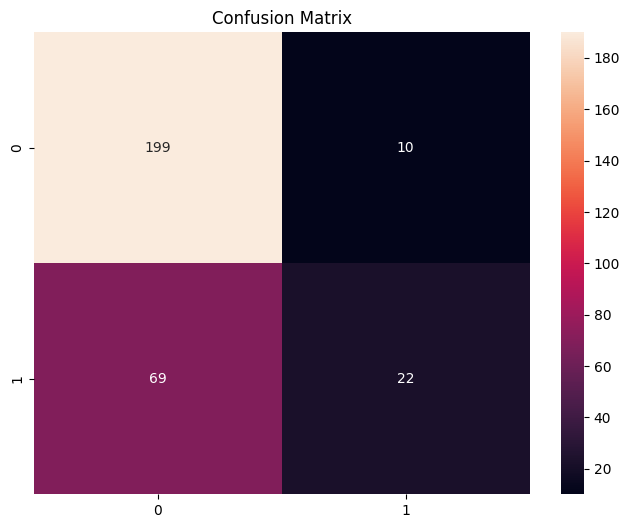

In [84]:
confusion_hard = confusion_matrix(y_test, y_prob_lgbm[:,1].round())
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, vmin=10, vmax=190,annot = True, fmt='d')
ax.set_title('Confusion Matrix')

In [85]:
rf_model, study_rf = train(X_train, y_train, X_test, y_test, balanced='balanced', method='RF')

[I 2024-05-29 19:56:28,268] A new study created in memory with name: RF Classifier


Tuning
Starting the optimization
RandomForest - Optimization using optuna


[I 2024-05-29 19:56:37,144] Trial 0 finished with value: 0.7233333333333334 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 29, 'min_samples_split': 17, 'n_estimators': 1242}. Best is trial 0 with value: 0.7233333333333334.


accuracy:0.7233333333333334
RandomForest - Optimization using optuna


[I 2024-05-29 19:56:41,407] Trial 1 finished with value: 0.73 and parameters: {'max_features': 6, 'min_samples_leaf': 11, 'max_depth': 31, 'min_samples_split': 16, 'n_estimators': 421}. Best is trial 1 with value: 0.73.


accuracy:0.73
RandomForest - Optimization using optuna


[I 2024-05-29 19:56:44,211] Trial 2 finished with value: 0.7266666666666667 and parameters: {'max_features': 10, 'min_samples_leaf': 15, 'max_depth': 42, 'min_samples_split': 16, 'n_estimators': 457}. Best is trial 1 with value: 0.73.


accuracy:0.7266666666666667
RandomForest - Optimization using optuna


[I 2024-05-29 19:56:45,391] Trial 3 finished with value: 0.7233333333333334 and parameters: {'max_features': 16, 'min_samples_leaf': 22, 'max_depth': 45, 'min_samples_split': 4, 'n_estimators': 198}. Best is trial 1 with value: 0.73.


accuracy:0.7233333333333334
RandomForest - Optimization using optuna


[I 2024-05-29 19:56:49,027] Trial 4 finished with value: 0.7233333333333334 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 40, 'min_samples_split': 25, 'n_estimators': 879}. Best is trial 1 with value: 0.73.


accuracy:0.7233333333333334
RandomForest - Optimization using optuna


[I 2024-05-29 19:56:54,945] Trial 5 finished with value: 0.7333333333333333 and parameters: {'max_features': 7, 'min_samples_leaf': 10, 'max_depth': 63, 'min_samples_split': 2, 'n_estimators': 822}. Best is trial 5 with value: 0.7333333333333333.


accuracy:0.7333333333333333
RandomForest - Optimization using optuna


[I 2024-05-29 19:56:58,762] Trial 6 finished with value: 0.7233333333333334 and parameters: {'max_features': 11, 'min_samples_leaf': 20, 'max_depth': 59, 'min_samples_split': 25, 'n_estimators': 1149}. Best is trial 5 with value: 0.7333333333333333.


accuracy:0.7233333333333334
RandomForest - Optimization using optuna


[I 2024-05-29 19:57:04,307] Trial 7 finished with value: 0.72 and parameters: {'max_features': 13, 'min_samples_leaf': 25, 'max_depth': 33, 'min_samples_split': 2, 'n_estimators': 1718}. Best is trial 5 with value: 0.7333333333333333.


accuracy:0.72
RandomForest - Optimization using optuna


[I 2024-05-29 19:57:08,218] Trial 8 finished with value: 0.7133333333333334 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 5, 'min_samples_split': 23, 'n_estimators': 644}. Best is trial 5 with value: 0.7333333333333333.


accuracy:0.7133333333333334
RandomForest - Optimization using optuna


[I 2024-05-29 19:57:14,526] Trial 9 finished with value: 0.7233333333333334 and parameters: {'max_features': 10, 'min_samples_leaf': 15, 'max_depth': 6, 'min_samples_split': 25, 'n_estimators': 1656}. Best is trial 5 with value: 0.7333333333333333.


accuracy:0.7233333333333334
RandomForest - Optimization using optuna


[I 2024-05-29 19:57:20,143] Trial 10 finished with value: 0.7266666666666667 and parameters: {'max_features': 19, 'min_samples_leaf': 2, 'max_depth': 60, 'min_samples_split': 8, 'n_estimators': 1383}. Best is trial 5 with value: 0.7333333333333333.


accuracy:0.7266666666666667
RandomForest - Optimization using optuna


[I 2024-05-29 19:57:22,177] Trial 11 finished with value: 0.7266666666666667 and parameters: {'max_features': 4, 'min_samples_leaf': 8, 'max_depth': 17, 'min_samples_split': 12, 'n_estimators': 727}. Best is trial 5 with value: 0.7333333333333333.


accuracy:0.7266666666666667
RandomForest - Optimization using optuna


[I 2024-05-29 19:57:22,789] Trial 12 finished with value: 0.7166666666666667 and parameters: {'max_features': 8, 'min_samples_leaf': 10, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 210}. Best is trial 5 with value: 0.7333333333333333.


accuracy:0.7166666666666667
RandomForest - Optimization using optuna


[I 2024-05-29 19:57:24,088] Trial 13 finished with value: 0.7233333333333334 and parameters: {'max_features': 4, 'min_samples_leaf': 9, 'max_depth': 52, 'min_samples_split': 10, 'n_estimators': 429}. Best is trial 5 with value: 0.7333333333333333.


accuracy:0.7233333333333334
RandomForest - Optimization using optuna


[I 2024-05-29 19:57:28,465] Trial 14 finished with value: 0.74 and parameters: {'max_features': 14, 'min_samples_leaf': 6, 'max_depth': 20, 'min_samples_split': 6, 'n_estimators': 921}. Best is trial 14 with value: 0.74.


accuracy:0.74
RandomForest - Optimization using optuna


[I 2024-05-29 19:57:31,262] Trial 15 finished with value: 0.73 and parameters: {'max_features': 15, 'min_samples_leaf': 3, 'max_depth': 17, 'min_samples_split': 6, 'n_estimators': 960}. Best is trial 14 with value: 0.74.


accuracy:0.73
RandomForest - Optimization using optuna


[I 2024-05-29 19:57:37,642] Trial 16 finished with value: 0.7533333333333333 and parameters: {'max_features': 14, 'min_samples_leaf': 6, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 1986}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7533333333333333
RandomForest - Optimization using optuna


[I 2024-05-29 19:57:42,860] Trial 17 finished with value: 0.7466666666666667 and parameters: {'max_features': 18, 'min_samples_leaf': 6, 'max_depth': 19, 'min_samples_split': 12, 'n_estimators': 1849}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7466666666666667
RandomForest - Optimization using optuna


[I 2024-05-29 19:57:49,271] Trial 18 finished with value: 0.7433333333333333 and parameters: {'max_features': 20, 'min_samples_leaf': 5, 'max_depth': 12, 'min_samples_split': 29, 'n_estimators': 1997}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7433333333333333
RandomForest - Optimization using optuna


[I 2024-05-29 19:57:54,817] Trial 19 finished with value: 0.7433333333333333 and parameters: {'max_features': 18, 'min_samples_leaf': 6, 'max_depth': 24, 'min_samples_split': 12, 'n_estimators': 1986}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7433333333333333
RandomForest - Optimization using optuna


[I 2024-05-29 19:57:59,470] Trial 20 finished with value: 0.7266666666666667 and parameters: {'max_features': 17, 'min_samples_leaf': 12, 'max_depth': 11, 'min_samples_split': 21, 'n_estimators': 1709}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7266666666666667
RandomForest - Optimization using optuna


[I 2024-05-29 19:58:05,464] Trial 21 finished with value: 0.74 and parameters: {'max_features': 20, 'min_samples_leaf': 5, 'max_depth': 12, 'min_samples_split': 29, 'n_estimators': 1947}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.74
RandomForest - Optimization using optuna


[I 2024-05-29 19:58:09,761] Trial 22 finished with value: 0.7366666666666667 and parameters: {'max_features': 20, 'min_samples_leaf': 4, 'max_depth': 12, 'min_samples_split': 29, 'n_estimators': 1561}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7366666666666667
RandomForest - Optimization using optuna


[I 2024-05-29 19:58:15,846] Trial 23 finished with value: 0.7466666666666667 and parameters: {'max_features': 17, 'min_samples_leaf': 7, 'max_depth': 22, 'min_samples_split': 13, 'n_estimators': 1867}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7466666666666667
RandomForest - Optimization using optuna


[I 2024-05-29 19:58:20,753] Trial 24 finished with value: 0.7433333333333333 and parameters: {'max_features': 17, 'min_samples_leaf': 7, 'max_depth': 25, 'min_samples_split': 13, 'n_estimators': 1808}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7433333333333333
RandomForest - Optimization using optuna


[I 2024-05-29 19:58:24,236] Trial 25 finished with value: 0.7233333333333334 and parameters: {'max_features': 15, 'min_samples_leaf': 13, 'max_depth': 21, 'min_samples_split': 9, 'n_estimators': 1427}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7233333333333334
RandomForest - Optimization using optuna


[I 2024-05-29 19:58:29,767] Trial 26 finished with value: 0.7366666666666667 and parameters: {'max_features': 13, 'min_samples_leaf': 8, 'max_depth': 37, 'min_samples_split': 14, 'n_estimators': 1832}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7366666666666667
RandomForest - Optimization using optuna


[I 2024-05-29 19:58:34,091] Trial 27 finished with value: 0.7466666666666667 and parameters: {'max_features': 18, 'min_samples_leaf': 3, 'max_depth': 28, 'min_samples_split': 19, 'n_estimators': 1529}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7466666666666667
RandomForest - Optimization using optuna


[I 2024-05-29 19:58:40,017] Trial 28 finished with value: 0.7366666666666667 and parameters: {'max_features': 14, 'min_samples_leaf': 2, 'max_depth': 18, 'min_samples_split': 7, 'n_estimators': 1838}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7366666666666667
RandomForest - Optimization using optuna


[I 2024-05-29 19:58:43,790] Trial 29 finished with value: 0.75 and parameters: {'max_features': 16, 'min_samples_leaf': 7, 'max_depth': 29, 'min_samples_split': 20, 'n_estimators': 1269}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.75
RandomForest - Optimization using optuna


[I 2024-05-29 19:58:46,875] Trial 30 finished with value: 0.73 and parameters: {'max_features': 16, 'min_samples_leaf': 9, 'max_depth': 30, 'min_samples_split': 20, 'n_estimators': 1171}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.73
RandomForest - Optimization using optuna


[I 2024-05-29 19:58:50,567] Trial 31 finished with value: 0.7433333333333333 and parameters: {'max_features': 18, 'min_samples_leaf': 7, 'max_depth': 27, 'min_samples_split': 14, 'n_estimators': 1324}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7433333333333333
RandomForest - Optimization using optuna


[I 2024-05-29 19:58:55,791] Trial 32 finished with value: 0.7366666666666667 and parameters: {'max_features': 16, 'min_samples_leaf': 5, 'max_depth': 35, 'min_samples_split': 10, 'n_estimators': 1555}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7366666666666667
RandomForest - Optimization using optuna


[I 2024-05-29 19:59:01,316] Trial 33 finished with value: 0.7333333333333333 and parameters: {'max_features': 17, 'min_samples_leaf': 11, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 1899}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7333333333333333
RandomForest - Optimization using optuna


[I 2024-05-29 19:59:06,033] Trial 34 finished with value: 0.73 and parameters: {'max_features': 12, 'min_samples_leaf': 8, 'max_depth': 15, 'min_samples_split': 22, 'n_estimators': 1747}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.73
RandomForest - Optimization using optuna


[I 2024-05-29 19:59:10,486] Trial 35 finished with value: 0.7433333333333333 and parameters: {'max_features': 15, 'min_samples_leaf': 6, 'max_depth': 31, 'min_samples_split': 15, 'n_estimators': 1476}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7433333333333333
RandomForest - Optimization using optuna


[I 2024-05-29 19:59:15,229] Trial 36 finished with value: 0.7266666666666667 and parameters: {'max_features': 19, 'min_samples_leaf': 15, 'max_depth': 41, 'min_samples_split': 16, 'n_estimators': 1630}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7266666666666667
RandomForest - Optimization using optuna


[I 2024-05-29 19:59:18,407] Trial 37 finished with value: 0.7466666666666667 and parameters: {'max_features': 14, 'min_samples_leaf': 4, 'max_depth': 46, 'min_samples_split': 4, 'n_estimators': 1065}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7466666666666667
RandomForest - Optimization using optuna


[I 2024-05-29 19:59:22,480] Trial 38 finished with value: 0.72 and parameters: {'max_features': 16, 'min_samples_leaf': 10, 'max_depth': 8, 'min_samples_split': 4, 'n_estimators': 1282}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.72
RandomForest - Optimization using optuna


[I 2024-05-29 19:59:27,125] Trial 39 finished with value: 0.7233333333333334 and parameters: {'max_features': 19, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 1906}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7233333333333334
RandomForest - Optimization using optuna


[I 2024-05-29 19:59:31,344] Trial 40 finished with value: 0.7233333333333334 and parameters: {'max_features': 12, 'min_samples_leaf': 13, 'max_depth': 37, 'min_samples_split': 11, 'n_estimators': 1796}. Best is trial 16 with value: 0.7533333333333333.


accuracy:0.7233333333333334
Last Fit


In [86]:
y_prob_rf = rf_model.predict_proba(X_test)

In [87]:
print('For the RandomForest Model, the test Accu is: '+ str(accuracy_score(y_test,y_prob_rf[:,1].round())))

For the RandomForest Model, the test Accu is: 0.7433333333333333


Text(0.5, 1.0, 'Confusion Matrix')

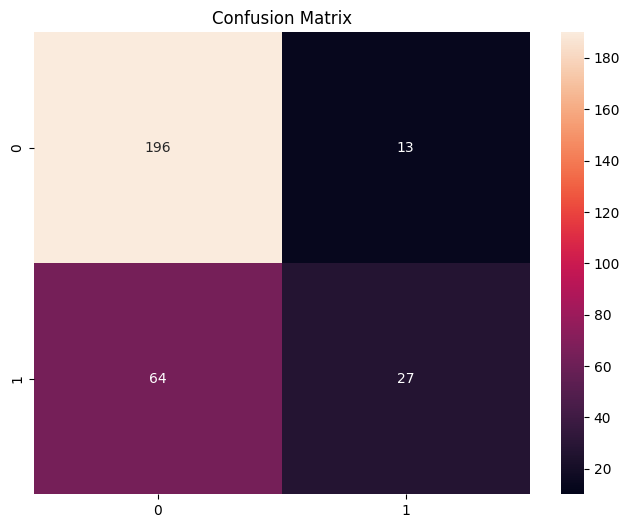

In [88]:
confusion_hard = confusion_matrix(y_test, y_prob_rf[:,1].round())
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, vmin=10, vmax=190,annot = True, fmt='d')
ax.set_title('Confusion Matrix')

LGBM model has a better performance after the optimization using optuna, so we'll this model as our final

# Ranking the final model

In [90]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



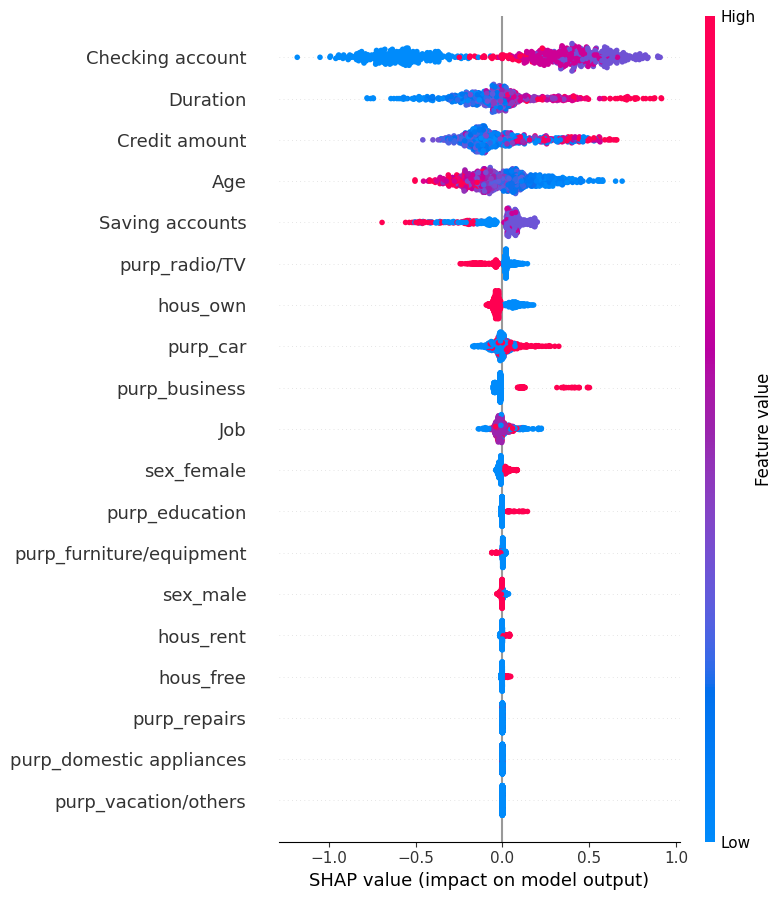

In [94]:
import shap
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train,show=False)

In [97]:
df_test = pd.concat([X_test, y_test],axis=1)
shap_test = explainer.shap_values(X_test)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



Here we are going to create new variables from shap. The goal is to make more easier to use our final model, for example we want to select the clients with hight scores and have more cash in checking account

In [101]:
def shap_col(shap_):
    col = ['Age', 'Job', 'Saving accounts', 'Checking account', 'Credit amount',
       'Duration', 'sex_female', 'sex_male', 'hous_free', 'hous_own',
       'hous_rent', 'purp_business', 'purp_car', 'purp_domestic appliances',
       'purp_education', 'purp_furniture/equipment', 'purp_radio/TV',
       'purp_repairs', 'purp_vacation/others']
    df_shap = pd.DataFrame(shap_test,columns=col)
#     shap_cols = {}
#     shap_cols['shap_1'] = np.nan
#     shap_cols['shap_2'] = np.nan
#     shap_cols['shap_3'] = np.nan
#     shap_cols['shap_4'] = np.nan
#     shap_cols['shap_5'] = np.nan
#     shap_cols['shap_6'] = np.nan
    df_shap.loc[df_shap['Checking account']>0.2, 'shap_1'] = 'Little Check Account'
    df_shap.loc[df_shap['Duration']>0.2, 'shap_2'] = 'More Credit Duration'
    df_shap.loc[df_shap['Credit amount']>0.2, 'shap_3'] = 'More Credit Amount'
    df_shap.loc[df_shap['Age']>0.2, 'shap_4'] = 'More Junior Client'
    df_shap.loc[df_shap['hous_own']>0.2, 'shap_5'] = 'Have House'
    df_shap.loc[df_shap['purp_radio/TV']>0.2, 'shap_6'] = 'The purpose is to buy Radio/TV'
    df_shap.loc[df_shap['Checking account']<-0.2, 'shap_7'] = 'Moderate/Rich Check Account'
    df_shap.loc[df_shap['Duration']<-0.2, 'shap_8'] = 'Less Credit Duration'
    df_shap.loc[df_shap['Credit amount']<-0.2, 'shap_9'] = 'Less Credit Amount'
    df_shap.loc[df_shap['Age']<-0.2, 'shap_10'] = 'More Senior Client'
    df_shap.loc[df_shap['hous_own']<-0.2, 'shap_11'] = 'Does not have House'
# pd.DataFrame(shap_test[1],columns=col).apply(shap_col, axis=1, result_type='expand')

    return df_shap[['shap_1','shap_2','shap_3','shap_4','shap_5','shap_6',
                    'shap_7','shap_8','shap_9','shap_10','shap_11']]

In [102]:
df_shap_arg = pd.DataFrame(shap_col(shap_test))
df_final = pd.concat([df_test.reset_index() ,df_shap_arg],axis=1)
df_final = df_final.fillna(0)
df_final

,index,Age,Job,Saving accounts,Checking account,Credit amount,Duration,sex_female,sex_male,hous_free,...,shap_2,shap_3,shap_4,shap_5,shap_6,shap_7,shap_8,shap_9,shap_10,shap_11
0,521,24,2,1,1,3190,18,True,False,False,...,0,0,More Junior Client,0,0,0,0,Less Credit Amount,0,0
1,737,35,1,2,1,4380,18,False,True,False,...,0,0,0,0,0,0,0,0,0,0
2,740,32,2,2,1,2325,24,False,True,False,...,0,0,0,0,0,0,0,Less Credit Amount,0,0
3,660,23,2,1,3,1297,12,False,True,False,...,0,More Credit Amount,More Junior Client,0,0,0,0,0,0,0
4,411,35,3,1,0,7253,33,False,True,False,...,0,More Credit Amount,0,0,0,Moderate/Rich Check Account,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,468,26,2,1,0,2764,33,True,False,False,...,0,0,0,0,0,Moderate/Rich Check Account,0,0,0,0
296,935,30,3,2,2,1919,30,False,True,False,...,More Credit Duration,0,0,0,0,0,0,0,0,0
297,428,20,2,1,0,1313,9,False,True,False,...,0,0,More Junior Client,0,0,Moderate/Rich Check Account,0,0,0,0
298,7,35,3,1,2,6948,36,False,True,False,...,More Credit Duration,0,0,0,0,0,0,0,0,0


creating a column score from our predeict_proba

In [103]:
df_final['score'] = y_prob_lgbm[:,1]

In [107]:
df_final['rank'] = pd.qcut(df_final['score'], 3,labels = False)
df_final.groupby('rank')[['Checking account','Duration', 'Age','Credit amount', 'hous_own',
                          'Saving accounts','purp_radio/TV','purp_car','sex_male','sex_female']].agg('mean')

,Checking account,Duration,Age,Credit amount,hous_own,Saving accounts,purp_radio/TV,purp_car,sex_male,sex_female
rank,,,,,,,,,,
0,0.50,15.63,39.10,2065.86,0.86,1.26,0.35,0.32,0.75,0.25
1,1.03,17.76,35.00,3197.23,0.74,1.17,0.18,0.29,0.70,0.30
2,1.38,26.87,32.91,3601.78,0.51,1.06,0.25,0.34,0.67,0.33


In [108]:
df_final.groupby('rank')[['Checking account','Duration', 'Age','Credit amount', 'hous_own',
                          'Saving accounts','purp_radio/TV','purp_car','sex_male','sex_female']].agg('mean').style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

,Checking account,Duration,Age,Credit amount,hous_own,Saving accounts,purp_radio/TV,purp_car,sex_male,sex_female
rank,,,,,,,,,,
0,0.500000,15.630000,39.100000,2065.860000,0.860000,1.260000,0.350000,0.320000,0.750000,0.250000
1,1.030000,17.760000,35.000000,3197.230000,0.740000,1.170000,0.180000,0.290000,0.700000,0.300000
2,1.380000,26.870000,32.910000,3601.780000,0.510000,1.060000,0.250000,0.340000,0.670000,0.330000


In [109]:
df_final.groupby('rank')[['Risk']].agg('sum').style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

,Risk
rank,
0,12
1,25
2,54


Our final model is:

In [ ]:
df_final[['score','rank','shap_1','shap_2','shap_3','shap_4','shap_5','shap_6',
        'shap_7','shap_8','shap_9','shap_10','shap_11']]